# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: ??, tileGridSize: ??
    
    clip_limits = [1.0,2,0,3,0,4,0]
    tile_grid_sizes = [(2,2), (4,4),(8,8)]

- `Label : Edema, Emphysema, Effusion, Atelectasis

- `Label Smoothing`: 0.2
    
- `Loss`: CategorialCrossEntropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip(p=0.5)
    
- `Strong Augment`: X
  
- `BackBone Model`: TF ResNet18
    
- `Freezing Layer`: 10% Layers
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

2024-08-18 15:46:00.614420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 15:46:00.614523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 15:46:00.747102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [5]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
df = df.drop(columns='Unnamed: 11')
df = df[~df['Finding Labels'].str.contains('\|')]
df = df.reset_index(drop=True)
print(f'Shape of DataFrame: {df.shape}')
df.head(10)

Shape of DataFrame: (91324, 11)


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
0  00000001_000.png   Cardiomegaly            0           1           58   
1  00000002_000.png     No Finding            0           2           81   
2  00000003_000.png         Hernia            0           3           81   
3  00000003_001.png         Hernia            1           3           74   
4  00000003_002.png         Hernia            2           3           75   
5  00000003_004.png         Hernia            4           3           77   
6  00000003_005.png         Hernia            5           3           78   
7  00000003_006.png         Hernia            6           3           79   
8  00000003_007.png         Hernia            7           3           80   
9  00000005_000.png     No Finding            0           5           69   

  Patient Gender View Position  OriginalImage[Width  Height]  \
0              M            PA                 2682     2749   
1              M            PA                 2500     2048   
2              F            PA                 2582     2991   
3              F            PA                 2500     2048   
4              F            PA                 2048     2500   
5              F            PA                 2500     2048   
6              F            PA                 2686     2991   
7              F            PA                 2992     2991   
8              F            PA                 2582     2905   
9              F            PA                 2048     2500   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                        0.171  0.171  
2                        0.143  0.143  
3                        0.168  0.168  
4                        0.168  0.168  
5                        0.168  0.168  
6                        0.143  0.143  
7                        0.143  0.143  
8                        0.143  0.143  
9                        0.168  0.168

In [6]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 546 ms, sys: 64.7 ms, total: 611 ms
Wall time: 4.08 s


#### Loading Pneumonia
___

- width: 1200
- height: 825

In [7]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

#### Loading tuberculosis
___
- width: 512
- height: 512

In [8]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.png'))}        
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)

df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

#### Load Covid-19
___

- height: 825
- width: 1200

In [9]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)

df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df = df[['Image Index','Finding Labels', 'path']]

In [10]:
df_1 = pd.concat([df[df['Finding Labels'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Finding Labels'] == 'Emphysema'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Finding Labels'] == 'Effusion'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Finding Labels'] == 'Atelectasis'].sample(500, random_state=42)])


df_all=[df_1,df_2,df_3,df_4]
df = pd.concat(df_all)
df = df.reset_index(drop=True)

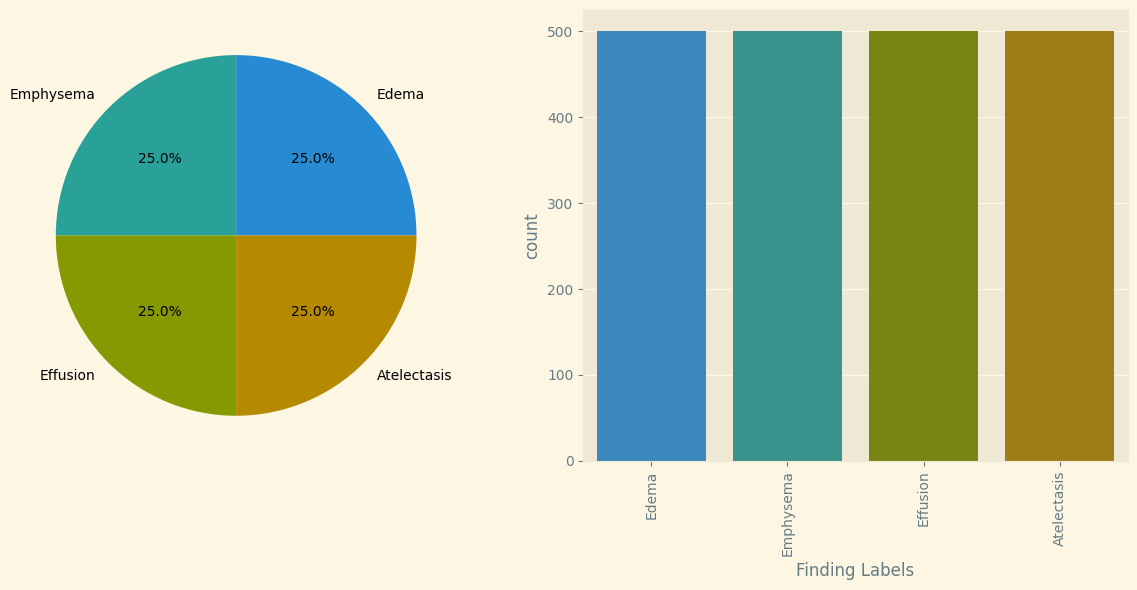

In [11]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**Train & Test Split**

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [13]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-len(df_all):].tolist()

In [14]:
TARGET

['Edema', 'Emphysema', 'Effusion', 'Atelectasis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [15]:
import albumentations as albu
print(albu.__version__)

1.4.0


In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None, clip_limit=2.0, tile_grid_size=(4,4)):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

    def __len__(self):

        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y

    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):

        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 

            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j,:,:] = img
            y[j,] = row[TARGET]

        return X,y

    def __augment1(self, img_batch):

        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),            

        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0) 

        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:  
                j = idx[i]

                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)

        return img_batch


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

**Install ResNet**

In [17]:
!pip install -q git+https://github.com/qubvel/classification_models.git

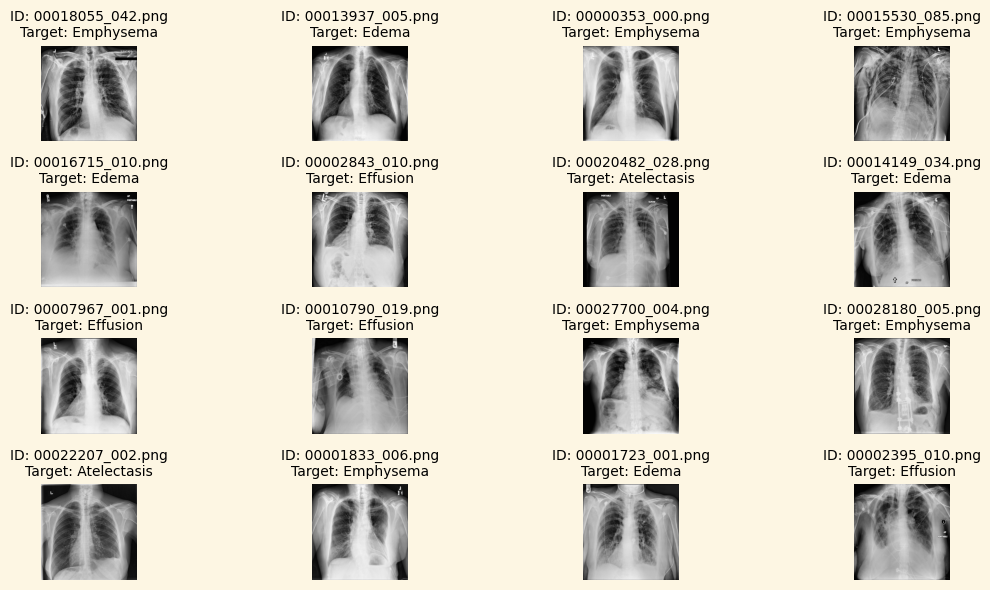

In [18]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [19]:
def temp_f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = 10

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [21]:
def build_model(): 
    inp = tf.keras.layers.Input(shape=(256,256,3)) 
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3)) 
    res_model._name = 'resnet18' 

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x, name='hybrid')

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', temp_f1_score])

    return model

In [22]:
from tensorflow.keras.utils import plot_model

model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 8, 8, 512)      │    11,186,889 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,188,941 (42.68 MB)

 Trainable params: 11,171,460 (42.62 MB)

 Non-trainable params: 17,481 (68.29 KB)

#### StratifiedKFold

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

In [24]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

Training with CLAHE settings: clip_limit=1.0, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 89s 664ms/step - accuracy: 0.3148 - loss: 1.9127 - temp_f1_score: 0.2590 - val_accuracy: 0.3250 - val_loss: 2.9580 - val_temp_f1_score: 0.2413 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.4161 - loss: 1.3337 - temp_f1_score: 0.3566 - val_accuracy: 0.5125 - val_loss: 1.3615 - val_temp_f1_score: 0.4811 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.4517 - loss: 1.2954 - temp_f1_score: 0.3728 - val_accuracy: 0.3750 - val_loss: 1.6077 - val_temp_f1_score: 0.2856 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4894 - loss: 1.2488 - temp_f1_score: 0.3994 - val_accuracy: 0.3187 - val_loss: 2.3662 - val_temp_f1_score: 0.1929 - learning_rate: 0.0010
Epoch 5/10
80

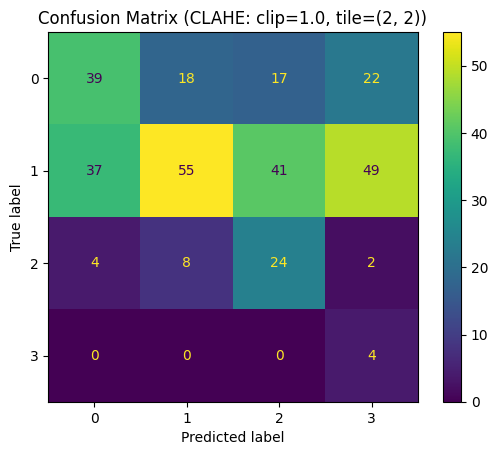

Accuracy for Validation Set = 0.38125
F1 Score for Validation Set = 0.3400495502127314
Training with CLAHE settings: clip_limit=1.0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 478ms/step - accuracy: 0.3194 - loss: 1.8900 - temp_f1_score: 0.2468 - val_accuracy: 0.2937 - val_loss: 3.2292 - val_temp_f1_score: 0.1846 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4222 - loss: 1.3317 - temp_f1_score: 0.3368 - val_accuracy: 0.3250 - val_loss: 1.8090 - val_temp_f1_score: 0.2365 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.4342 - loss: 1.2970 - temp_f1_score: 0.3597 - val_accuracy: 0.3688 - val_loss: 1.5686 - val_temp_f1_score: 0.3008 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.4994 - loss: 1.2307 - temp_f1_score: 0.4273 - val_accuracy: 0.38

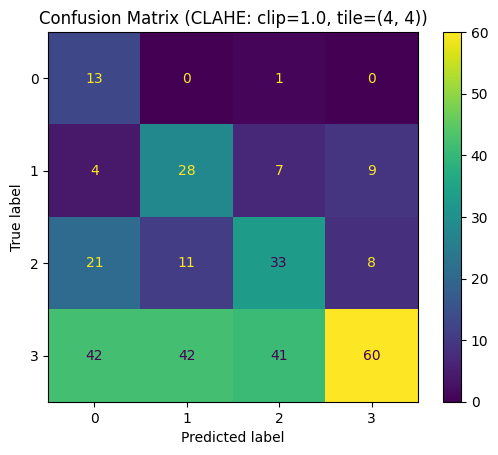

Accuracy for Validation Set = 0.41875
F1 Score for Validation Set = 0.3986314976502774
Training with CLAHE settings: clip_limit=1.0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 483ms/step - accuracy: 0.3327 - loss: 1.9295 - temp_f1_score: 0.2690 - val_accuracy: 0.2875 - val_loss: 4.7356 - val_temp_f1_score: 0.1506 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.3818 - loss: 1.3608 - temp_f1_score: 0.2949 - val_accuracy: 0.4062 - val_loss: 1.4511 - val_temp_f1_score: 0.3596 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4767 - loss: 1.2767 - temp_f1_score: 0.3813 - val_accuracy: 0.4125 - val_loss: 1.3265 - val_temp_f1_score: 0.3566 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.4686 - loss: 1.2750 - temp_f1_score: 0.3706 - val_accuracy: 0.47

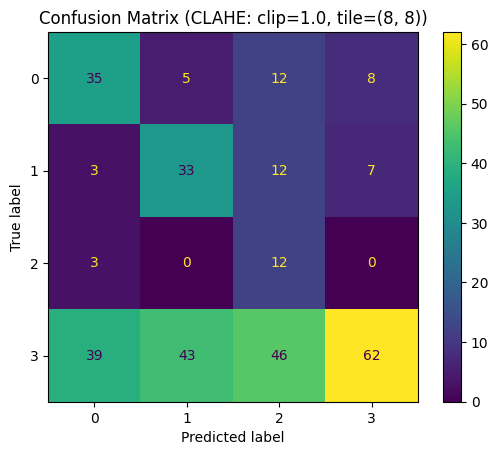

Accuracy for Validation Set = 0.44375
F1 Score for Validation Set = 0.4242840684287152
Training with CLAHE settings: clip_limit=2, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 477ms/step - accuracy: 0.2852 - loss: 1.8632 - temp_f1_score: 0.2231 - val_accuracy: 0.2625 - val_loss: 394.7628 - val_temp_f1_score: 0.1595 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.3474 - loss: 1.3598 - temp_f1_score: 0.2849 - val_accuracy: 0.2625 - val_loss: 12.8914 - val_temp_f1_score: 0.1497 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4241 - loss: 1.3176 - temp_f1_score: 0.3213 - val_accuracy: 0.3125 - val_loss: 1.5187 - val_temp_f1_score: 0.2581 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4449 - loss: 1.3144 - temp_f1_score: 0.3691 - val_accuracy: 0.5

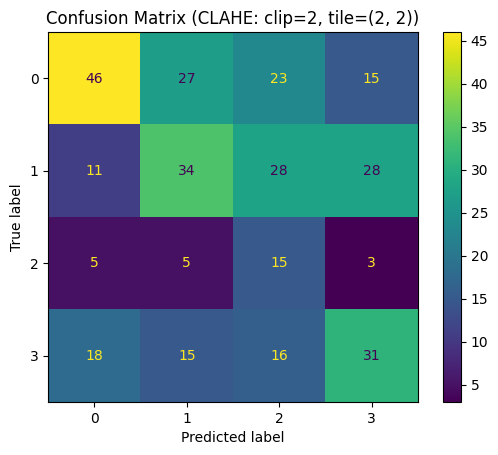

Accuracy for Validation Set = 0.39375
F1 Score for Validation Set = 0.3807333744056324
Training with CLAHE settings: clip_limit=2, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 482ms/step - accuracy: 0.3020 - loss: 1.9076 - temp_f1_score: 0.2350 - val_accuracy: 0.2500 - val_loss: 11.0054 - val_temp_f1_score: 0.1494 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4738 - loss: 1.2798 - temp_f1_score: 0.3986 - val_accuracy: 0.3500 - val_loss: 2.2543 - val_temp_f1_score: 0.2402 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4908 - loss: 1.2590 - temp_f1_score: 0.4080 - val_accuracy: 0.4313 - val_loss: 1.4120 - val_temp_f1_score: 0.3689 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.5394 - loss: 1.2004 - temp_f1_score: 0.4644 - val_accuracy: 0.325

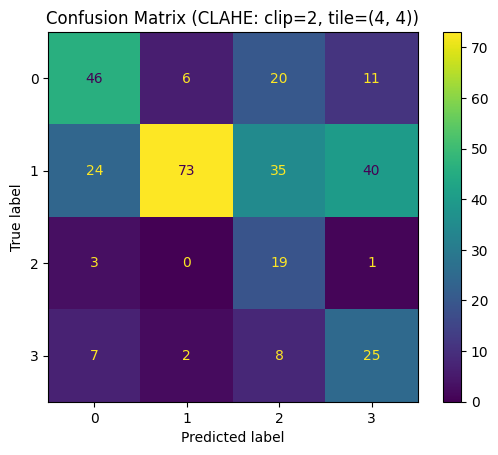

Accuracy for Validation Set = 0.509375
F1 Score for Validation Set = 0.48089127646499813
Training with CLAHE settings: clip_limit=2, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.3000 - loss: 1.9282 - temp_f1_score: 0.2337 - val_accuracy: 0.2562 - val_loss: 4.5422 - val_temp_f1_score: 0.1161 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.4283 - loss: 1.3151 - temp_f1_score: 0.3480 - val_accuracy: 0.3500 - val_loss: 1.6684 - val_temp_f1_score: 0.2812 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.4999 - loss: 1.2820 - temp_f1_score: 0.4206 - val_accuracy: 0.4938 - val_loss: 1.4649 - val_temp_f1_score: 0.4107 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.5169 - loss: 1.2238 - temp_f1_score: 0.4398 - val_accuracy: 0.45

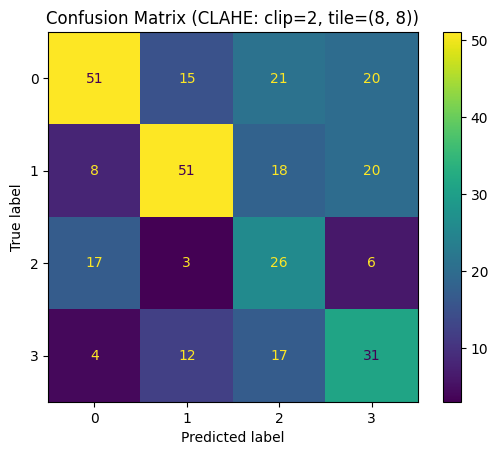

Accuracy for Validation Set = 0.496875
F1 Score for Validation Set = 0.4865660667172472
Training with CLAHE settings: clip_limit=0, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.3158 - loss: 1.8826 - temp_f1_score: 0.2610 - val_accuracy: 0.3000 - val_loss: 2.0897 - val_temp_f1_score: 0.1767 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.4632 - loss: 1.2997 - temp_f1_score: 0.3914 - val_accuracy: 0.3938 - val_loss: 1.3337 - val_temp_f1_score: 0.3267 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4572 - loss: 1.2920 - temp_f1_score: 0.3776 - val_accuracy: 0.3875 - val_loss: 1.5355 - val_temp_f1_score: 0.2935 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.5325 - loss: 1.2405 - temp_f1_score: 0.4746 - val_accuracy: 0.300

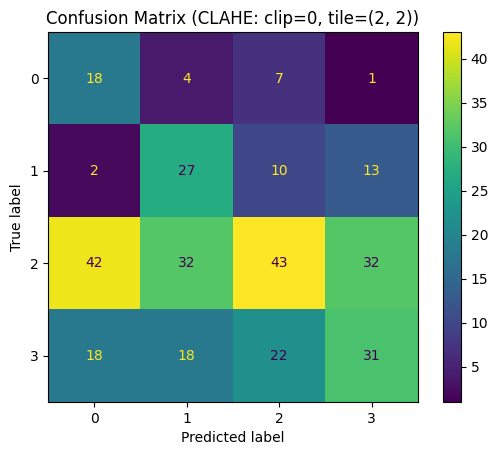

Accuracy for Validation Set = 0.371875
F1 Score for Validation Set = 0.36976902826617475
Training with CLAHE settings: clip_limit=0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.3465 - loss: 1.8888 - temp_f1_score: 0.2739 - val_accuracy: 0.3688 - val_loss: 2.2624 - val_temp_f1_score: 0.2481 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.3986 - loss: 1.3253 - temp_f1_score: 0.3282 - val_accuracy: 0.2500 - val_loss: 3.4996 - val_temp_f1_score: 0.0990 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.5096 - loss: 1.2492 - temp_f1_score: 0.4554 - val_accuracy: 0.3063 - val_loss: 1.5900 - val_temp_f1_score: 0.1968 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.5328 - loss: 1.2166 - temp_f1_score: 0.4595 - val_accuracy: 0.48

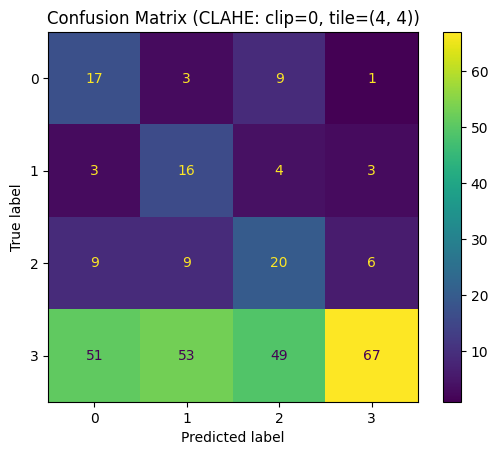

Accuracy for Validation Set = 0.375
F1 Score for Validation Set = 0.3441987745726064
Training with CLAHE settings: clip_limit=0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.3242 - loss: 1.8349 - temp_f1_score: 0.2524 - val_accuracy: 0.2625 - val_loss: 5.1111 - val_temp_f1_score: 0.1031 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 446ms/step - accuracy: 0.4162 - loss: 1.3106 - temp_f1_score: 0.3404 - val_accuracy: 0.3812 - val_loss: 1.4099 - val_temp_f1_score: 0.3555 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.4765 - loss: 1.2696 - temp_f1_score: 0.4159 - val_accuracy: 0.4000 - val_loss: 1.5440 - val_temp_f1_score: 0.3481 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4954 - loss: 1.2456 - temp_f1_score: 0.4112 - val_accuracy: 0.4437 -

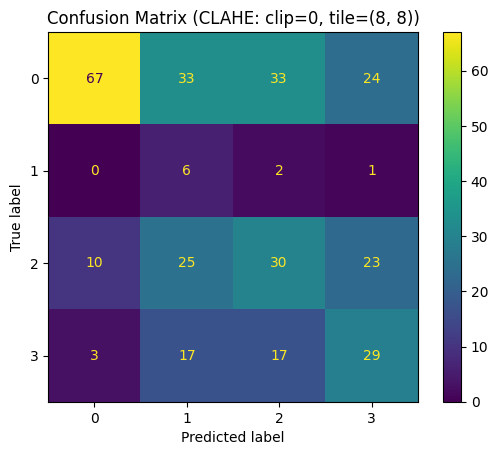

Accuracy for Validation Set = 0.4125
F1 Score for Validation Set = 0.36431743982004594
Training with CLAHE settings: clip_limit=3, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.3074 - loss: 1.8907 - temp_f1_score: 0.2528 - val_accuracy: 0.2500 - val_loss: 5.3558 - val_temp_f1_score: 0.1469 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4070 - loss: 1.3417 - temp_f1_score: 0.3219 - val_accuracy: 0.2812 - val_loss: 1.6143 - val_temp_f1_score: 0.1835 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4852 - loss: 1.2662 - temp_f1_score: 0.4072 - val_accuracy: 0.3125 - val_loss: 1.9774 - val_temp_f1_score: 0.1738 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.5030 - loss: 1.2272 - temp_f1_score: 0.4258 - val_accuracy: 0.4062

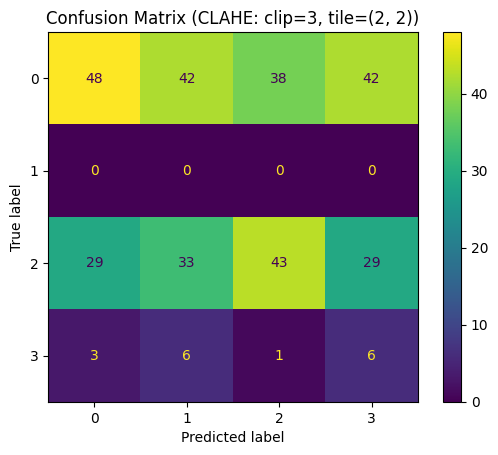

Accuracy for Validation Set = 0.303125
F1 Score for Validation Set = 0.22779510155316607
Training with CLAHE settings: clip_limit=3, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 483ms/step - accuracy: 0.3194 - loss: 1.9930 - temp_f1_score: 0.2565 - val_accuracy: 0.2750 - val_loss: 2.8078 - val_temp_f1_score: 0.1708 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 445ms/step - accuracy: 0.4221 - loss: 1.3416 - temp_f1_score: 0.3355 - val_accuracy: 0.3562 - val_loss: 2.3078 - val_temp_f1_score: 0.2369 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4974 - loss: 1.2449 - temp_f1_score: 0.4100 - val_accuracy: 0.3063 - val_loss: 1.6590 - val_temp_f1_score: 0.1811 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 442ms/step - accuracy: 0.5087 - loss: 1.2428 - temp_f1_score: 0.4368 - val_accuracy: 0.44

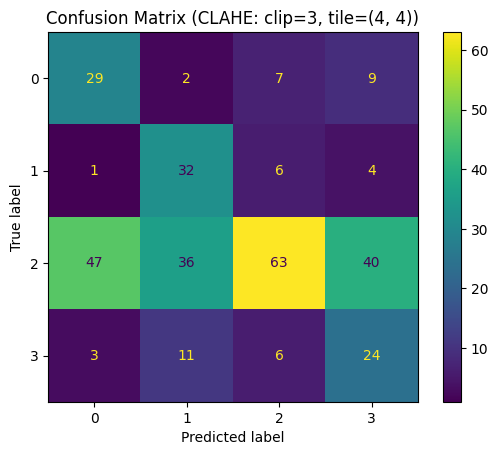

Accuracy for Validation Set = 0.4625
F1 Score for Validation Set = 0.4599163535628169
Training with CLAHE settings: clip_limit=3, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.3059 - loss: 1.9357 - temp_f1_score: 0.2517 - val_accuracy: 0.2688 - val_loss: 9.2023 - val_temp_f1_score: 0.1225 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.4061 - loss: 1.3274 - temp_f1_score: 0.3253 - val_accuracy: 0.2688 - val_loss: 1.4894 - val_temp_f1_score: 0.1668 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.5158 - loss: 1.2514 - temp_f1_score: 0.4213 - val_accuracy: 0.3125 - val_loss: 1.9399 - val_temp_f1_score: 0.2008 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.5165 - loss: 1.2275 - temp_f1_score: 0.4414 - val_accuracy: 0.3562 

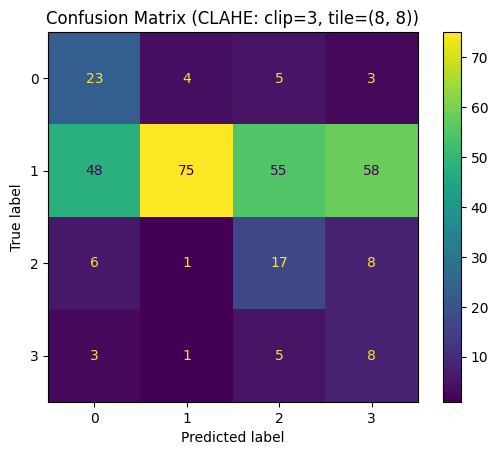

Accuracy for Validation Set = 0.384375
F1 Score for Validation Set = 0.33541112496658787
Training with CLAHE settings: clip_limit=0, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.3185 - loss: 1.9322 - temp_f1_score: 0.2545 - val_accuracy: 0.3187 - val_loss: 1.9102 - val_temp_f1_score: 0.2048 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.3842 - loss: 1.3535 - temp_f1_score: 0.3003 - val_accuracy: 0.3875 - val_loss: 1.4213 - val_temp_f1_score: 0.3433 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4539 - loss: 1.2715 - temp_f1_score: 0.3720 - val_accuracy: 0.3187 - val_loss: 2.1462 - val_temp_f1_score: 0.1913 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.5005 - loss: 1.2400 - temp_f1_score: 0.4403 - val_accuracy: 0.33

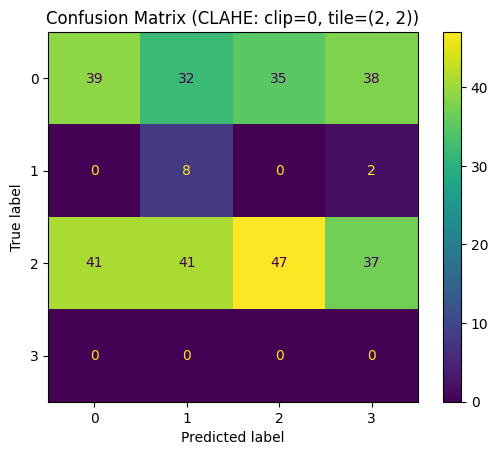

Accuracy for Validation Set = 0.29375
F1 Score for Validation Set = 0.2257676799007444
Training with CLAHE settings: clip_limit=0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 482ms/step - accuracy: 0.2908 - loss: 1.8696 - temp_f1_score: 0.2342 - val_accuracy: 0.2313 - val_loss: 10.3266 - val_temp_f1_score: 0.0986 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.3665 - loss: 1.3296 - temp_f1_score: 0.2807 - val_accuracy: 0.4437 - val_loss: 1.4803 - val_temp_f1_score: 0.4379 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.4763 - loss: 1.2564 - temp_f1_score: 0.4060 - val_accuracy: 0.4125 - val_loss: 1.4344 - val_temp_f1_score: 0.3667 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4889 - loss: 1.2408 - temp_f1_score: 0.4155 - val_accuracy: 0.412

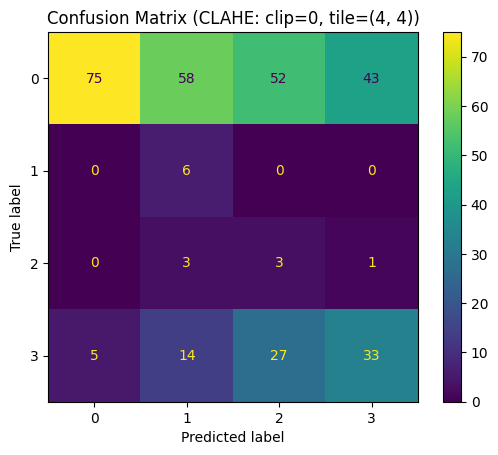

Accuracy for Validation Set = 0.365625
F1 Score for Validation Set = 0.27885916872743677
Training with CLAHE settings: clip_limit=0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 479ms/step - accuracy: 0.3312 - loss: 1.9410 - temp_f1_score: 0.2650 - val_accuracy: 0.2313 - val_loss: 120.0133 - val_temp_f1_score: 0.0928 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.3892 - loss: 1.3346 - temp_f1_score: 0.3086 - val_accuracy: 0.4625 - val_loss: 1.4930 - val_temp_f1_score: 0.4293 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.4619 - loss: 1.2911 - temp_f1_score: 0.3863 - val_accuracy: 0.4875 - val_loss: 1.3204 - val_temp_f1_score: 0.4099 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.5208 - loss: 1.2410 - temp_f1_score: 0.4162 - val_accuracy: 0.

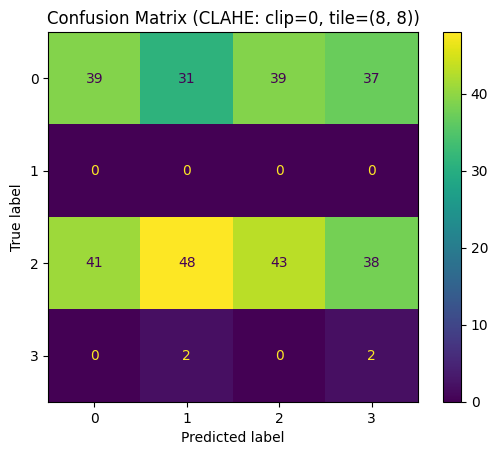

Accuracy for Validation Set = 0.2625
F1 Score for Validation Set = 0.18394632517051396
Training with CLAHE settings: clip_limit=4, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 478ms/step - accuracy: 0.3187 - loss: 1.8530 - temp_f1_score: 0.2441 - val_accuracy: 0.2375 - val_loss: 3.3198 - val_temp_f1_score: 0.1234 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4129 - loss: 1.3210 - temp_f1_score: 0.3211 - val_accuracy: 0.3625 - val_loss: 1.5685 - val_temp_f1_score: 0.2913 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4559 - loss: 1.2984 - temp_f1_score: 0.3859 - val_accuracy: 0.4313 - val_loss: 1.3166 - val_temp_f1_score: 0.4014 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4931 - loss: 1.2545 - temp_f1_score: 0.4107 - val_accuracy: 0.5000

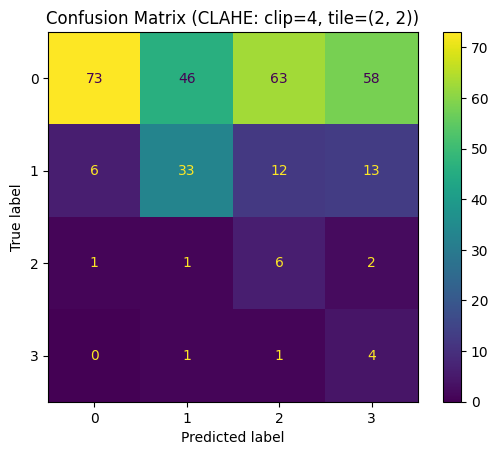

Accuracy for Validation Set = 0.3625
F1 Score for Validation Set = 0.2845606846426184
Training with CLAHE settings: clip_limit=4, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.3435 - loss: 1.9973 - temp_f1_score: 0.2523 - val_accuracy: 0.3063 - val_loss: 3.0833 - val_temp_f1_score: 0.2062 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4523 - loss: 1.2913 - temp_f1_score: 0.3677 - val_accuracy: 0.4187 - val_loss: 1.5982 - val_temp_f1_score: 0.3335 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 437ms/step - accuracy: 0.4987 - loss: 1.2551 - temp_f1_score: 0.4184 - val_accuracy: 0.4062 - val_loss: 2.0692 - val_temp_f1_score: 0.2889 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.5440 - loss: 1.2100 - temp_f1_score: 0.4655 - val_accuracy: 0.4437 

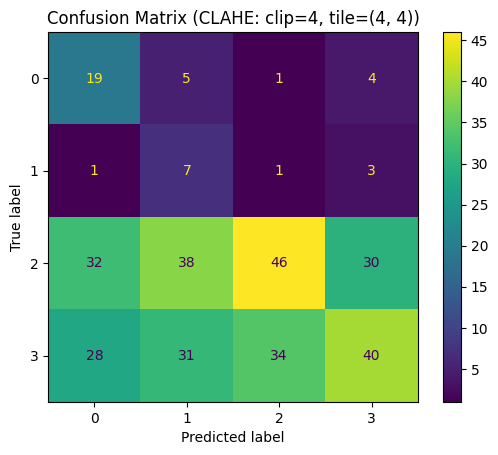

Accuracy for Validation Set = 0.35
F1 Score for Validation Set = 0.3209056601254542
Training with CLAHE settings: clip_limit=4, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 482ms/step - accuracy: 0.3193 - loss: 2.0128 - temp_f1_score: 0.2617 - val_accuracy: 0.2750 - val_loss: 2.4839 - val_temp_f1_score: 0.1615 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4145 - loss: 1.3334 - temp_f1_score: 0.3437 - val_accuracy: 0.5063 - val_loss: 1.2575 - val_temp_f1_score: 0.4646 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4847 - loss: 1.2929 - temp_f1_score: 0.3916 - val_accuracy: 0.5562 - val_loss: 1.1884 - val_temp_f1_score: 0.5206 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.5134 - loss: 1.2449 - temp_f1_score: 0.4337 - val_accuracy: 0.4000 - 

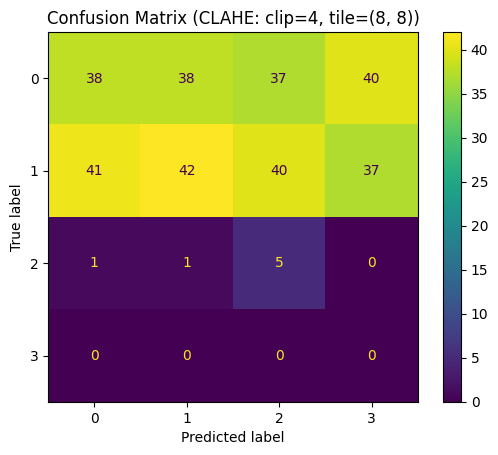

Accuracy for Validation Set = 0.265625
F1 Score for Validation Set = 0.19677188147871275
Training with CLAHE settings: clip_limit=0, tile_grid_size=(2, 2)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 482ms/step - accuracy: 0.3548 - loss: 1.7978 - temp_f1_score: 0.2855 - val_accuracy: 0.2500 - val_loss: 14.3964 - val_temp_f1_score: 0.0998 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4253 - loss: 1.3222 - temp_f1_score: 0.3373 - val_accuracy: 0.3875 - val_loss: 1.4740 - val_temp_f1_score: 0.3711 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 439ms/step - accuracy: 0.4840 - loss: 1.2549 - temp_f1_score: 0.4177 - val_accuracy: 0.3750 - val_loss: 1.4572 - val_temp_f1_score: 0.3376 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4749 - loss: 1.2634 - temp_f1_score: 0.3964 - val_accuracy: 0.4

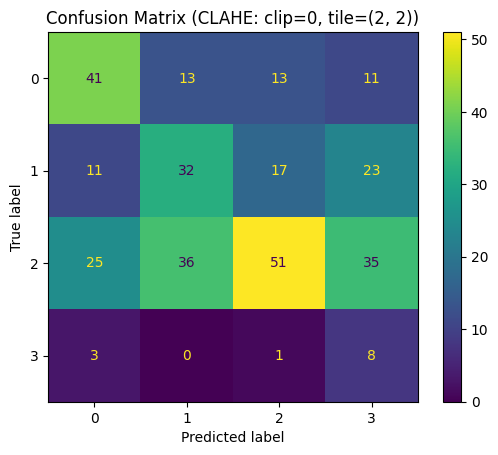

Accuracy for Validation Set = 0.4125
F1 Score for Validation Set = 0.38360534306790617
Training with CLAHE settings: clip_limit=0, tile_grid_size=(4, 4)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 480ms/step - accuracy: 0.3100 - loss: 1.9511 - temp_f1_score: 0.2386 - val_accuracy: 0.3313 - val_loss: 2.2147 - val_temp_f1_score: 0.2729 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step - accuracy: 0.3990 - loss: 1.3225 - temp_f1_score: 0.2951 - val_accuracy: 0.3875 - val_loss: 1.4058 - val_temp_f1_score: 0.3300 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - accuracy: 0.4623 - loss: 1.2953 - temp_f1_score: 0.3763 - val_accuracy: 0.2750 - val_loss: 2.8366 - val_temp_f1_score: 0.1735 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.4860 - loss: 1.2573 - temp_f1_score: 0.4169 - val_accuracy: 0.2688

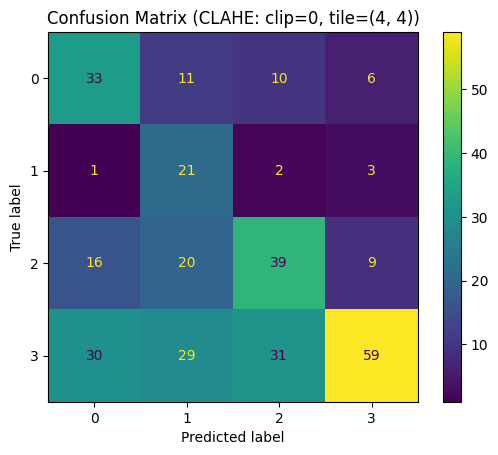

Accuracy for Validation Set = 0.475
F1 Score for Validation Set = 0.46308021804876487
Training with CLAHE settings: clip_limit=0, tile_grid_size=(8, 8)
#########################
### Fold 1
### train size 1280, valid size 320
#########################
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 483ms/step - accuracy: 0.3462 - loss: 1.8640 - temp_f1_score: 0.2869 - val_accuracy: 0.2375 - val_loss: 7.0005 - val_temp_f1_score: 0.1566 - learning_rate: 0.0010
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 440ms/step - accuracy: 0.4352 - loss: 1.3275 - temp_f1_score: 0.3444 - val_accuracy: 0.2313 - val_loss: 1.7571 - val_temp_f1_score: 0.0957 - learning_rate: 0.0010
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4346 - loss: 1.3112 - temp_f1_score: 0.3724 - val_accuracy: 0.2313 - val_loss: 1.8636 - val_temp_f1_score: 0.0933 - learning_rate: 0.0010
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 438ms/step - accuracy: 0.4606 - loss: 1.2724 - temp_f1_score: 0.3900 - val_accuracy: 0.4375 

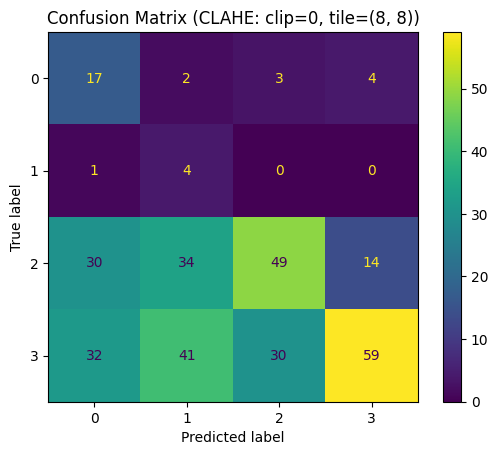

Accuracy for Validation Set = 0.403125
F1 Score for Validation Set = 0.34410033592464273


In [25]:
import tensorflow.keras.backend as K
from collections import defaultdict

clip_limits = [1.0,2,0,3,0,4,0]
tile_grid_sizes = [(2,2), (4,4),(8,8)]
results = []

for clip_limit in clip_limits:
    for tile_grid_size in tile_grid_sizes:
        print(f"Training with CLAHE settings: clip_limit={clip_limit}, tile_grid_size={tile_grid_size}")
        
        all_oof = []
        all_true = []
        all_index = []
        all_history = defaultdict(list)

        for i in range(1):  # 나중에 fold 수를 변경할 수 있도록 유지
            print('#'*25)
            print(f'### Fold {i+1}')
            
            train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, 
                                      batch_size=16, preprocess=preprocess_input, 
                                      clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, 
                                      preprocess=preprocess_input,
                                      clip_limit=clip_limit, tile_grid_size=tile_grid_size)
            
            print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
            print('#'*25)
            
            K.clear_session()
            with strategy.scope():
                model = build_model()
            
            if LOAD_MODELS_FROM is None:
                history = model.fit(train_gen, verbose=1,
                          validation_data=valid_gen,
                          epochs=EPOCHS, callbacks=[lr])
                model.save_weights(f'ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
                all_history['Train Loss'].append(history.history['loss'])
                all_history['Valid Loss'].append(history.history['val_loss'])
                all_history['Valid F1'].append(history.history['val_temp_f1_score'])
                all_history['Train F1'].append(history.history['temp_f1_score'])
                all_history['Valid Accuracy'].append(history.history['val_accuracy'])
                all_history['Train Accuracy'].append(history.history['accuracy'])
            else:
                model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
            
            oof = model.predict(valid_gen, verbose=1)
            all_oof.append(oof)
            all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
            all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
            
            plt.style.use('default')
            cm = confusion_matrix(np.argmax(oof, axis=1), np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), labels=[x for x in range(len(TARGET))])
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(len(TARGET))])  
            disp.plot()
            plt.title(f'Confusion Matrix (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
            plt.show()
            
            del model, oof
            gc.collect()
        
        all_oof = np.concatenate(all_oof)
        all_true = np.concatenate(all_true)
        all_index = np.concatenate(all_index)
        
        # 성능 평가 및 결과 저장
        accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
        f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1), average='macro')
        
        print(f'Accuracy for Validation Set = {accuracy}')
        print(f'F1 Score for Validation Set = {f1}')
        
        results.append({
            'clip_limit': clip_limit,
            'tile_grid_size': tile_grid_size,
            'accuracy': accuracy,
            'f1_score': f1,
            'all_history': all_history,
            'all_oof': all_oof,
            'all_true': all_true,
            'all_index': all_index
        })
        
        del train_gen, valid_gen
        gc.collect()

<Figure size 1200x1000 with 0 Axes>

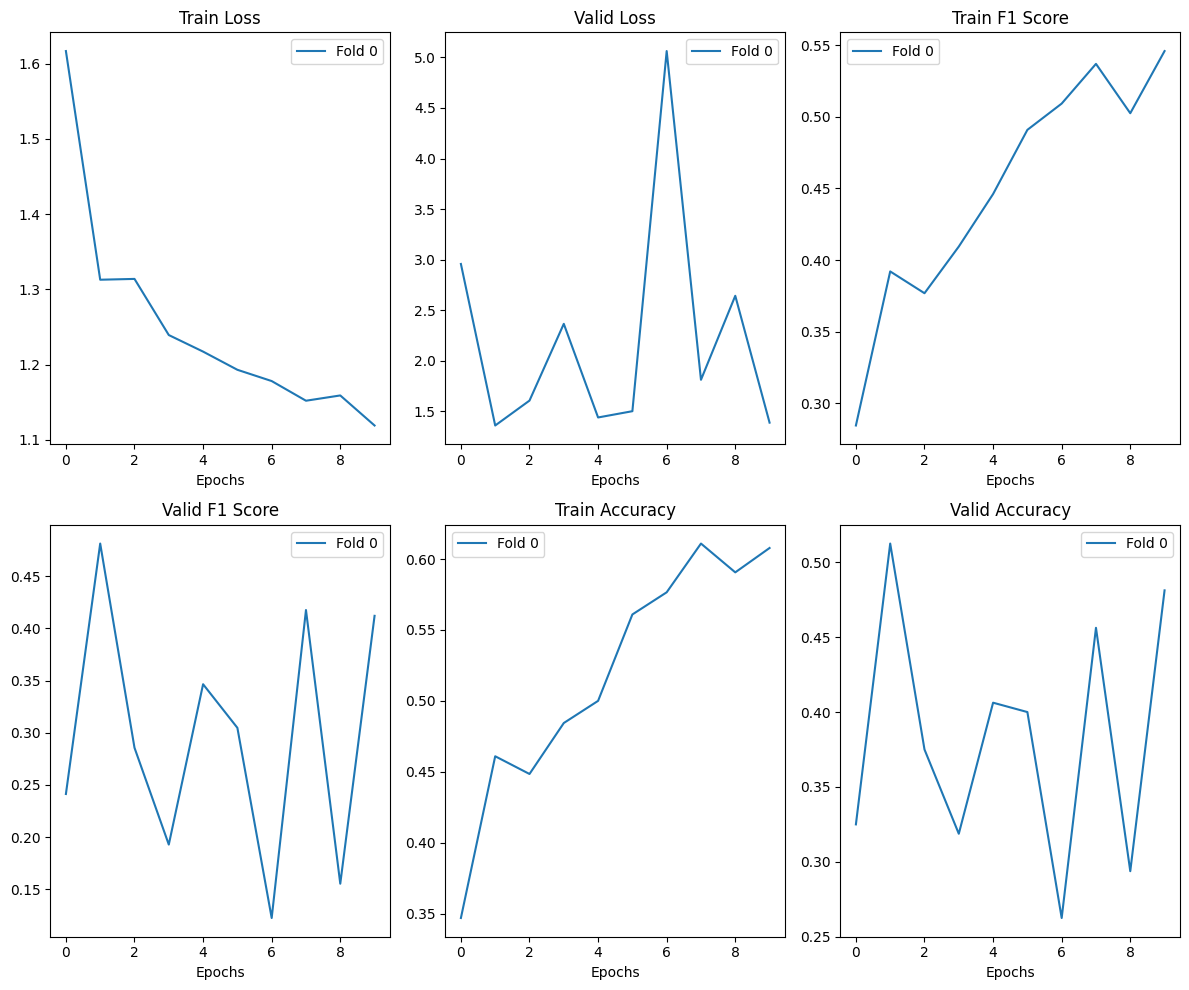

<Figure size 1200x1000 with 0 Axes>

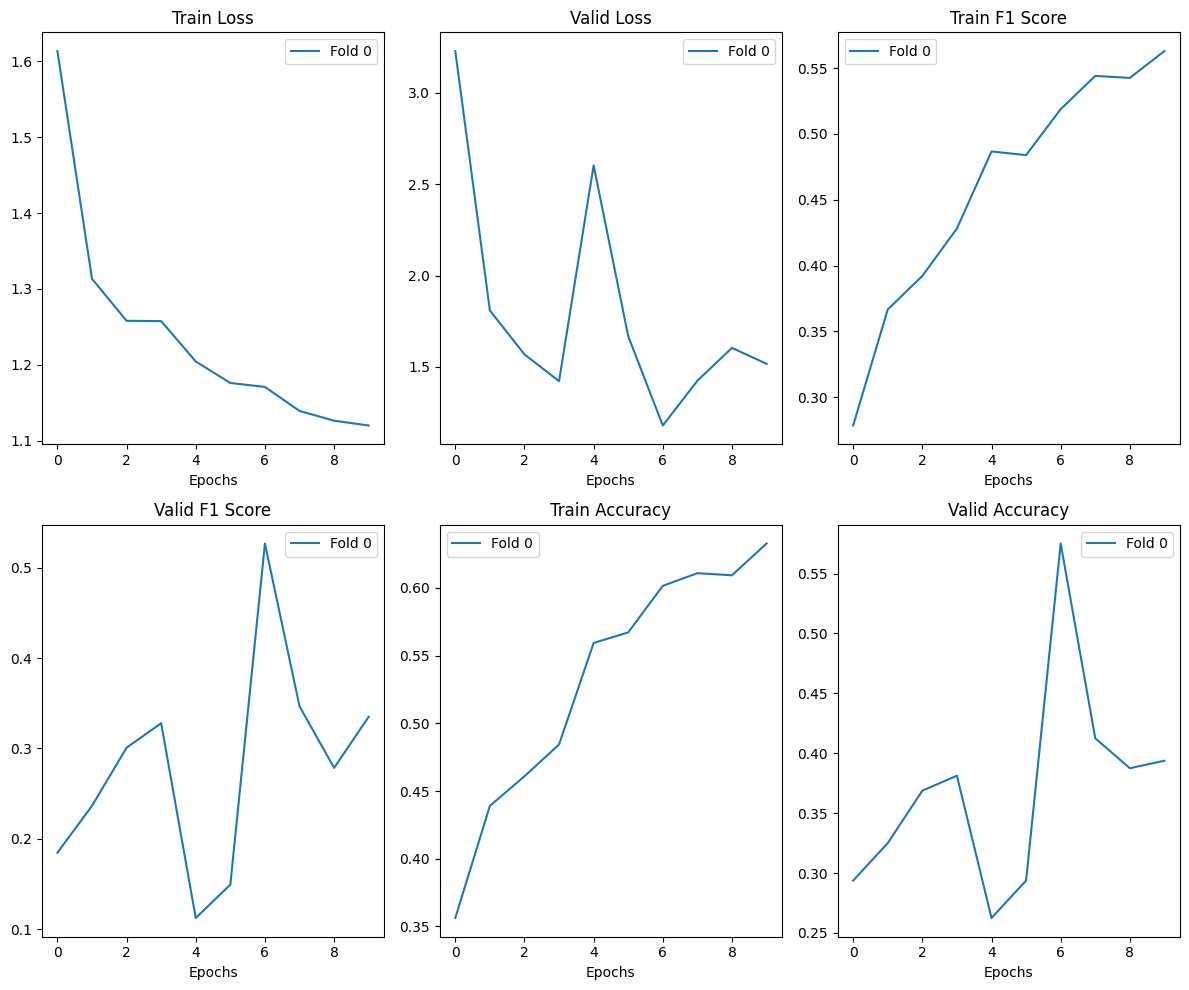

<Figure size 1200x1000 with 0 Axes>

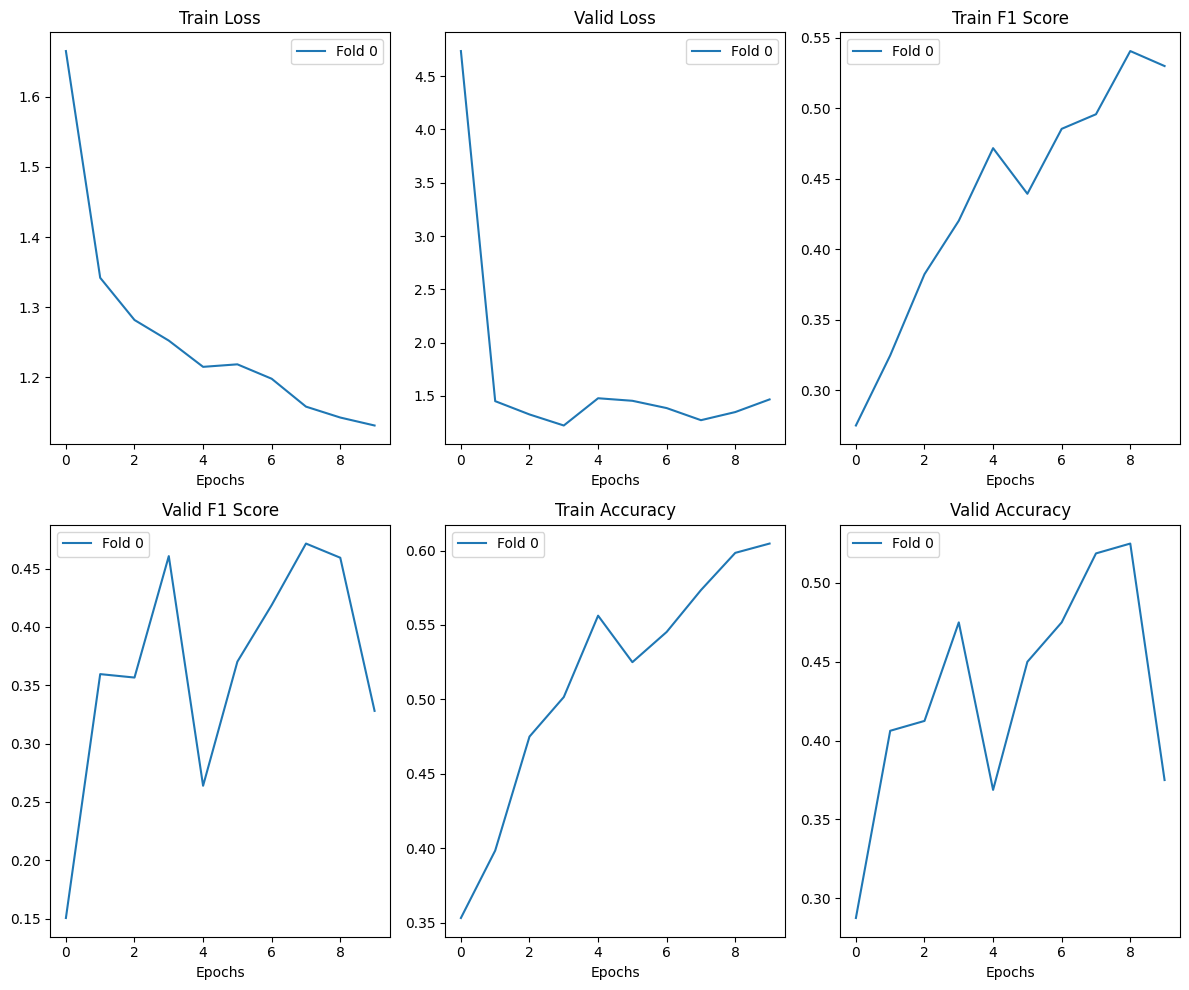

<Figure size 1200x1000 with 0 Axes>

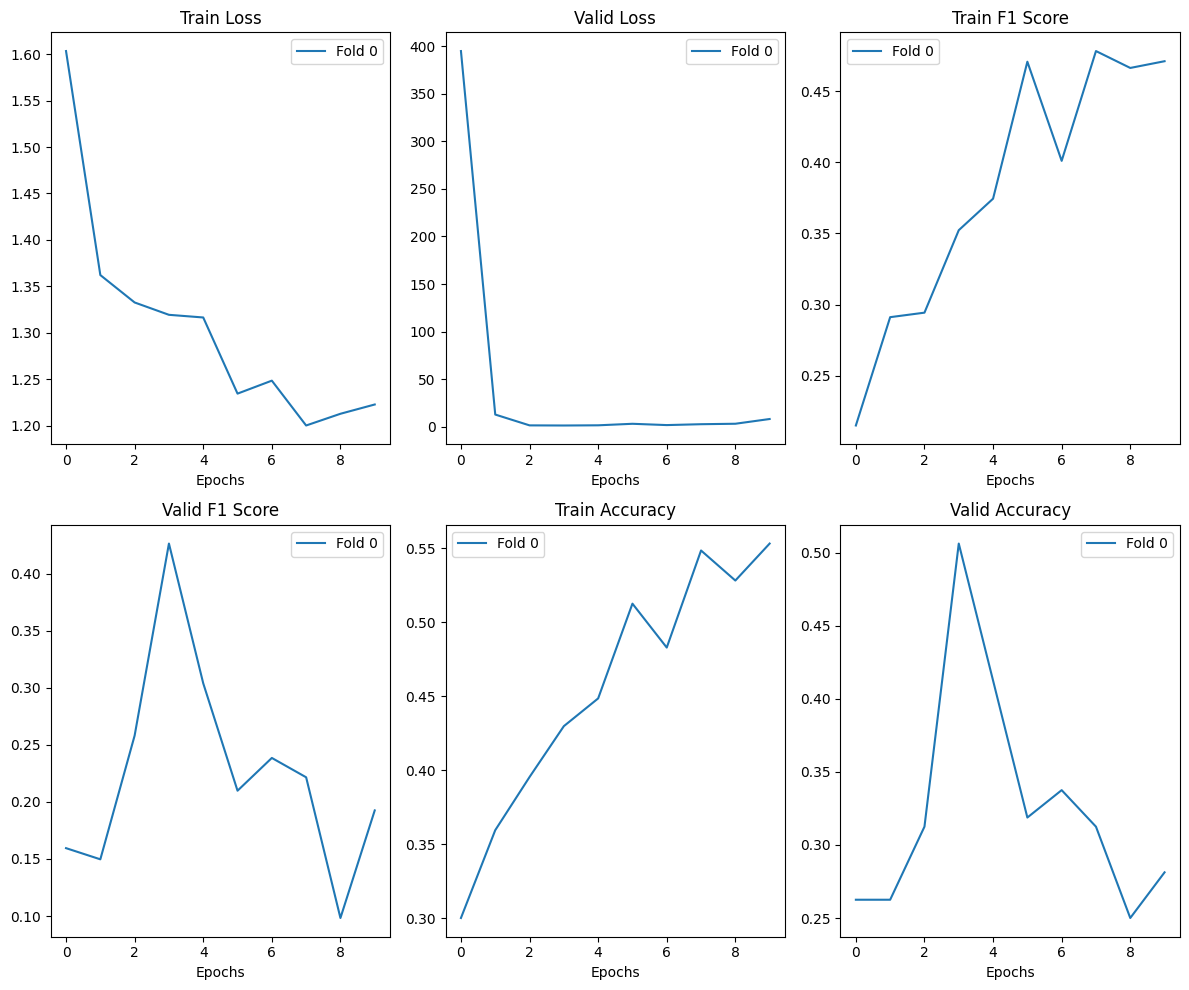

<Figure size 1200x1000 with 0 Axes>

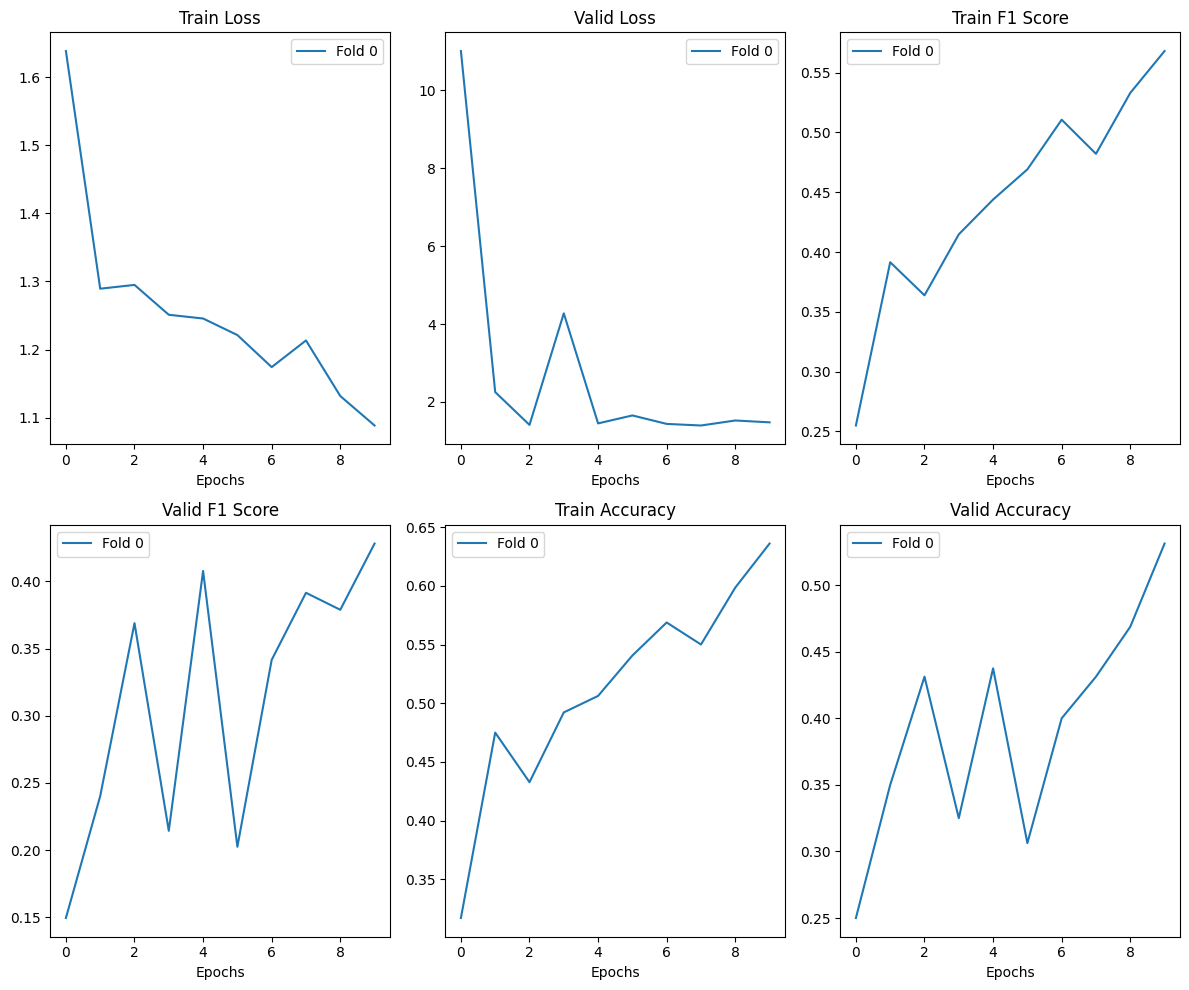

<Figure size 1200x1000 with 0 Axes>

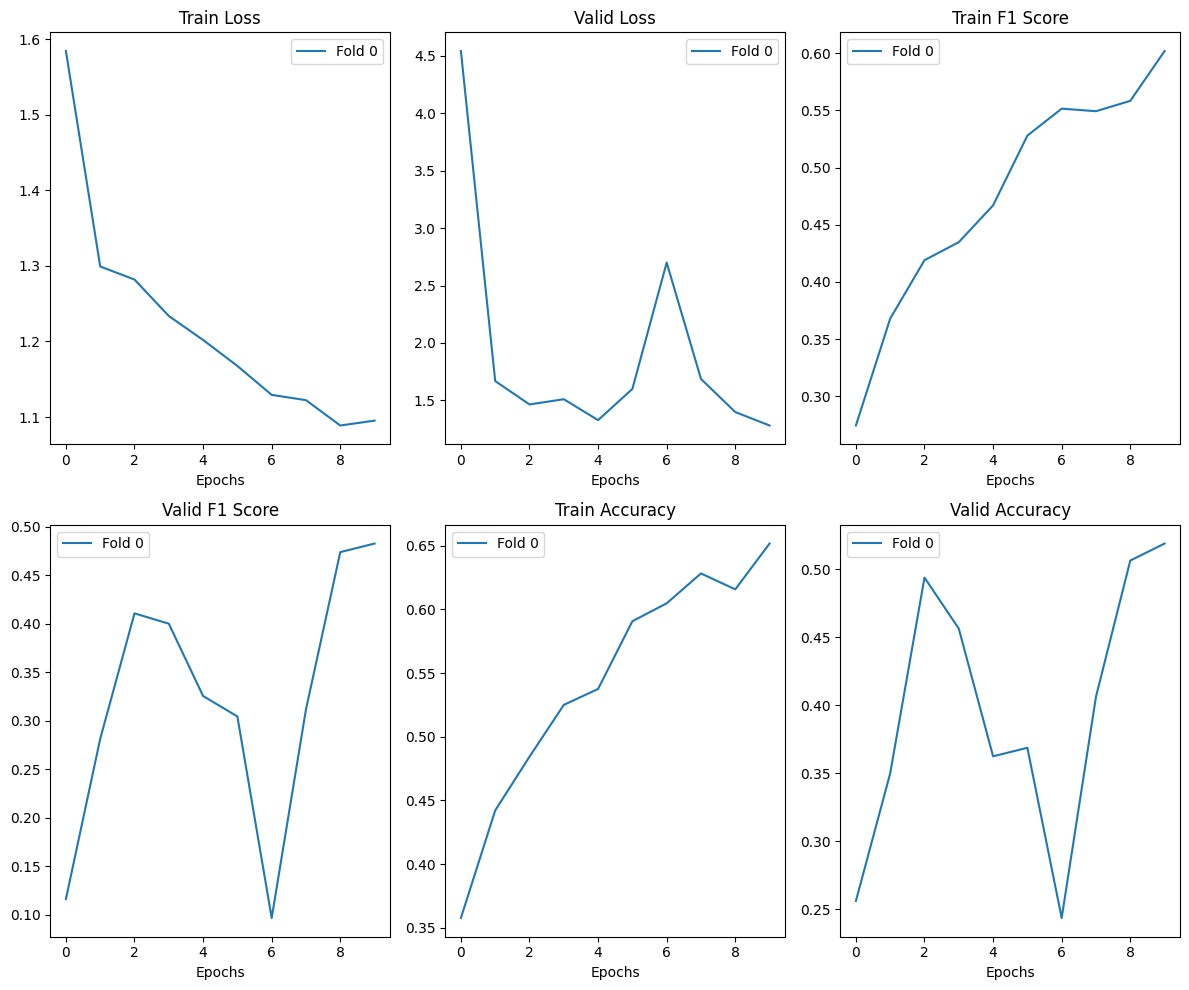

<Figure size 1200x1000 with 0 Axes>

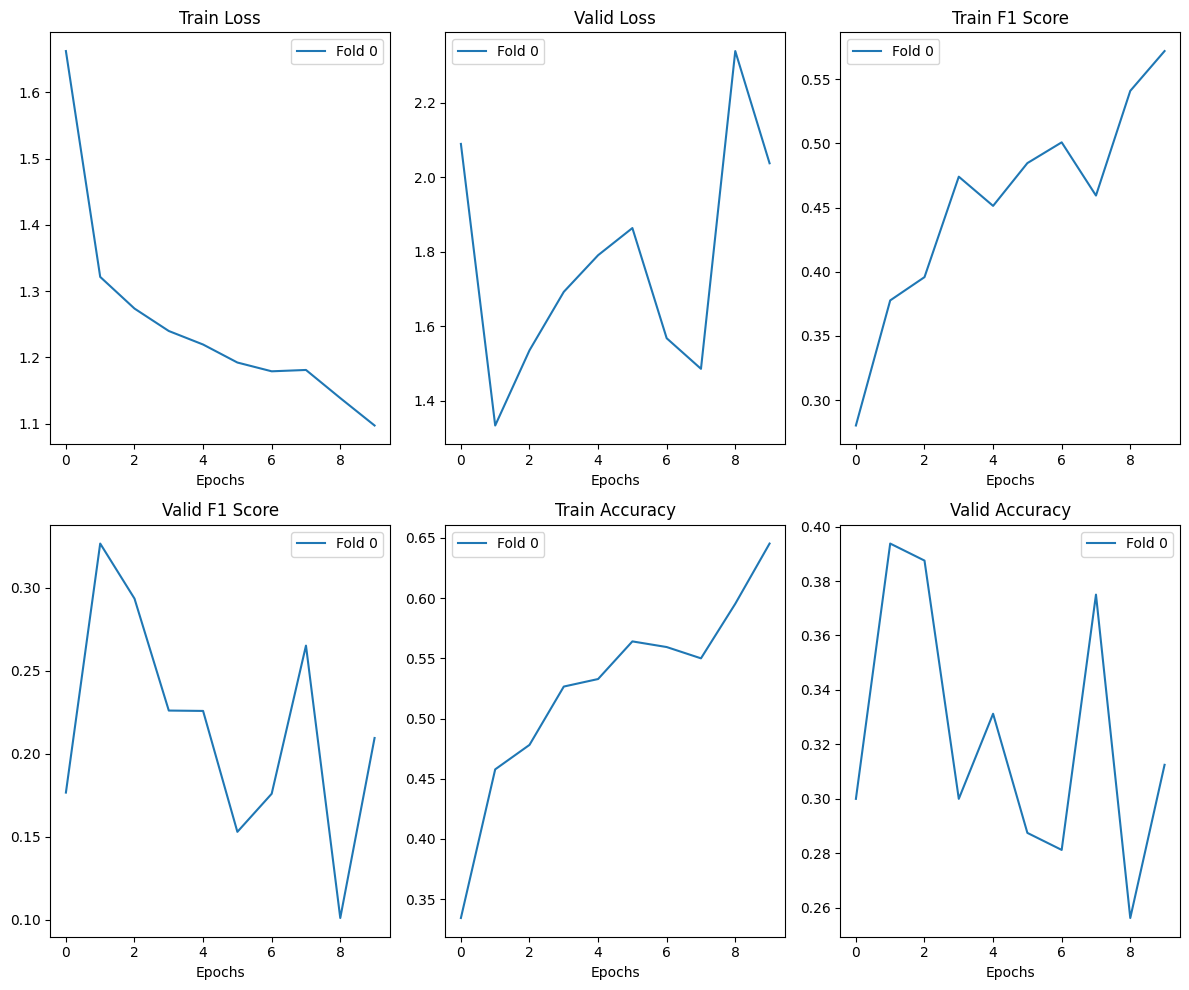

<Figure size 1200x1000 with 0 Axes>

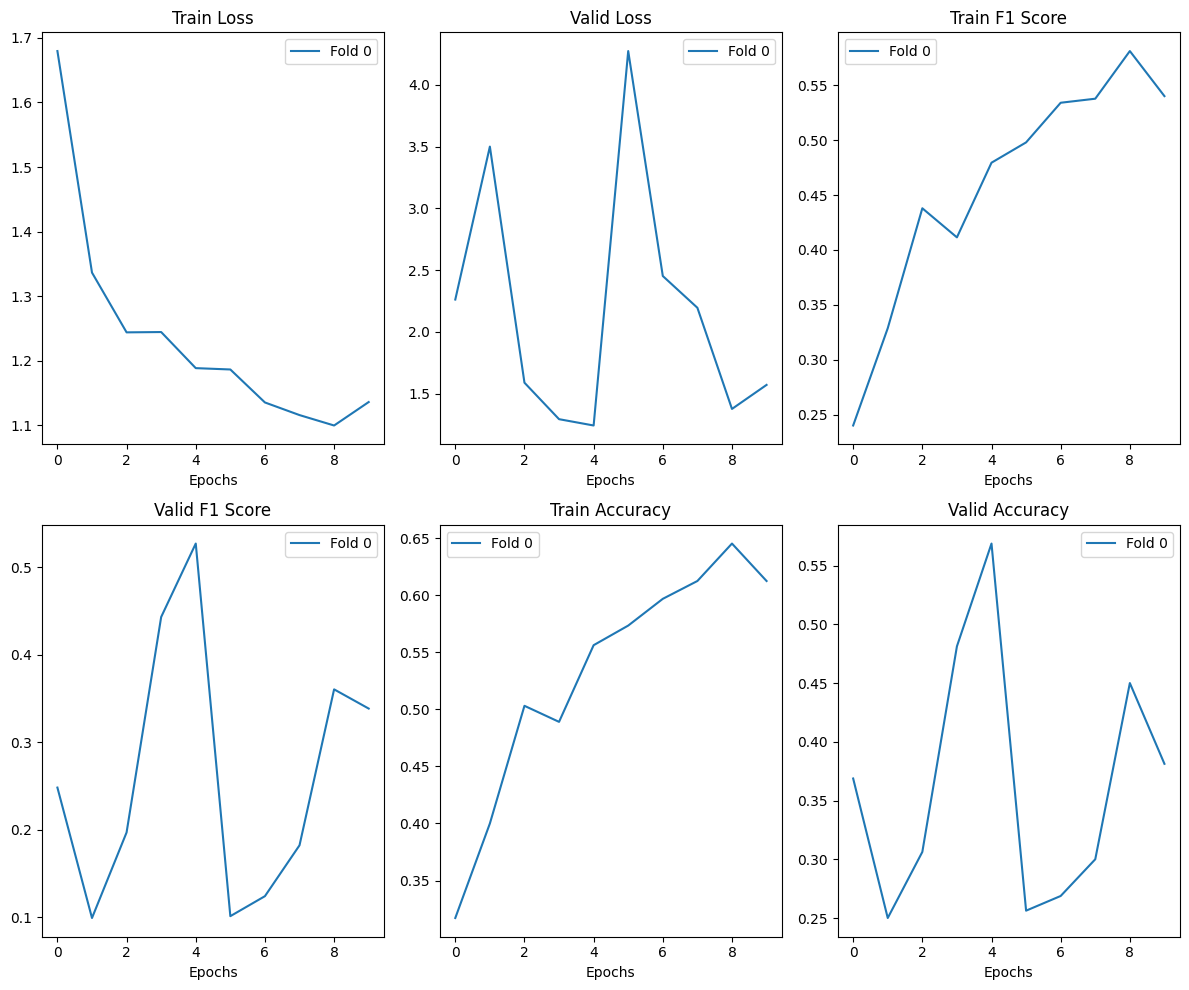

<Figure size 1200x1000 with 0 Axes>

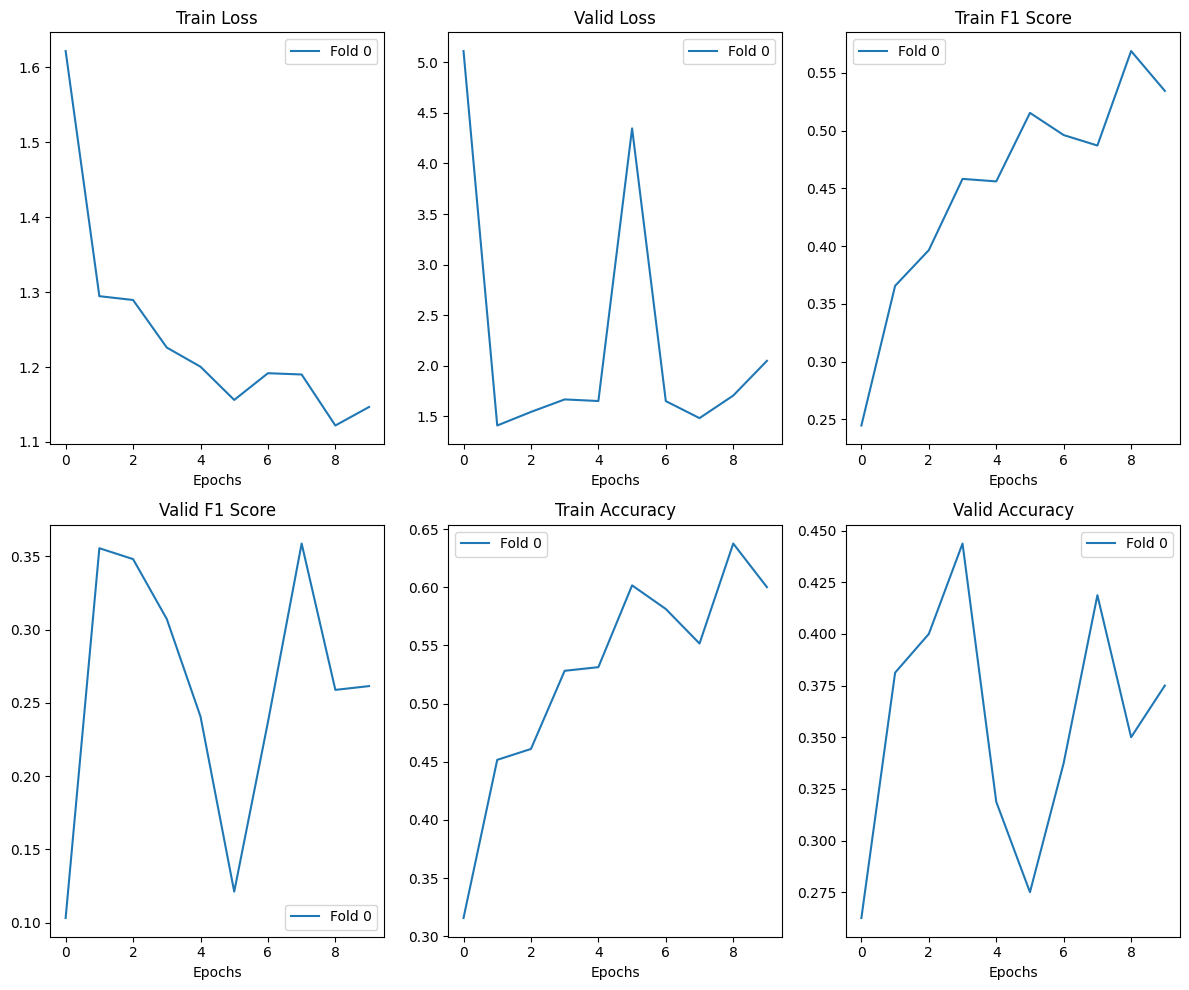

<Figure size 1200x1000 with 0 Axes>

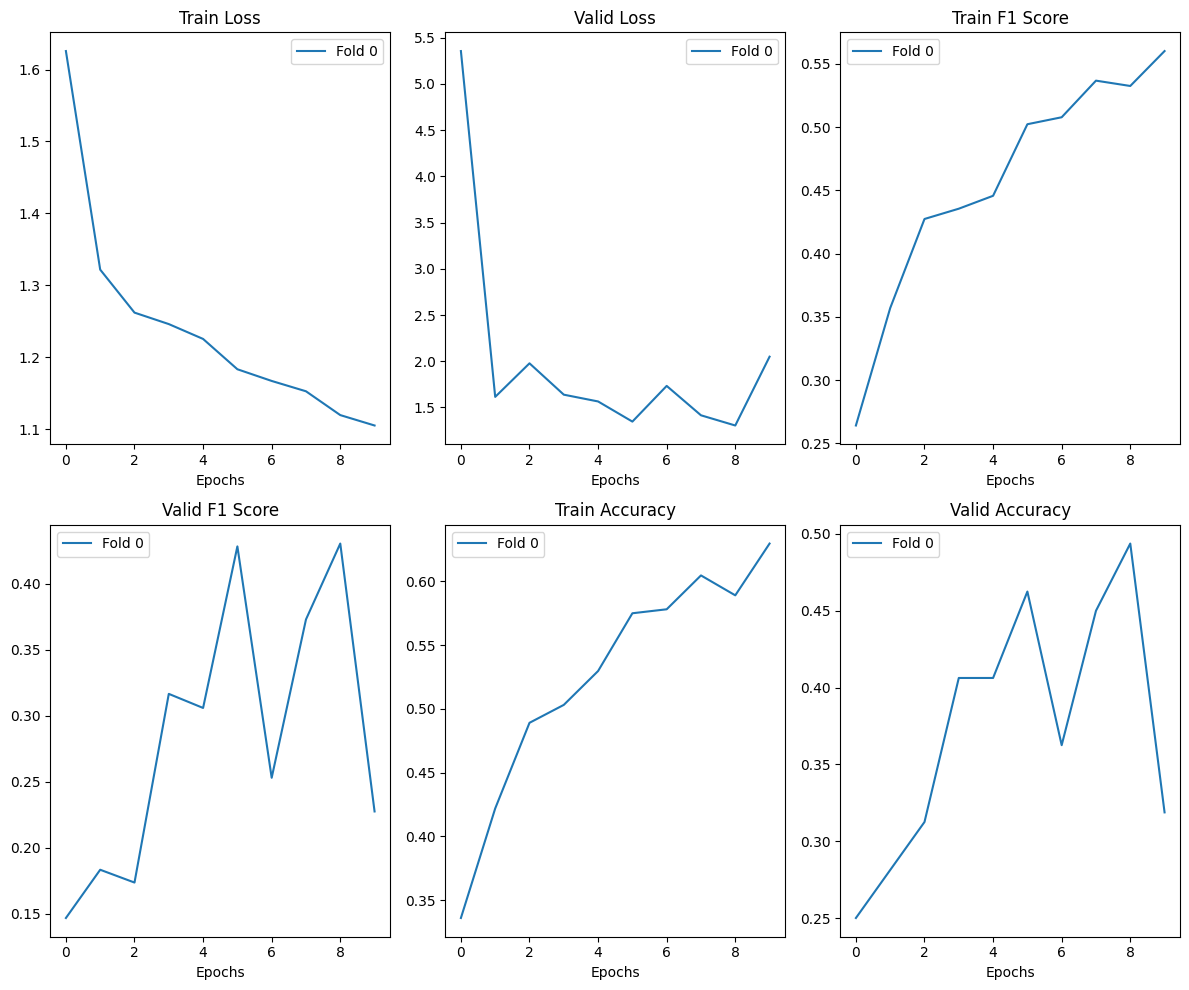

<Figure size 1200x1000 with 0 Axes>

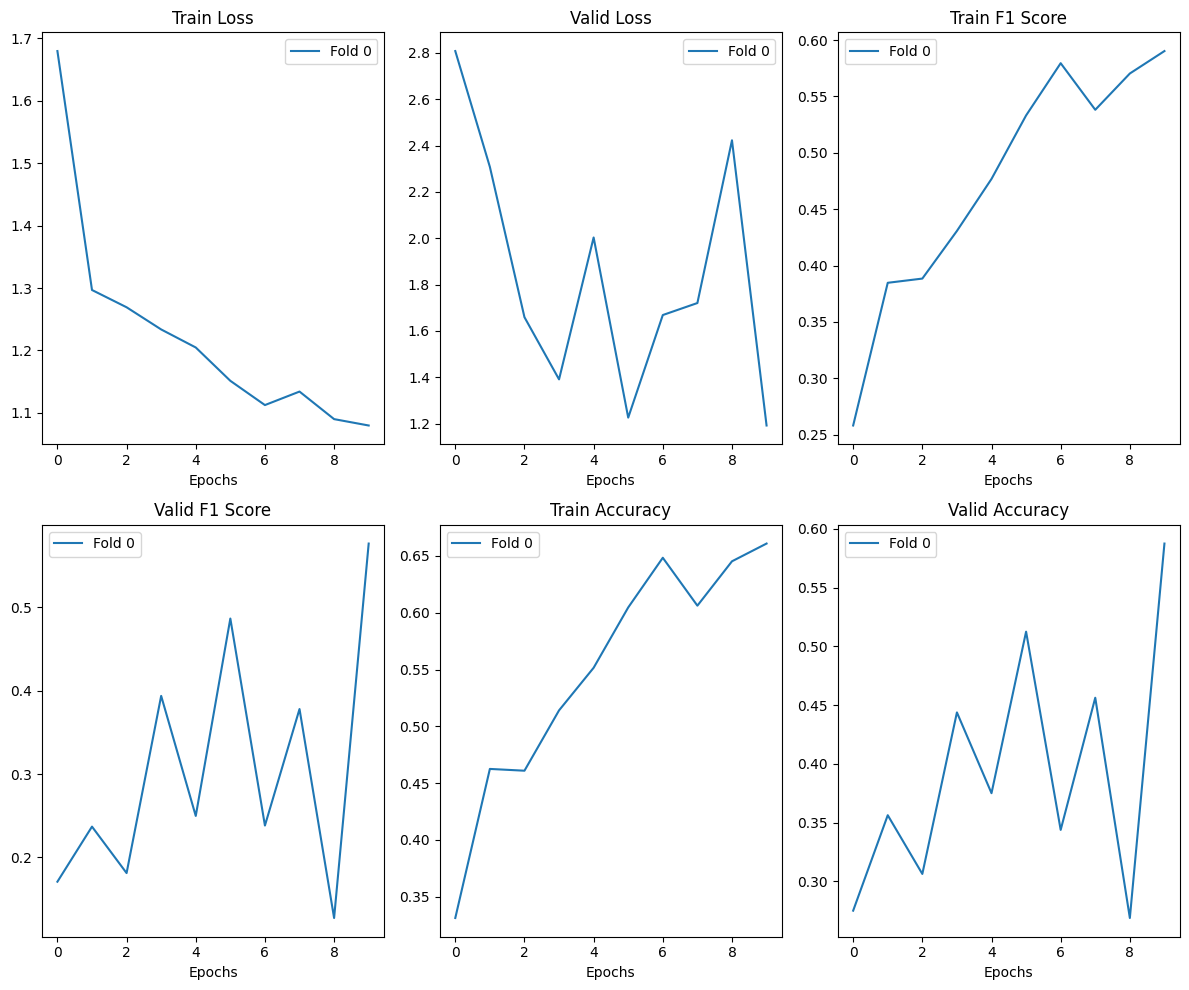

<Figure size 1200x1000 with 0 Axes>

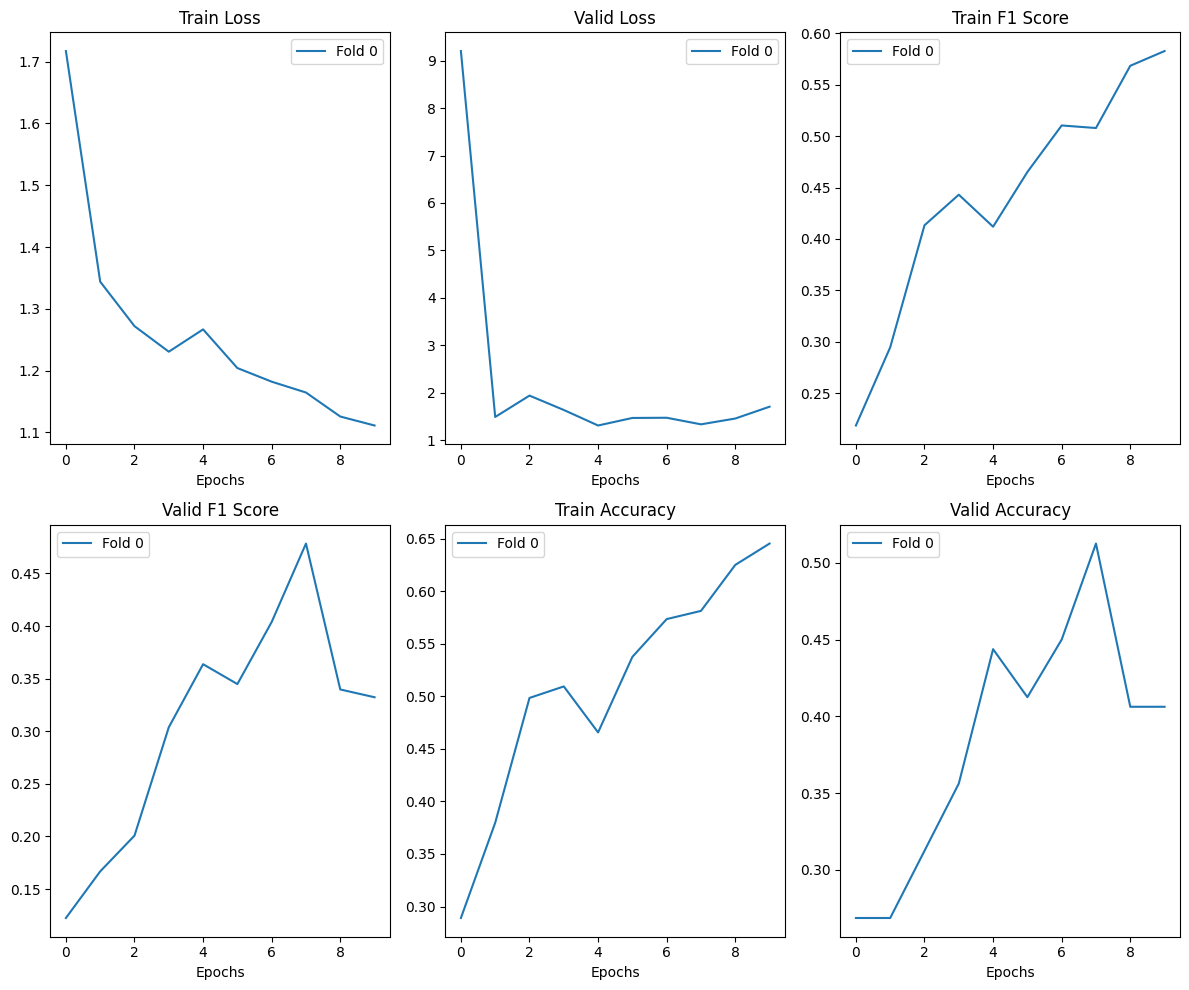

<Figure size 1200x1000 with 0 Axes>

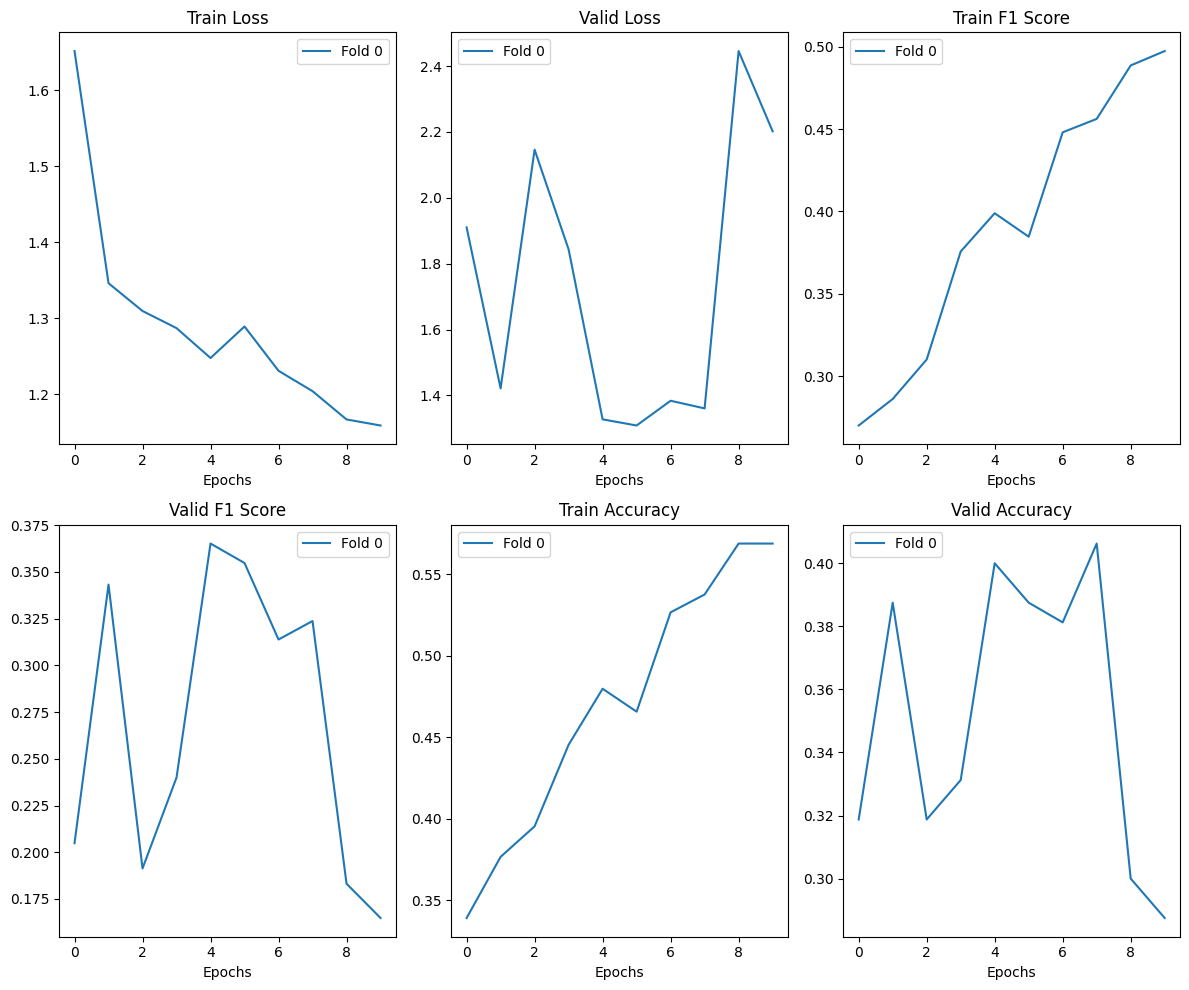

<Figure size 1200x1000 with 0 Axes>

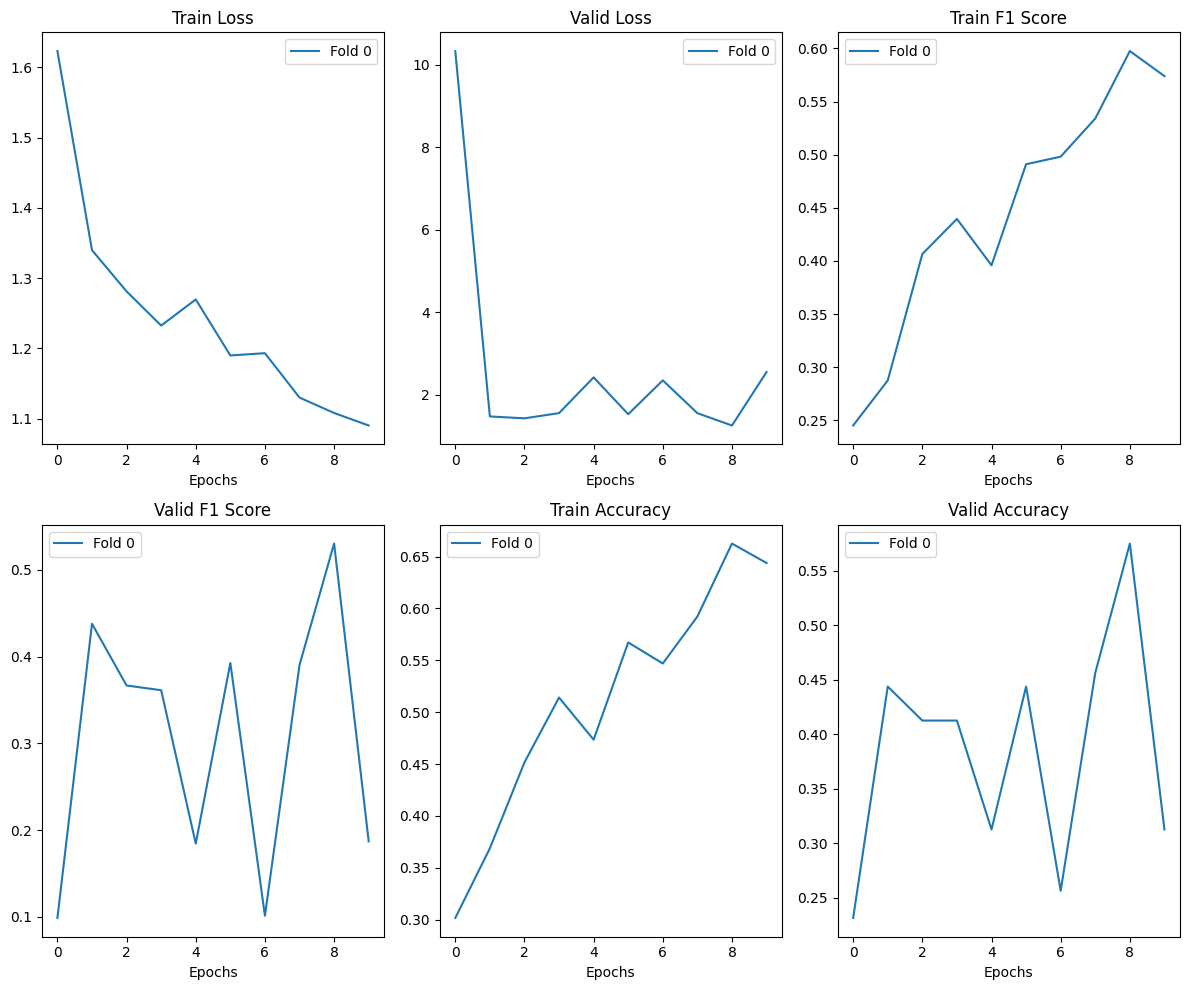

<Figure size 1200x1000 with 0 Axes>

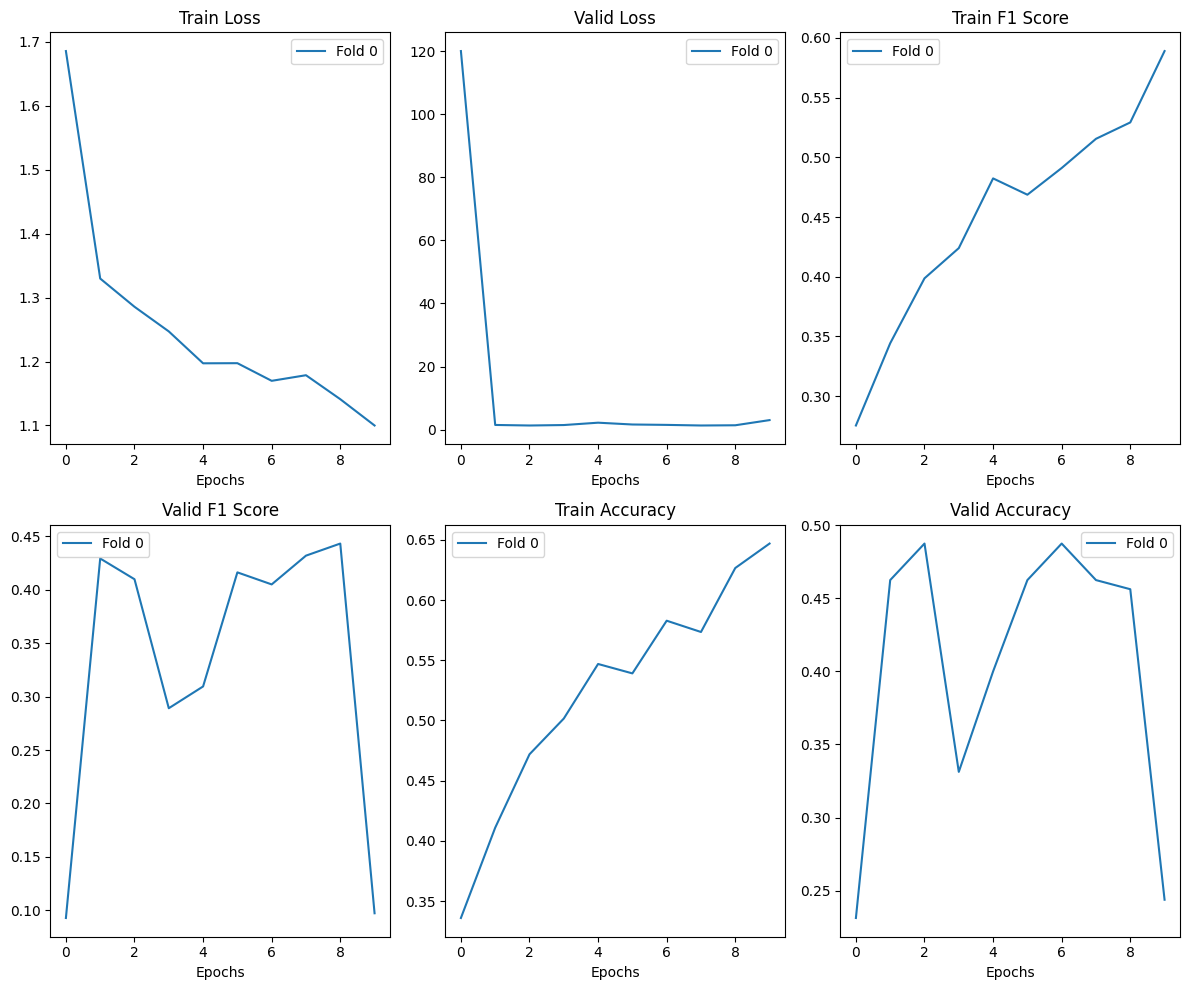

<Figure size 1200x1000 with 0 Axes>

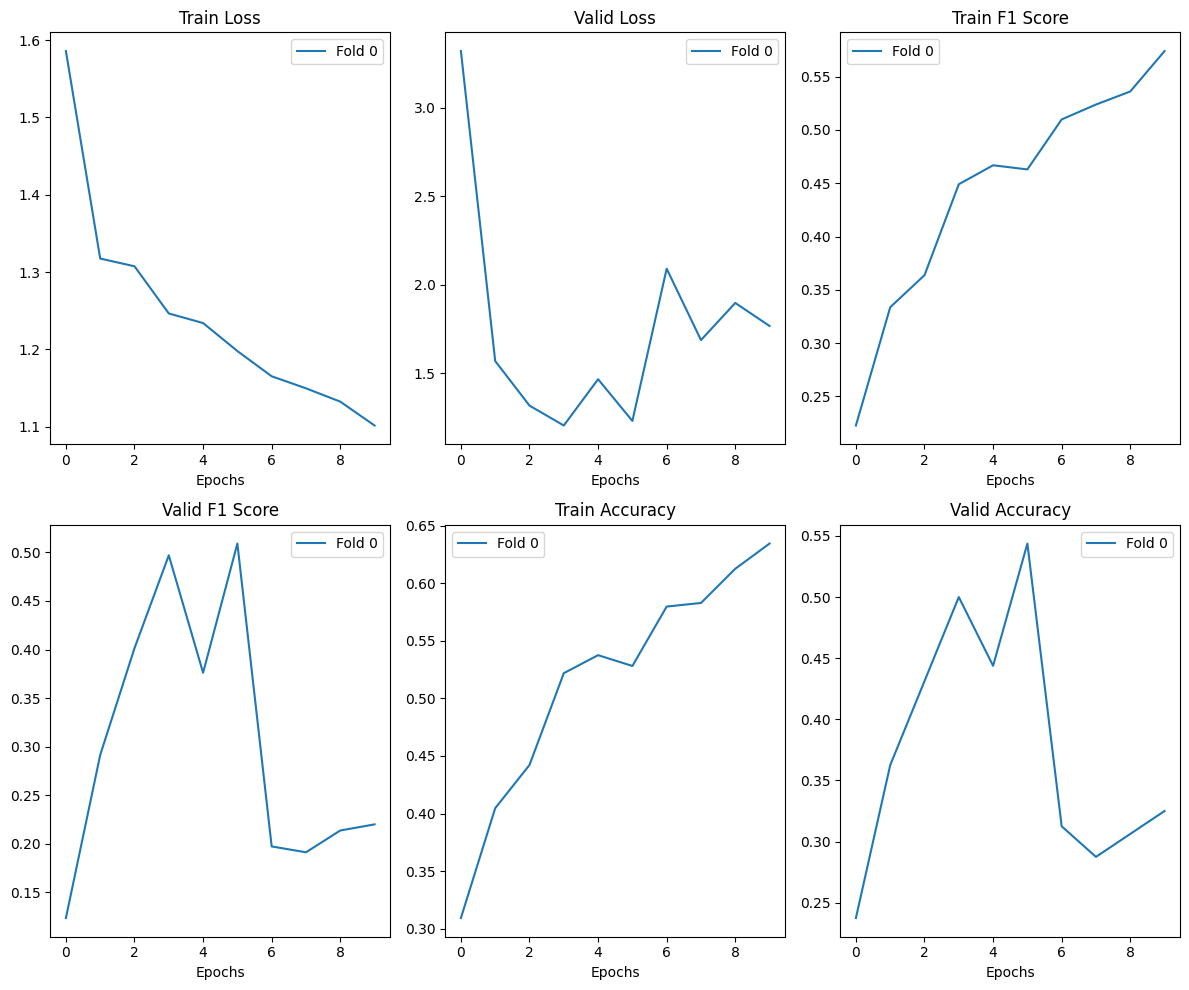

<Figure size 1200x1000 with 0 Axes>

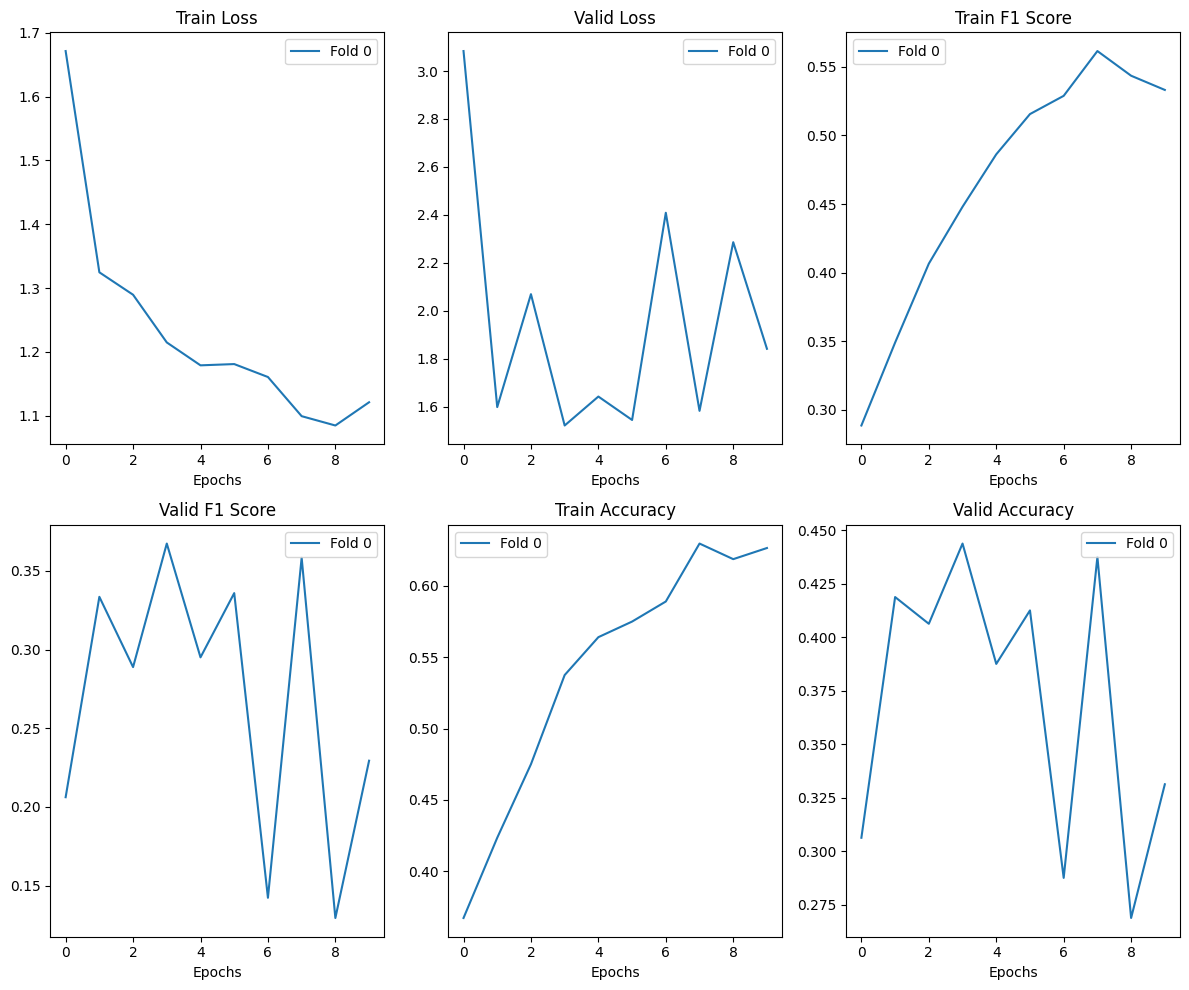

<Figure size 1200x1000 with 0 Axes>

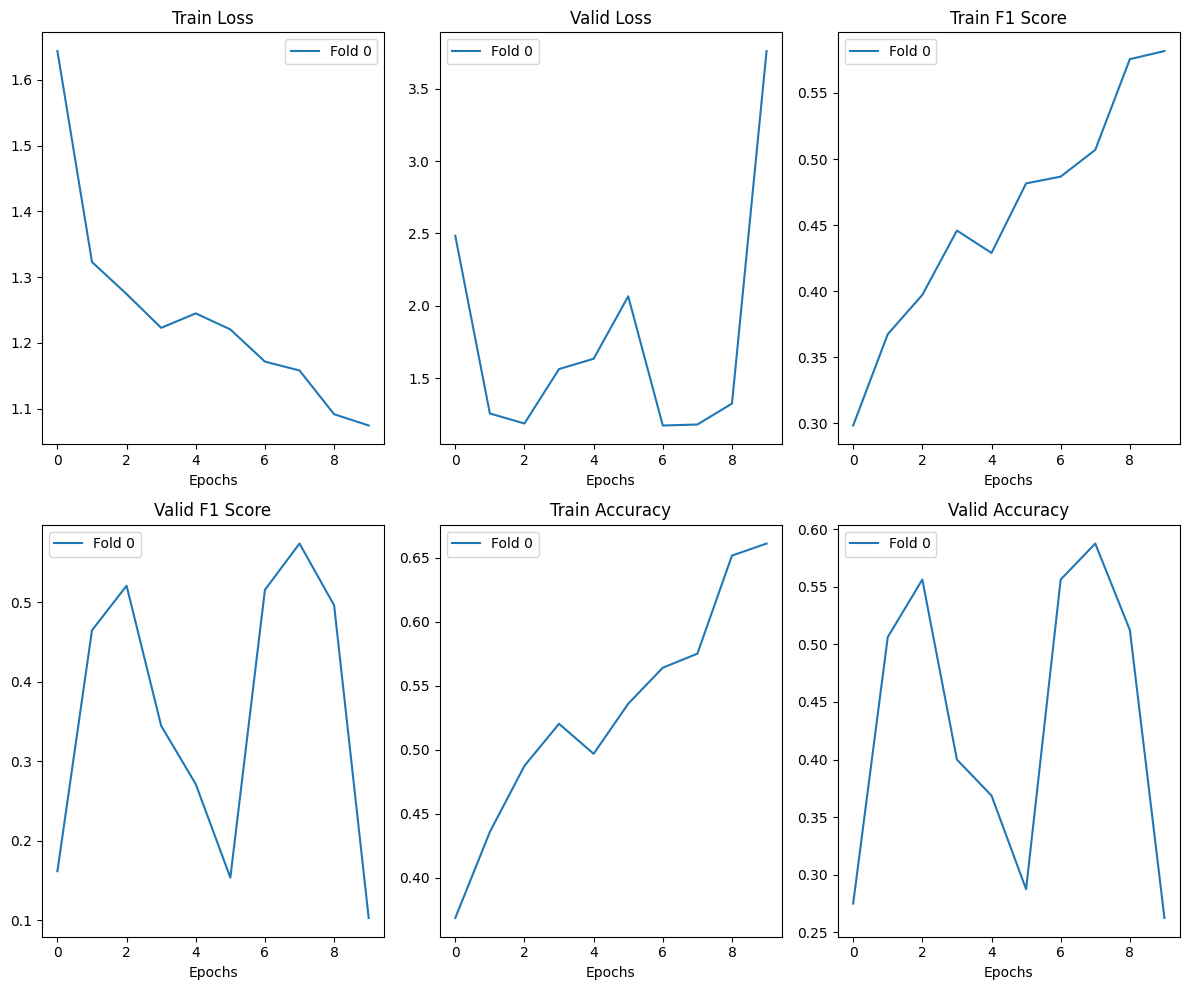

<Figure size 1200x1000 with 0 Axes>

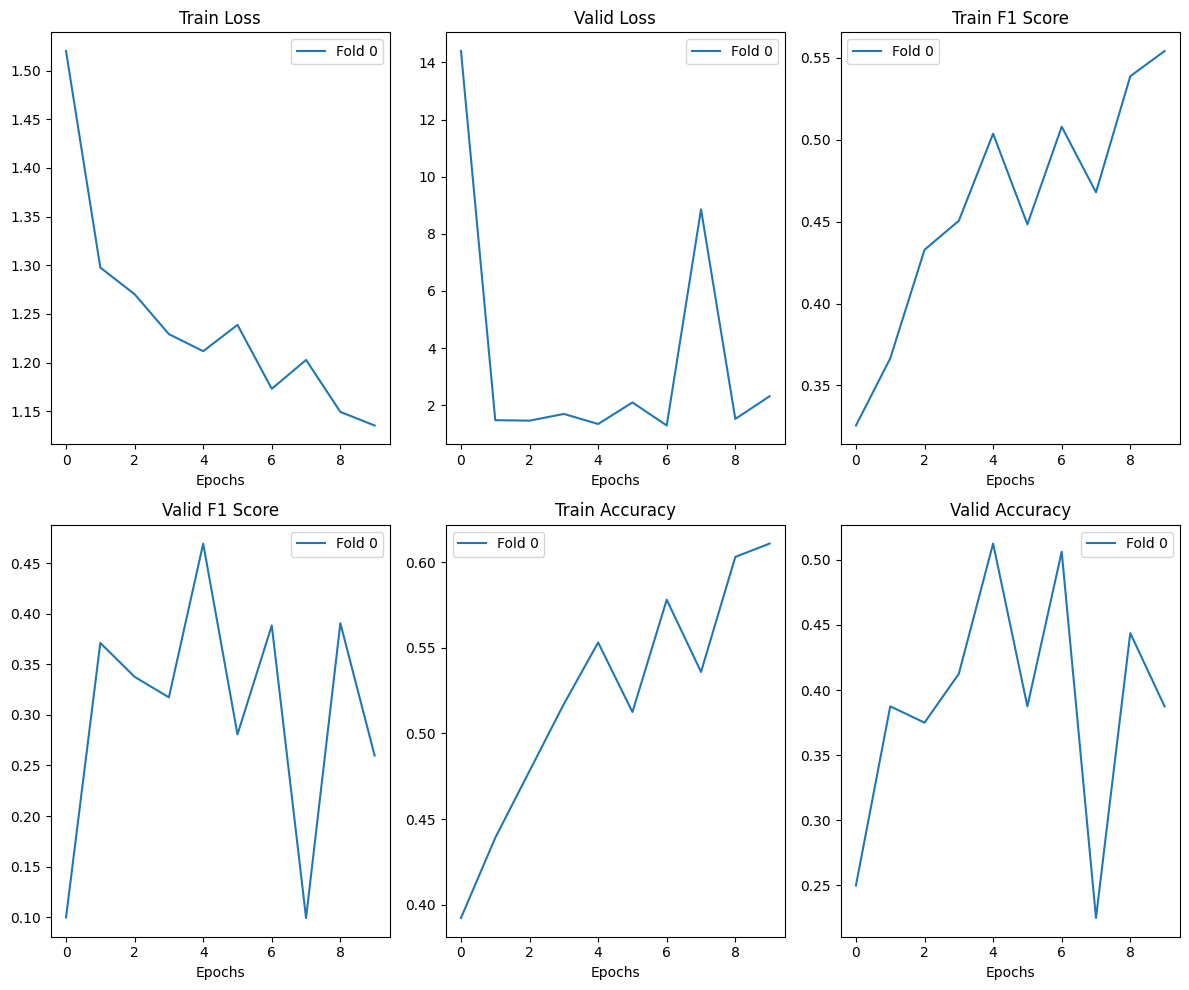

<Figure size 1200x1000 with 0 Axes>

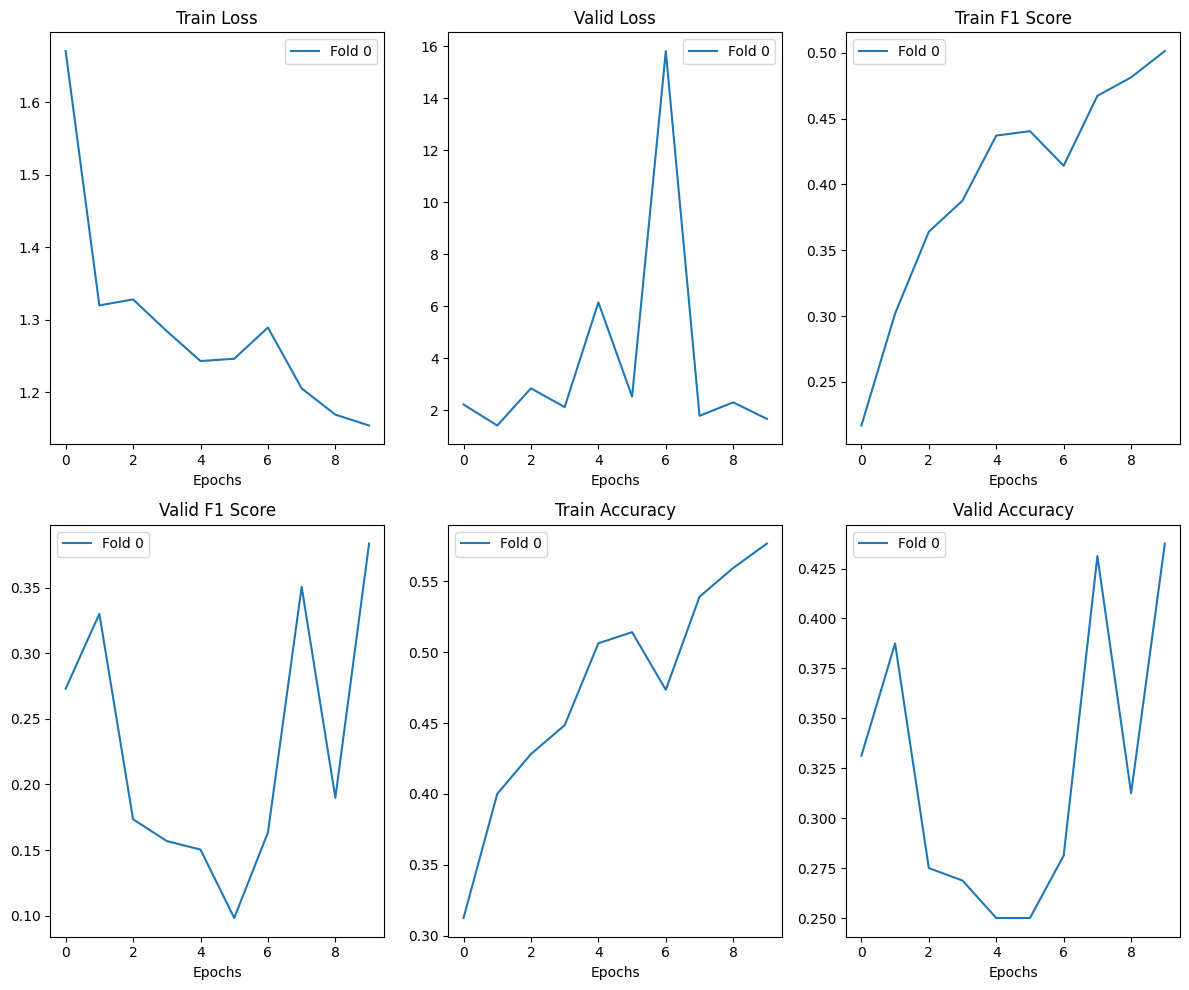

<Figure size 1200x1000 with 0 Axes>

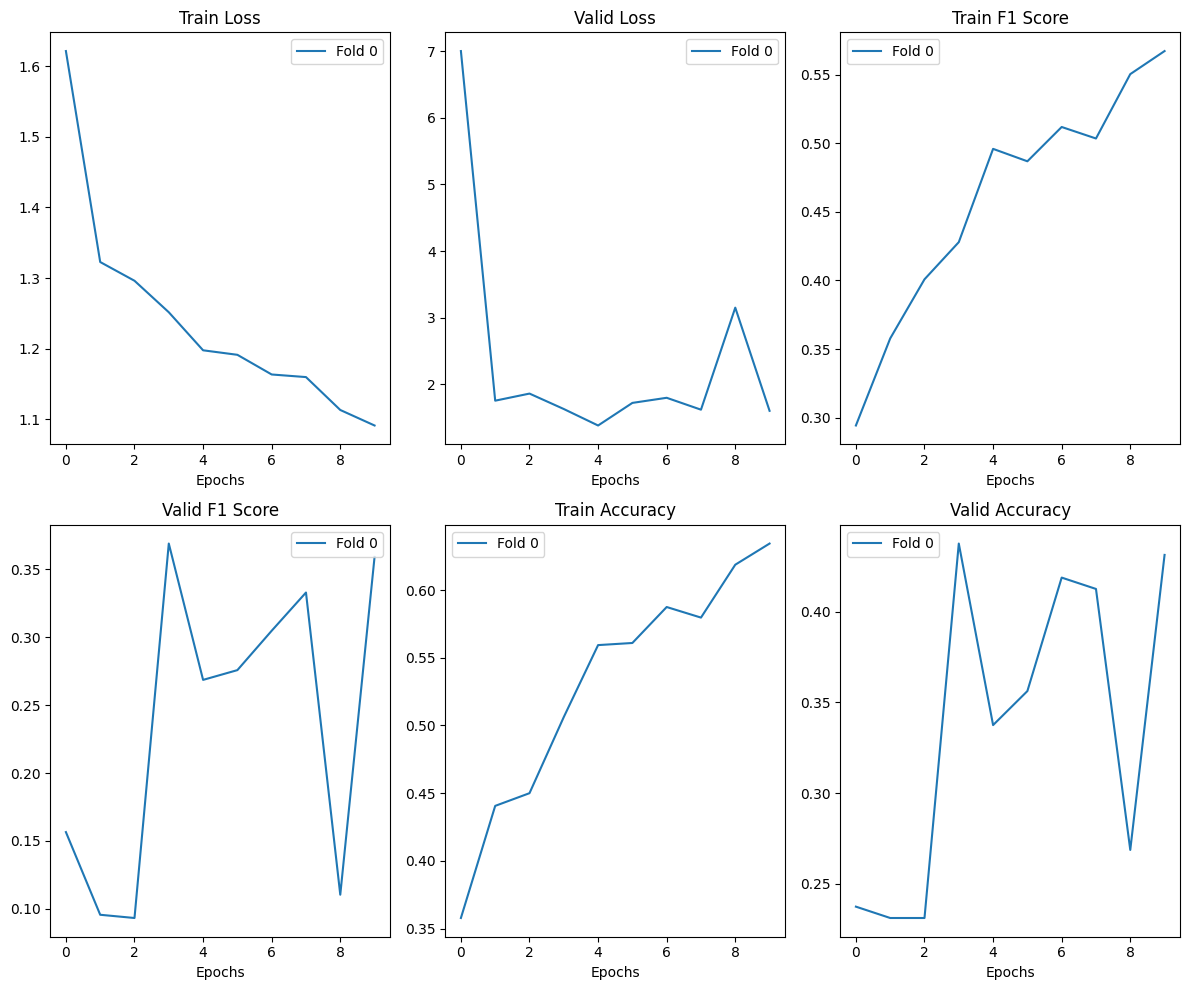

In [26]:
def plot_training_history(all_history):
    if LOAD_MODELS_FROM is None:
        plt.figure(figsize=(12,10))
        
        plt.subplot(2,3,1)
        plt.title('Train Loss')
        for fold, i in enumerate(all_history['Train Loss']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        plt.subplot(2,3,2)
        plt.title('Valid Loss')
        for fold, i in enumerate(all_history['Valid Loss']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        plt.subplot(2,3,3)
        plt.title('Train F1 Score')
        for fold, i in enumerate(all_history['Train F1']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        
        plt.subplot(2,3,4)
        plt.title('Valid F1 Score')
        for fold, i in enumerate(all_history['Valid F1']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        plt.subplot(2,3,5)
        plt.title('Train Accuracy')
        for fold, i in enumerate(all_history['Train Accuracy']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        plt.subplot(2,3,6)
        plt.title('Valid Accuracy')
        for fold, i in enumerate(all_history['Valid Accuracy']):
            plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# 각 실험 결과에 대해 학습 히스토리 플롯
for result in results:
    clip_limit = result['clip_limit']
    tile_grid_size = result['tile_grid_size']
    plt.figure(figsize=(12,10))
    plt.suptitle(f'Training History (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    plot_training_history(result['all_history'])
    plt.show()

In [27]:
# 결과 분석
results_df = pd.DataFrame([(r['clip_limit'], r['tile_grid_size'], r['accuracy'], r['f1_score']) for r in results],
                          columns=['clip_limit', 'tile_grid_size', 'accuracy', 'f1_score'])
print(results_df)

# 최고의 성능을 보인 설정 찾기
best_result = results_df.loc[results_df['f1_score'].idxmax()]
print("Best CLAHE settings:")
print(f"Clip Limit: {best_result['clip_limit']}")
print(f"Tile Grid Size: {best_result['tile_grid_size']}")
print(f"F1 Score: {best_result['f1_score']}")
print(f"Accuracy: {best_result['accuracy']}")

    clip_limit tile_grid_size  accuracy  f1_score
0          1.0         (2, 2)  0.381250  0.340050
1          1.0         (4, 4)  0.418750  0.398631
2          1.0         (8, 8)  0.443750  0.424284
3          2.0         (2, 2)  0.393750  0.380733
4          2.0         (4, 4)  0.509375  0.480891
5          2.0         (8, 8)  0.496875  0.486566
6          0.0         (2, 2)  0.371875  0.369769
7          0.0         (4, 4)  0.375000  0.344199
8          0.0         (8, 8)  0.412500  0.364317
9          3.0         (2, 2)  0.303125  0.227795
10         3.0         (4, 4)  0.462500  0.459916
11         3.0         (8, 8)  0.384375  0.335411
12         0.0         (2, 2)  0.293750  0.225768
13         0.0         (4, 4)  0.365625  0.278859
14         0.0         (8, 8)  0.262500  0.183946
15         4.0         (2, 2)  0.362500  0.284561
16         4.0         (4, 4)  0.350000  0.320906
17         4.0         (8, 8)  0.265625  0.196772
18         0.0         (2, 2)  0.412500  0.383605


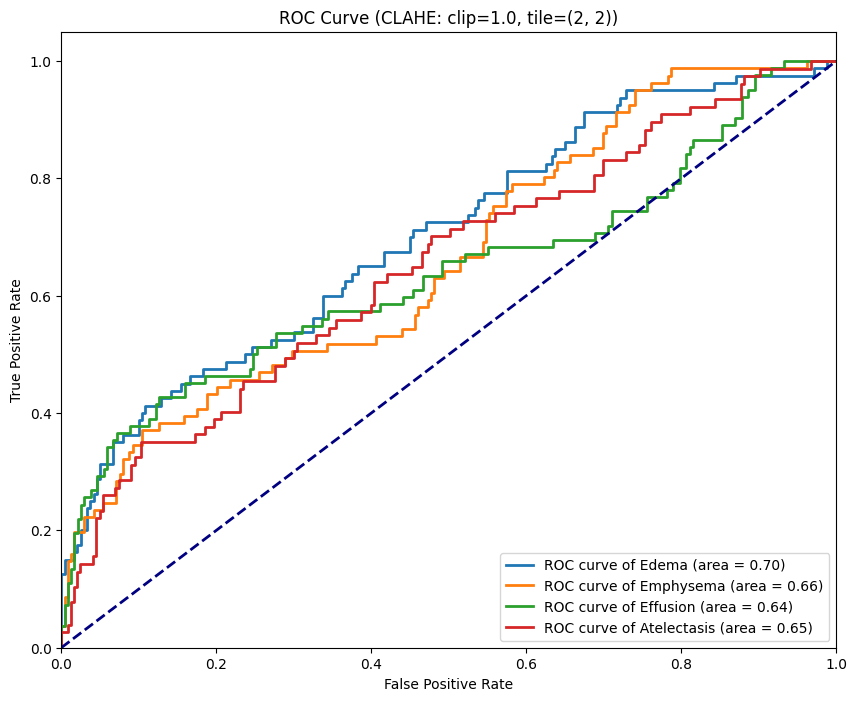

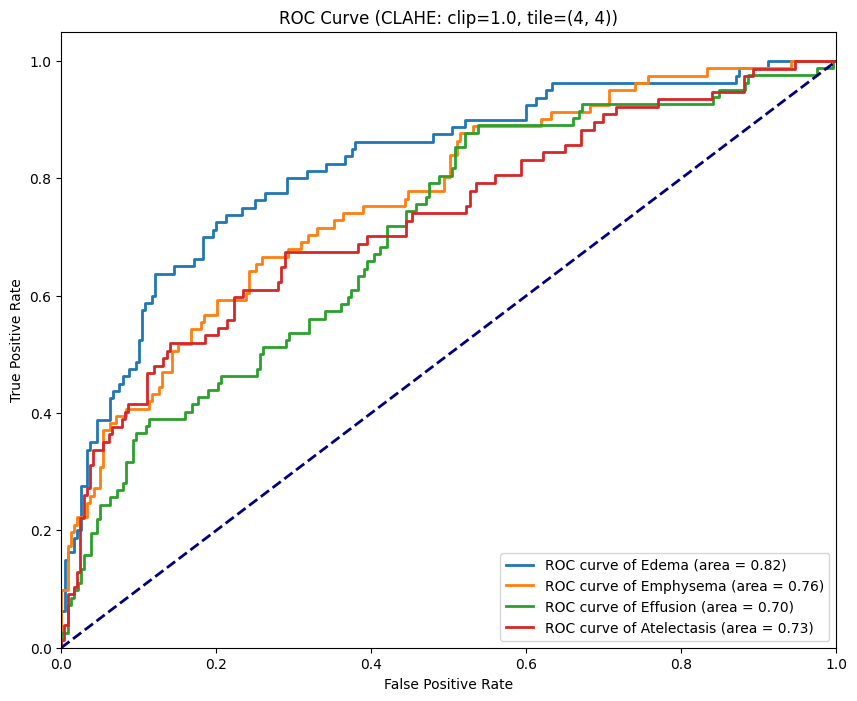

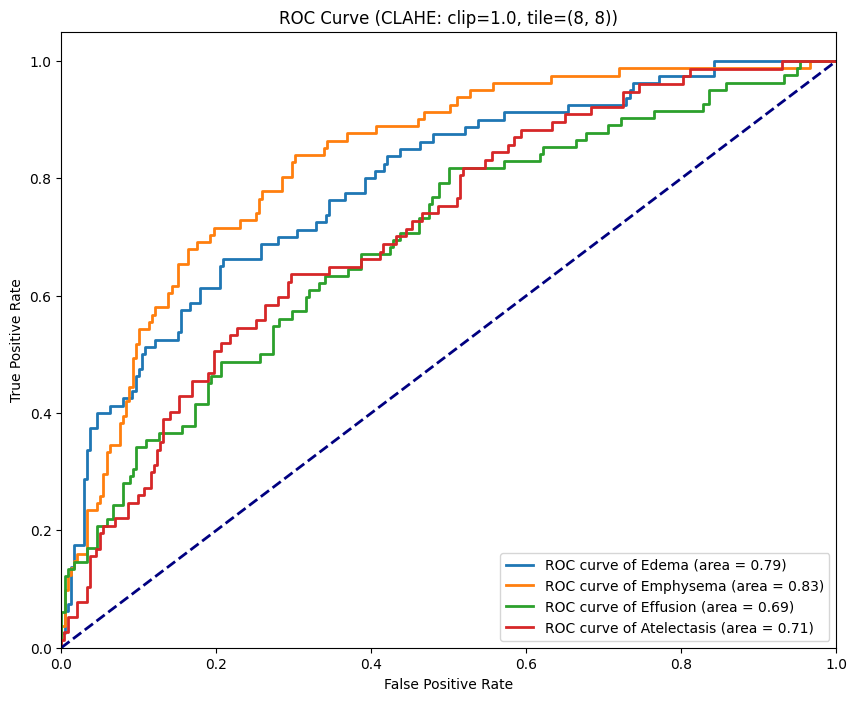

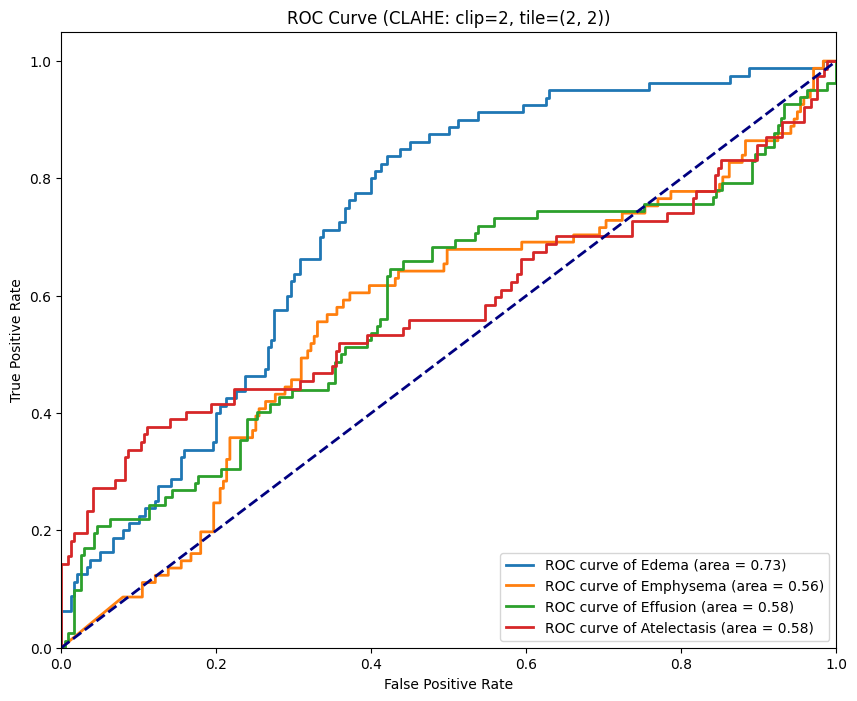

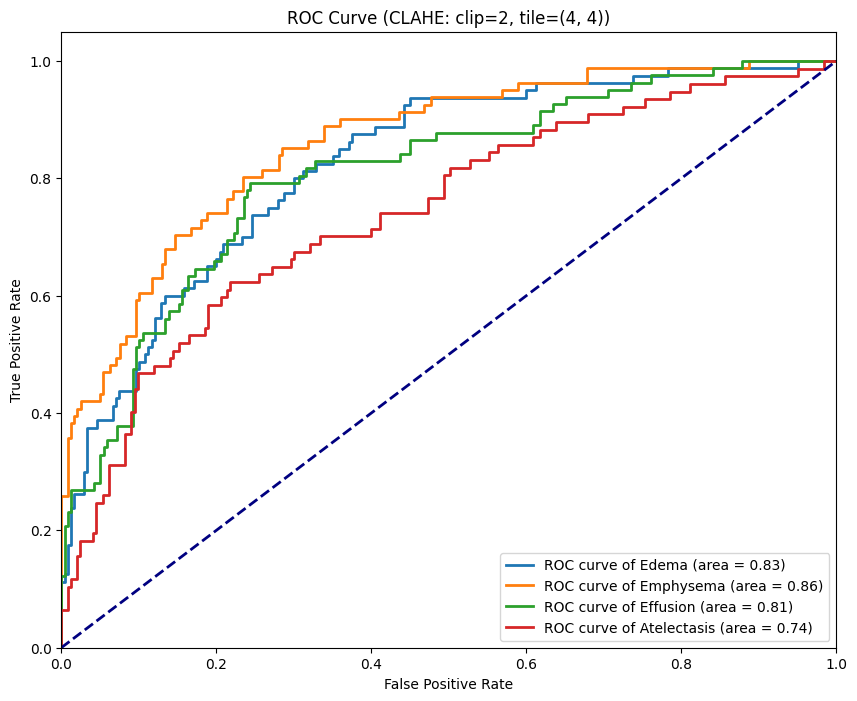

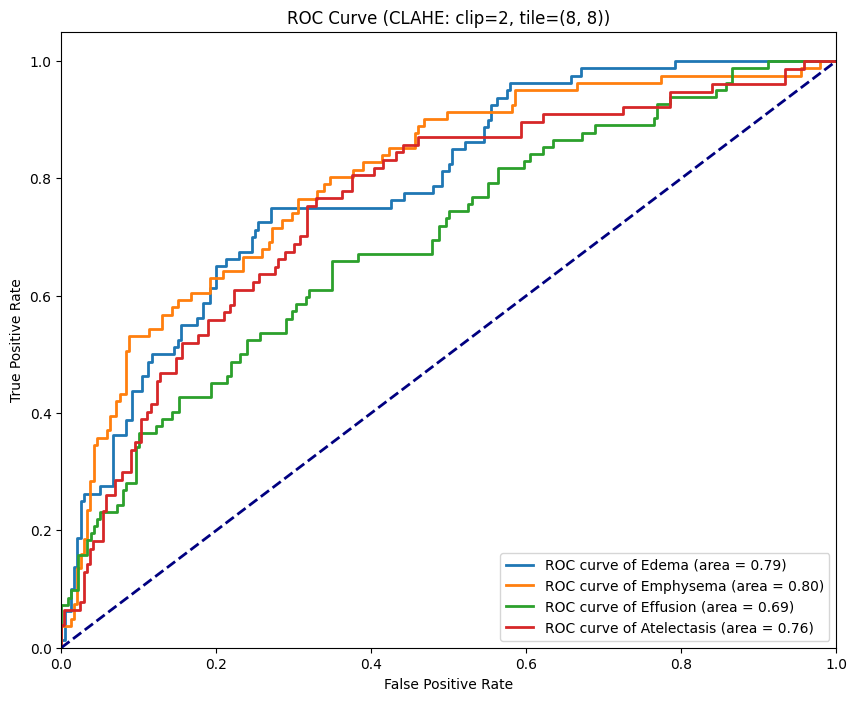

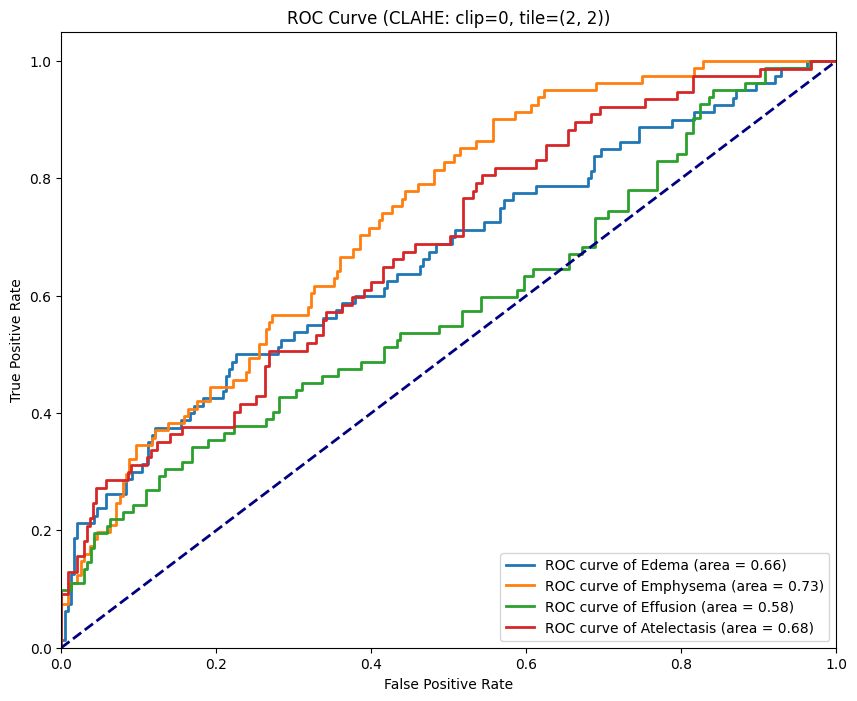

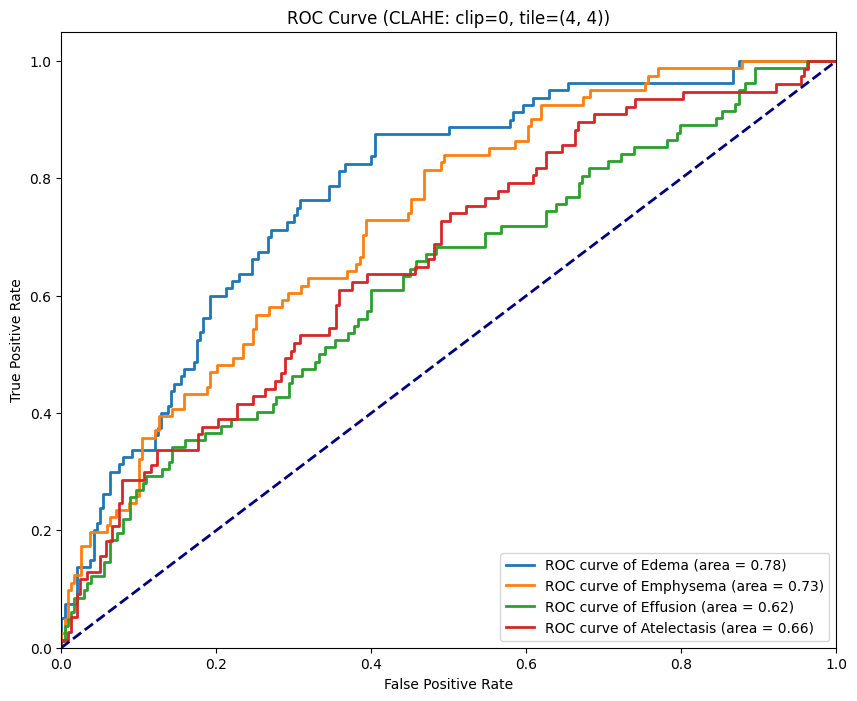

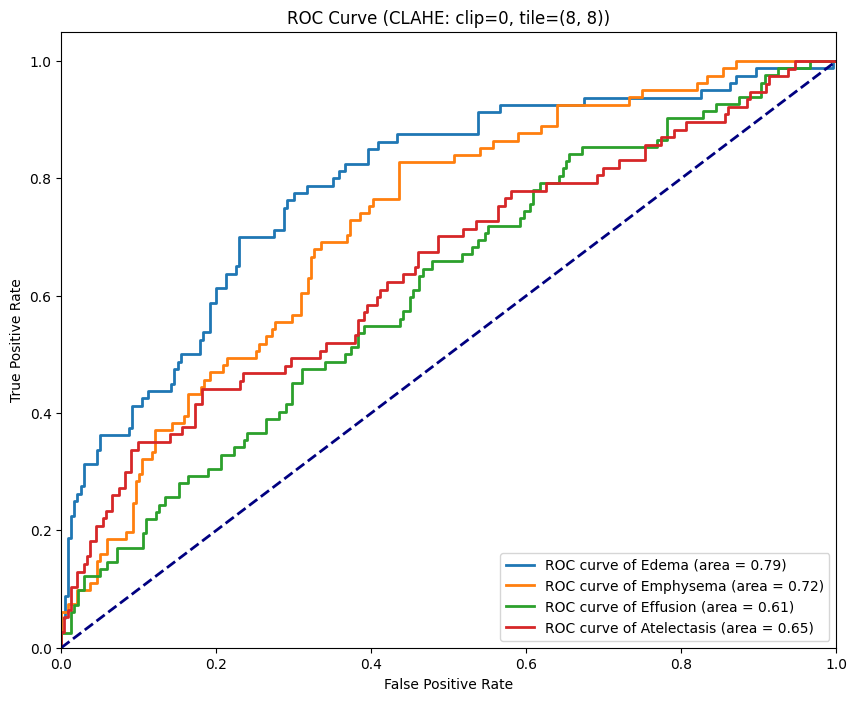

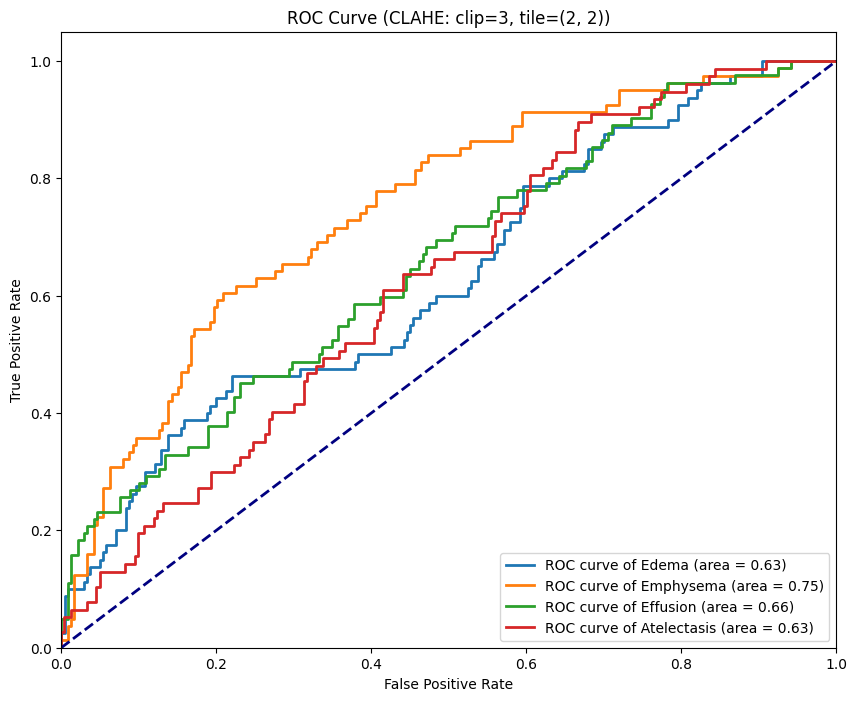

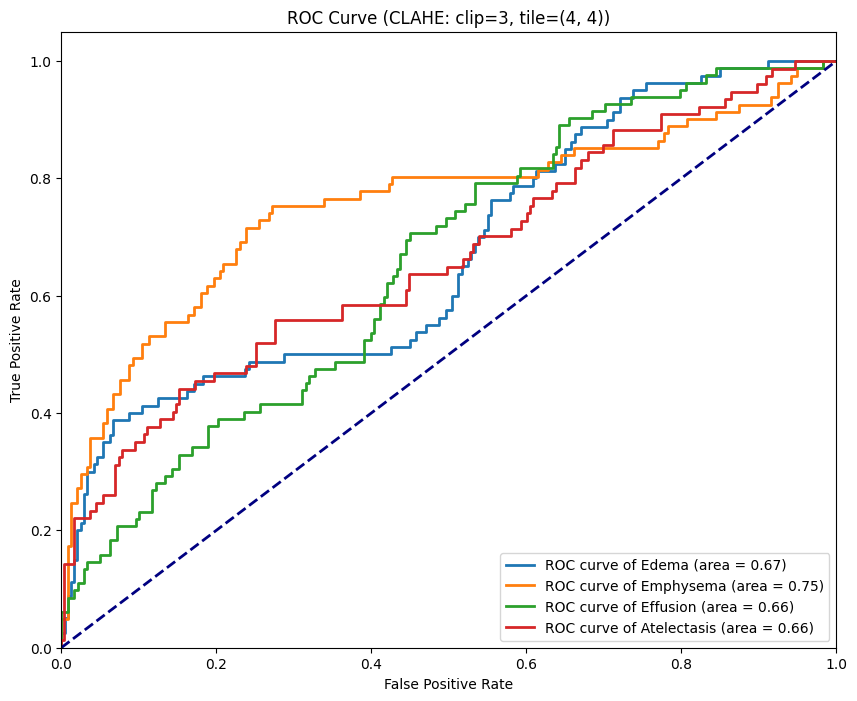

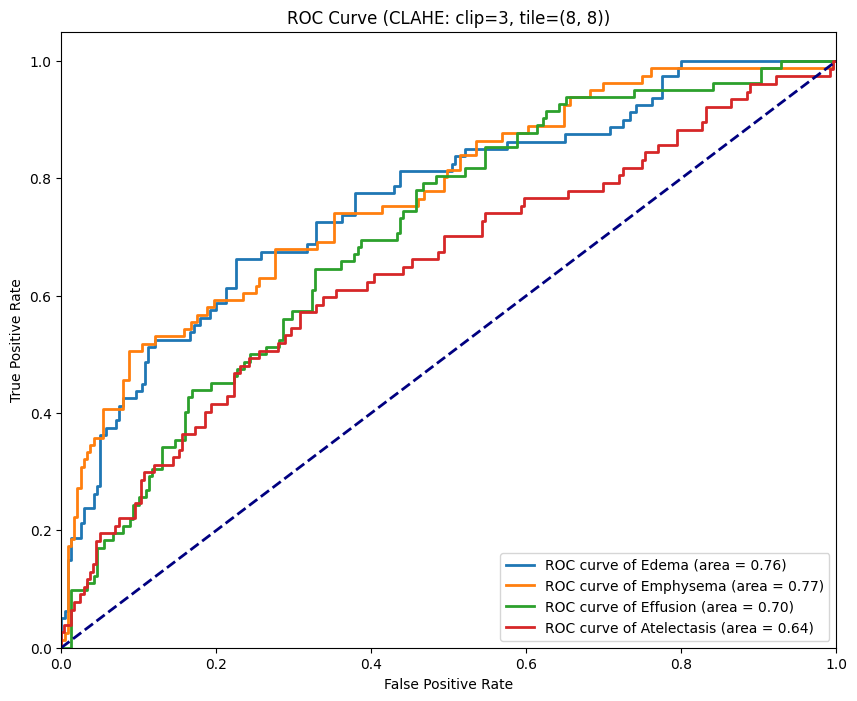

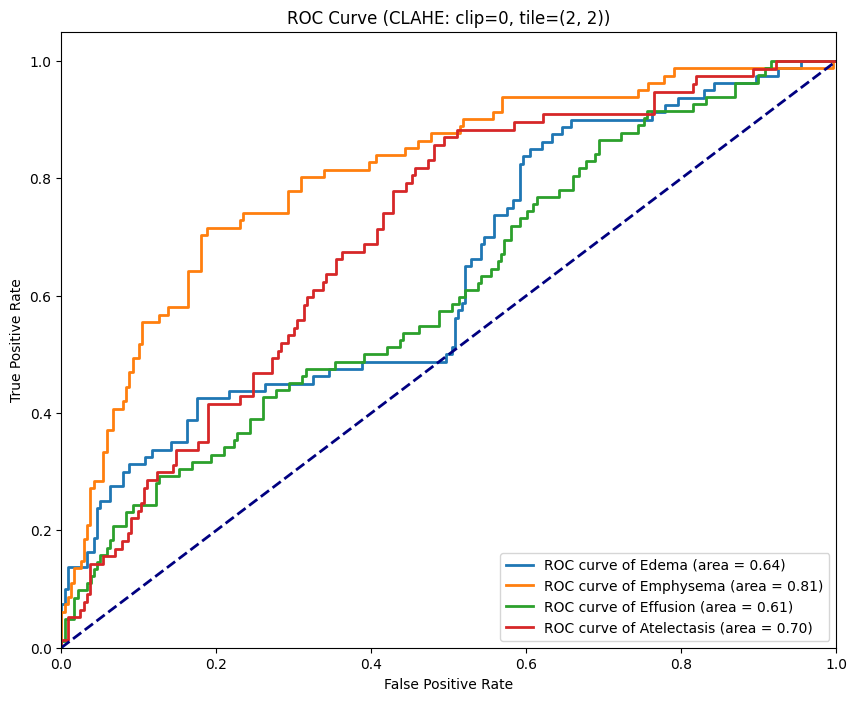

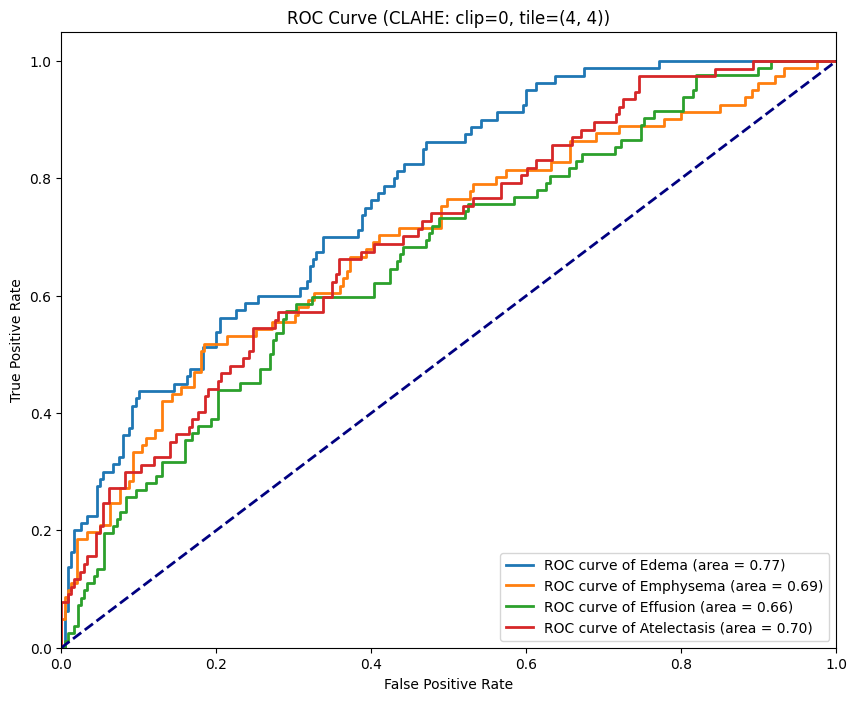

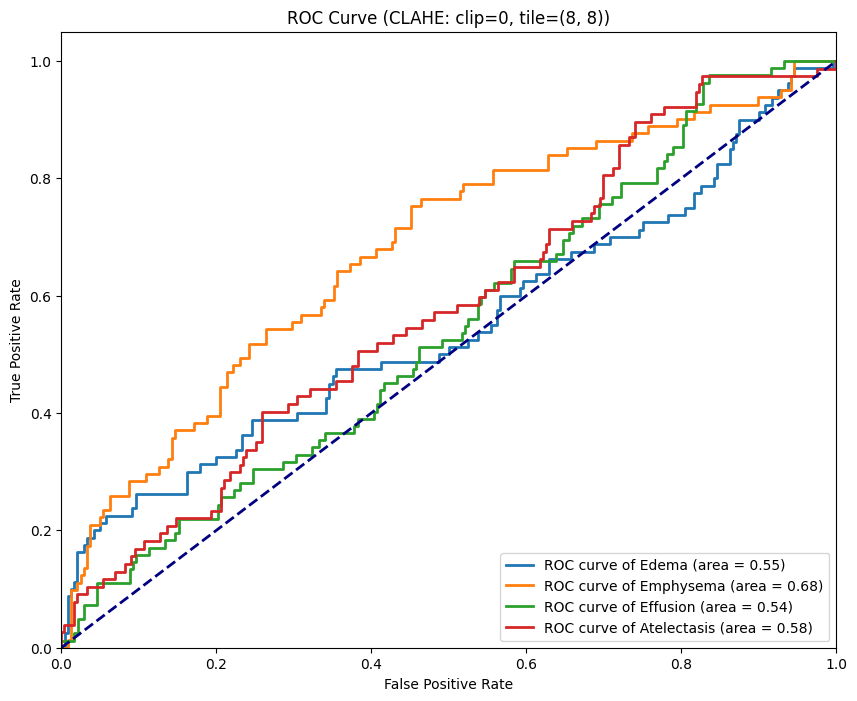

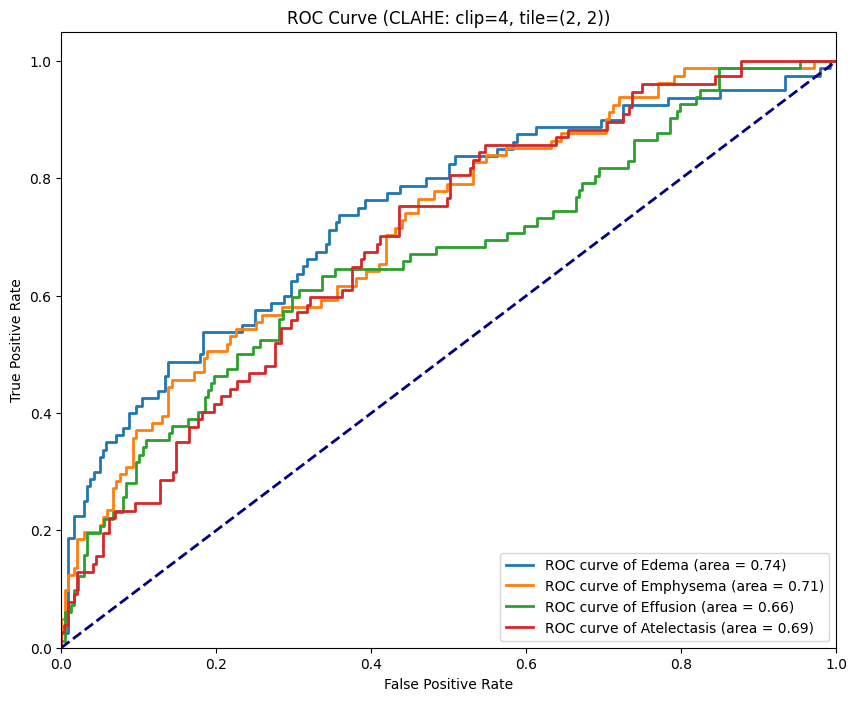

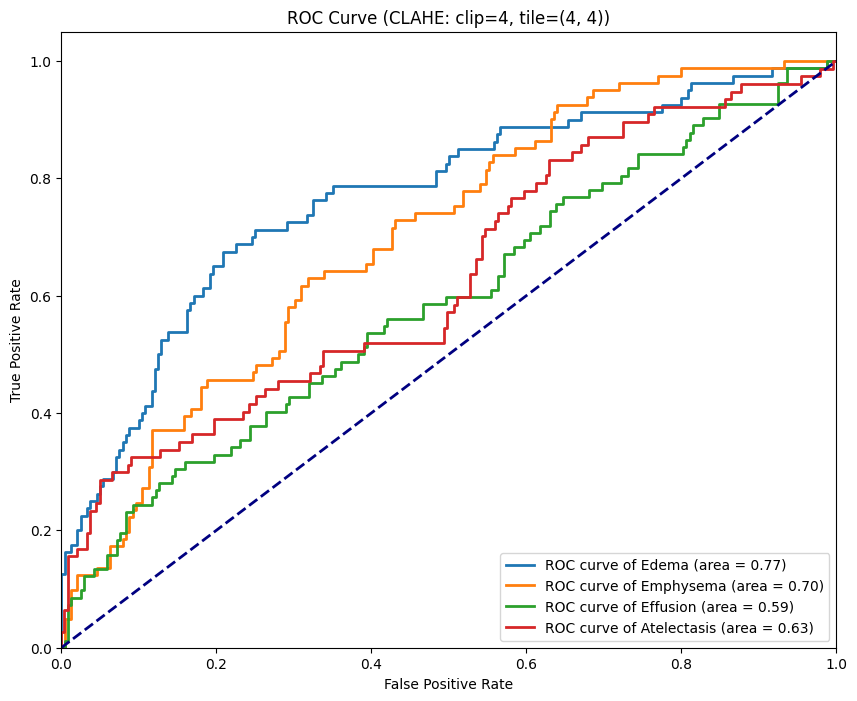

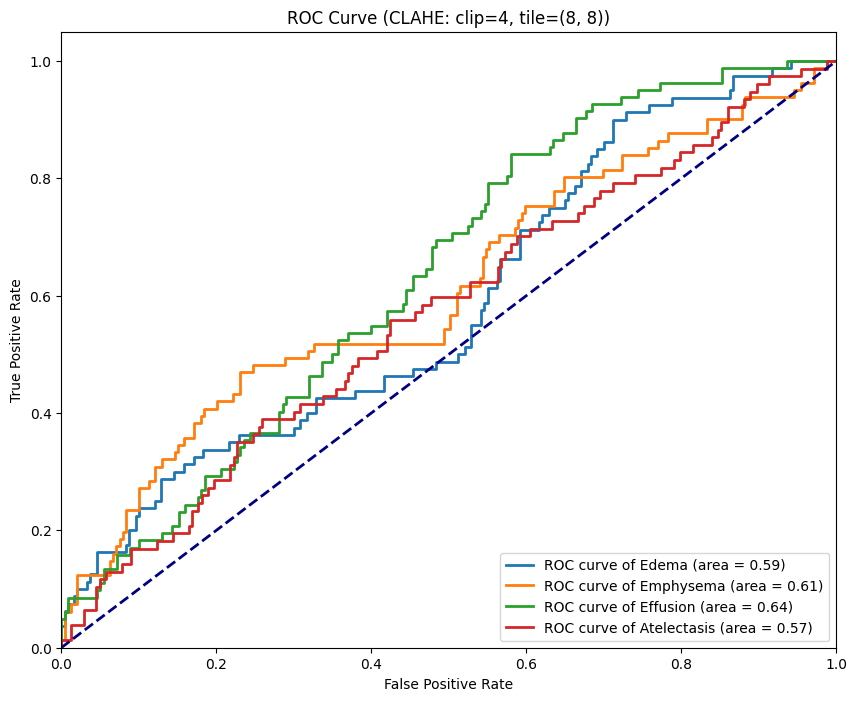

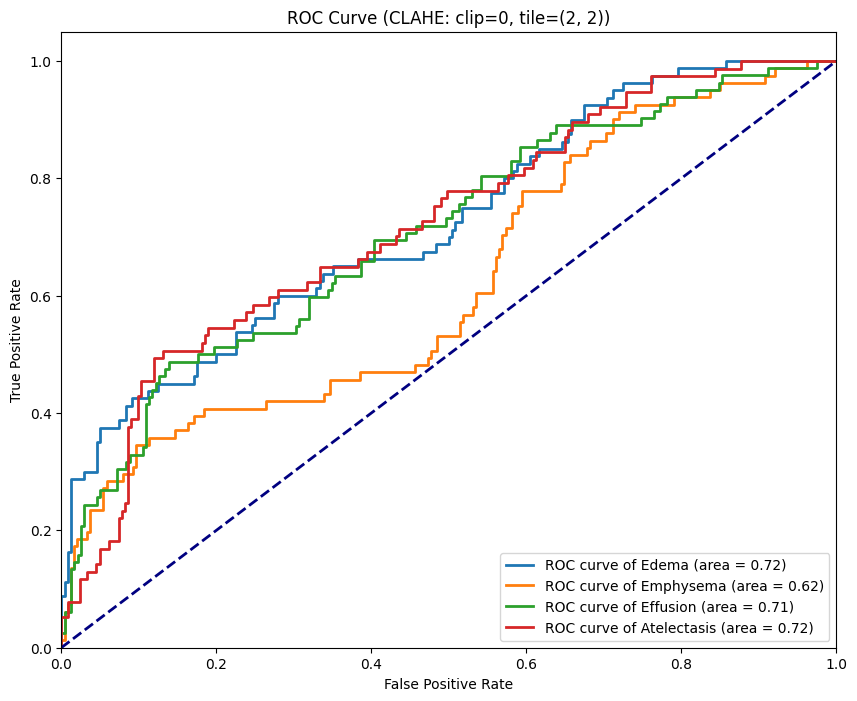

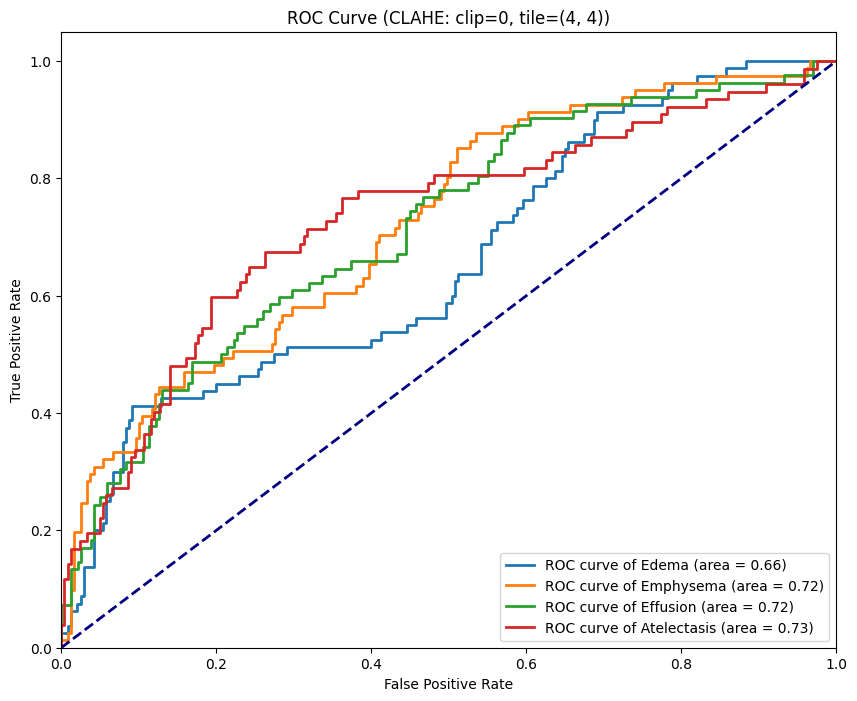

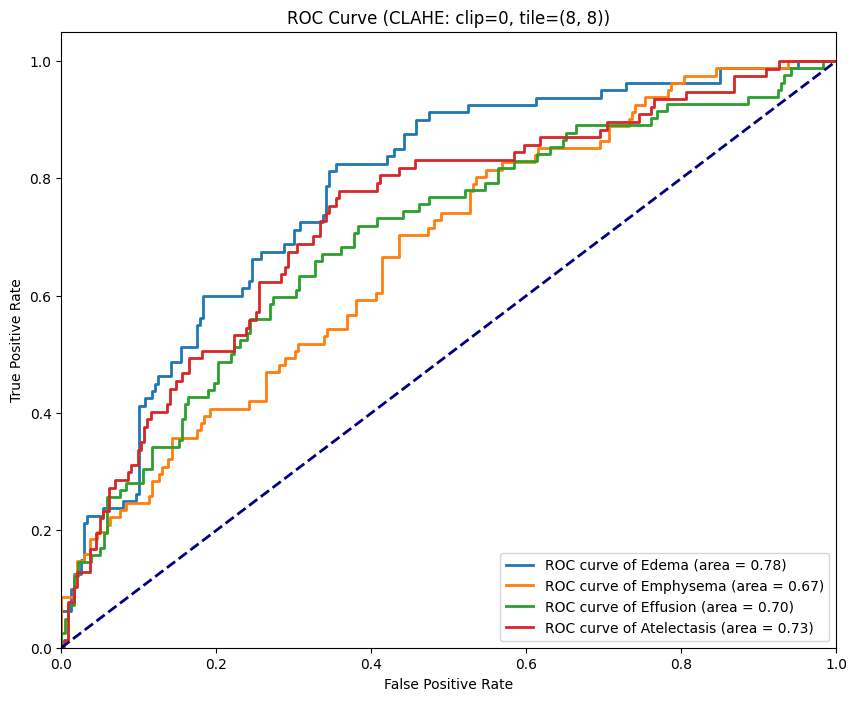

In [28]:
for result in results:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(TARGET)):
        fpr[i], tpr[i], _ = roc_curve(result['all_true'][:, i], result['all_oof'][:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # ROC 곡선 그리기
    plt.figure(figsize=(10, 8))
    for i in range(len(TARGET)):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (CLAHE: clip={result["clip_limit"]}, tile={result["tile_grid_size"]})')
    plt.legend(loc="lower right")
    plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Inference</b></div>


Processing result with CLAHE: clip=1.0, tile=(2, 2)
Fold 1
1/7 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step

I0000 00:00:1724005100.231784      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Accuracy for Test Set = 0.5
F1 Score for Test Set = 0.4320278707094123


<Figure size 1000x800 with 0 Axes>

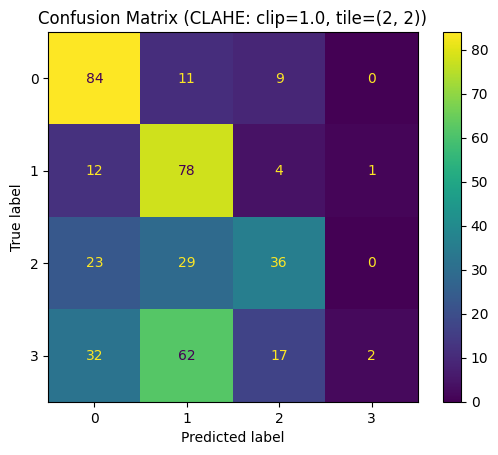

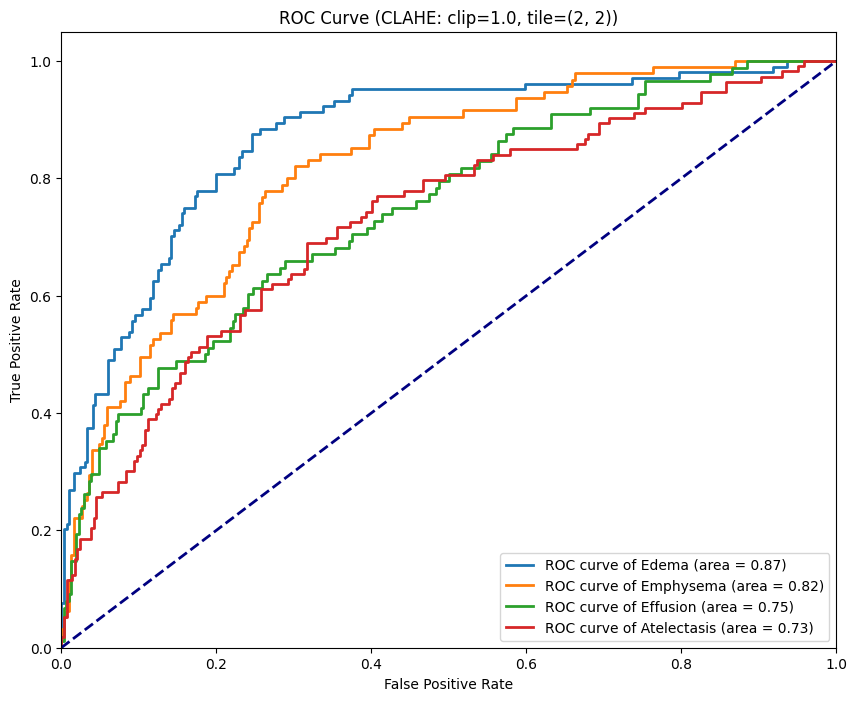


Processing result with CLAHE: clip=1.0, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Accuracy for Test Set = 0.38
F1 Score for Test Set = 0.3049068137675732


<Figure size 1000x800 with 0 Axes>

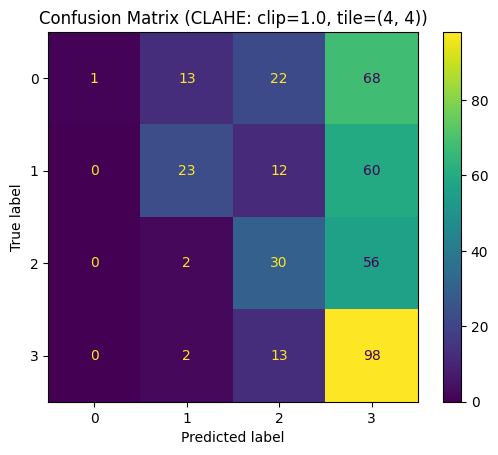

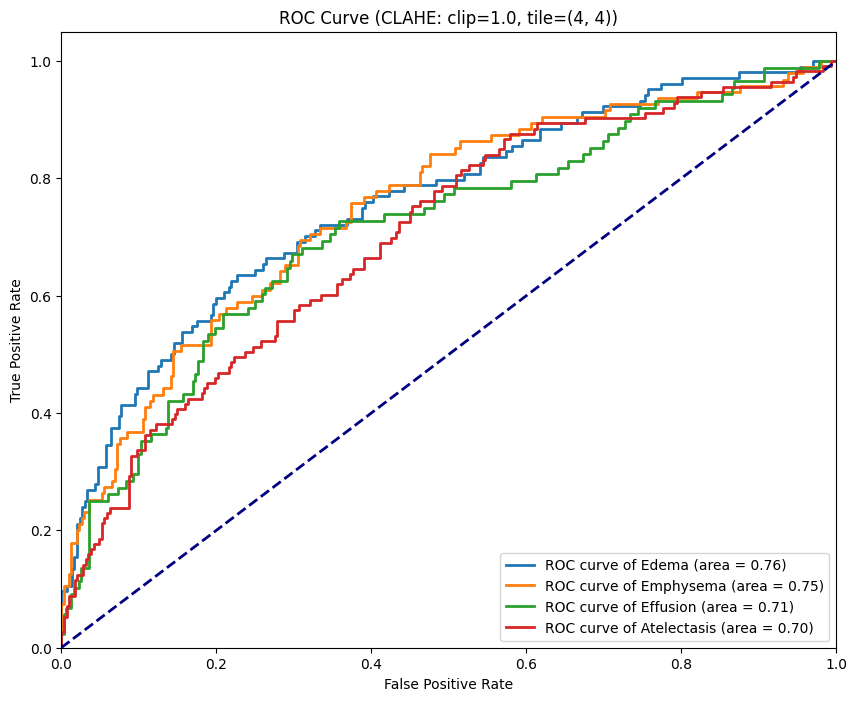


Processing result with CLAHE: clip=1.0, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.3875
F1 Score for Test Set = 0.32776594020991506


<Figure size 1000x800 with 0 Axes>

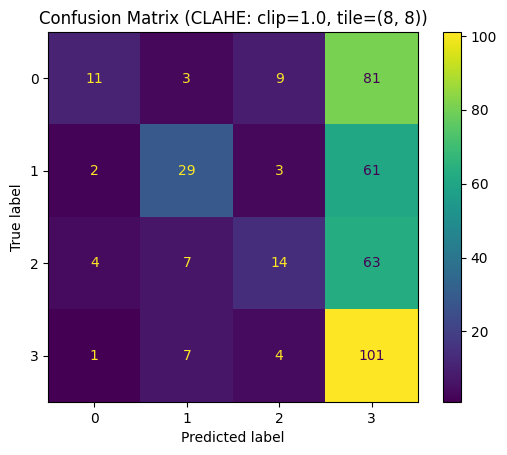

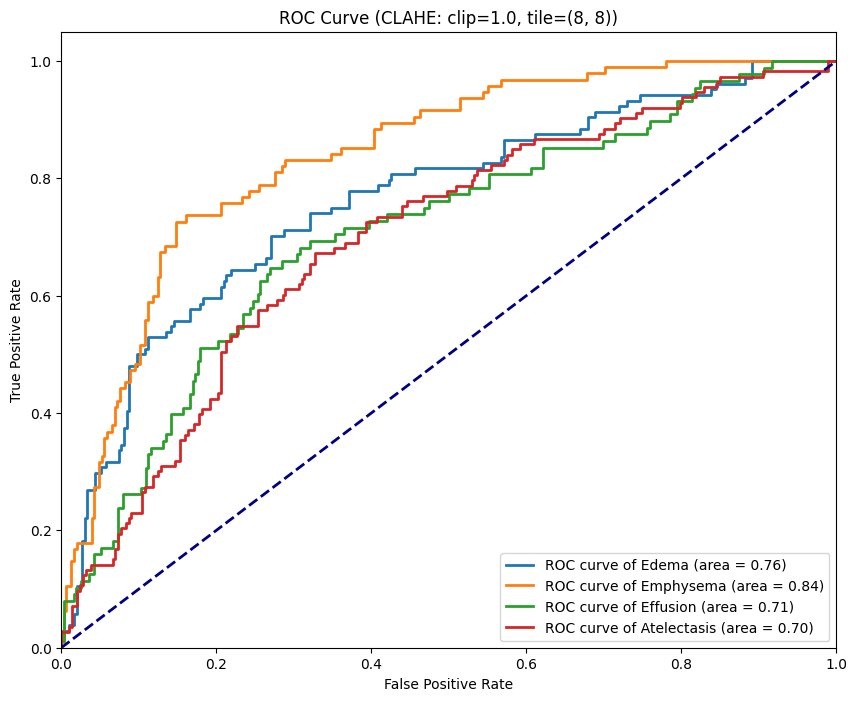


Processing result with CLAHE: clip=2, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Accuracy for Test Set = 0.245
F1 Score for Test Set = 0.1846527828516989


<Figure size 1000x800 with 0 Axes>

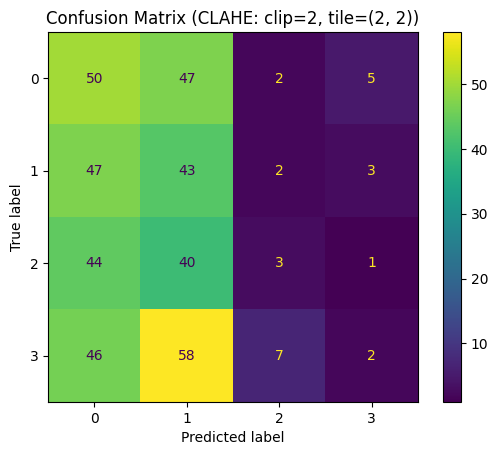

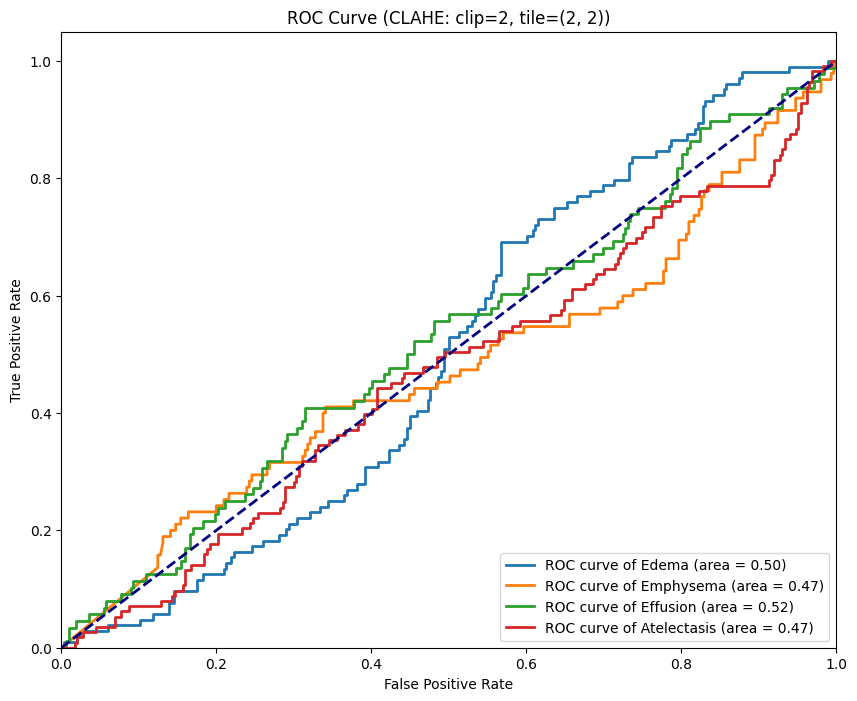


Processing result with CLAHE: clip=2, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.49
F1 Score for Test Set = 0.4153270228354458


<Figure size 1000x800 with 0 Axes>

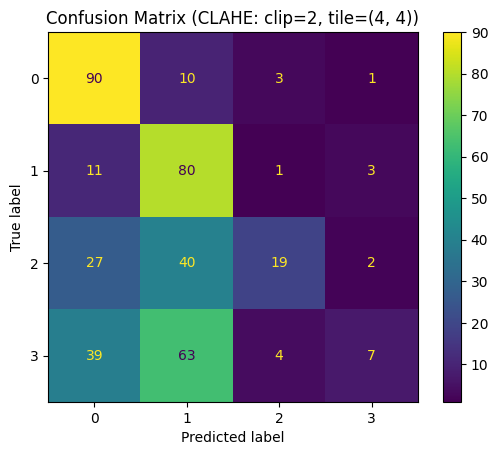

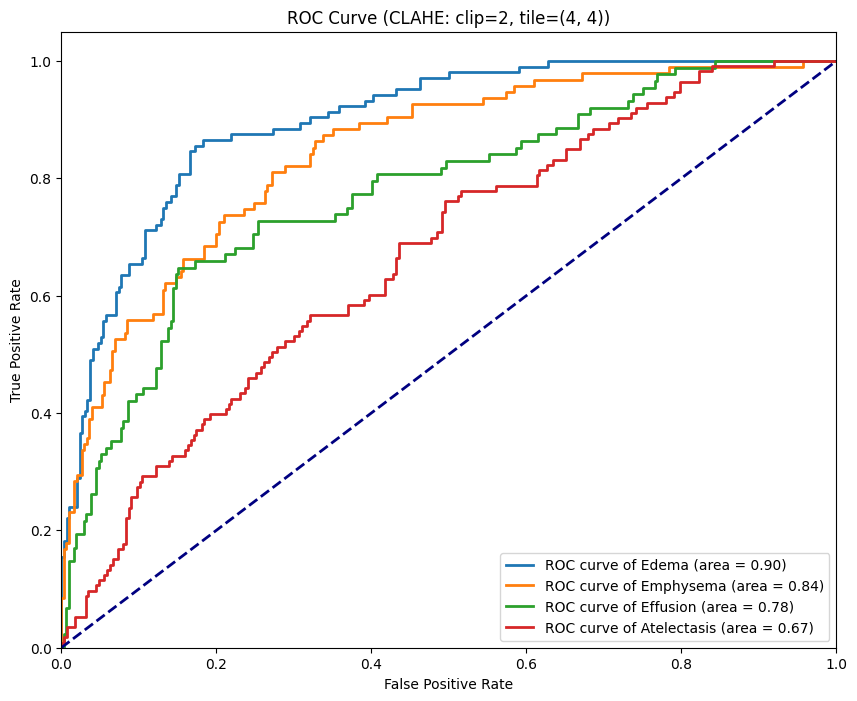


Processing result with CLAHE: clip=2, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.49
F1 Score for Test Set = 0.464296591869247


<Figure size 1000x800 with 0 Axes>

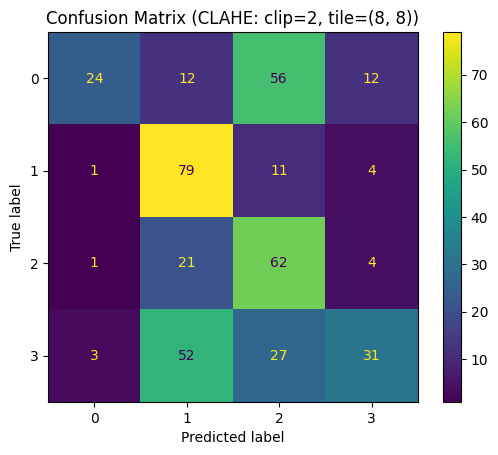

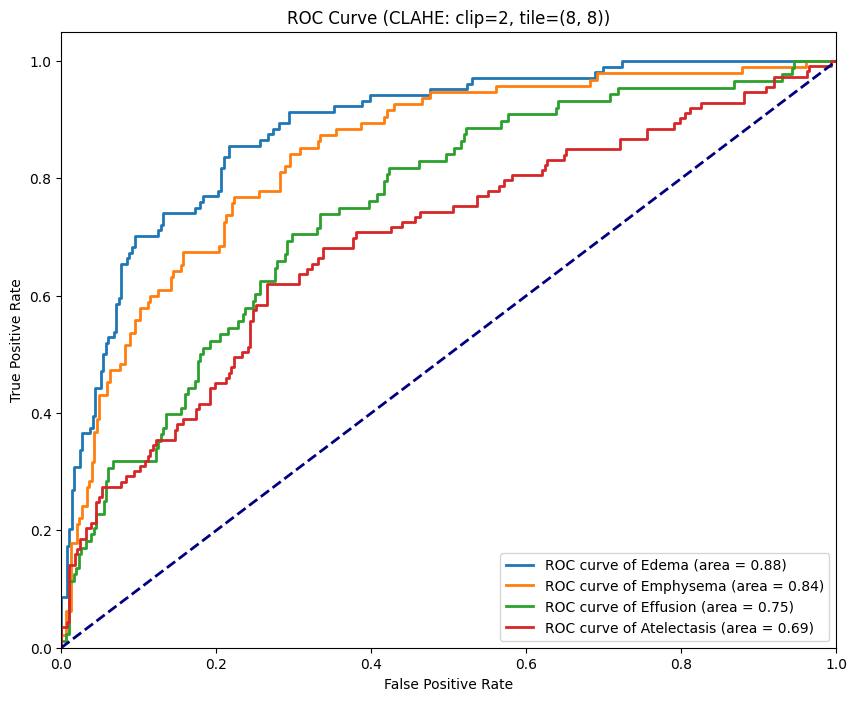


Processing result with CLAHE: clip=0, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.365
F1 Score for Test Set = 0.2570783455420506


<Figure size 1000x800 with 0 Axes>

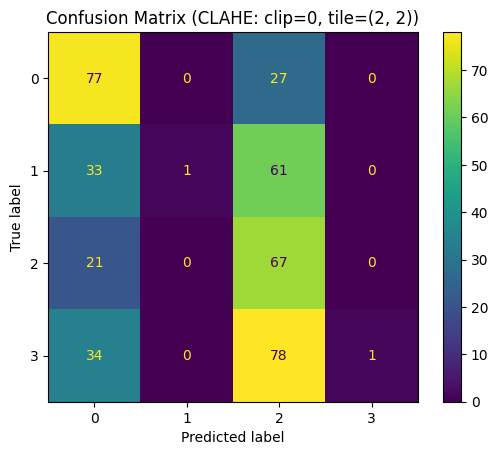

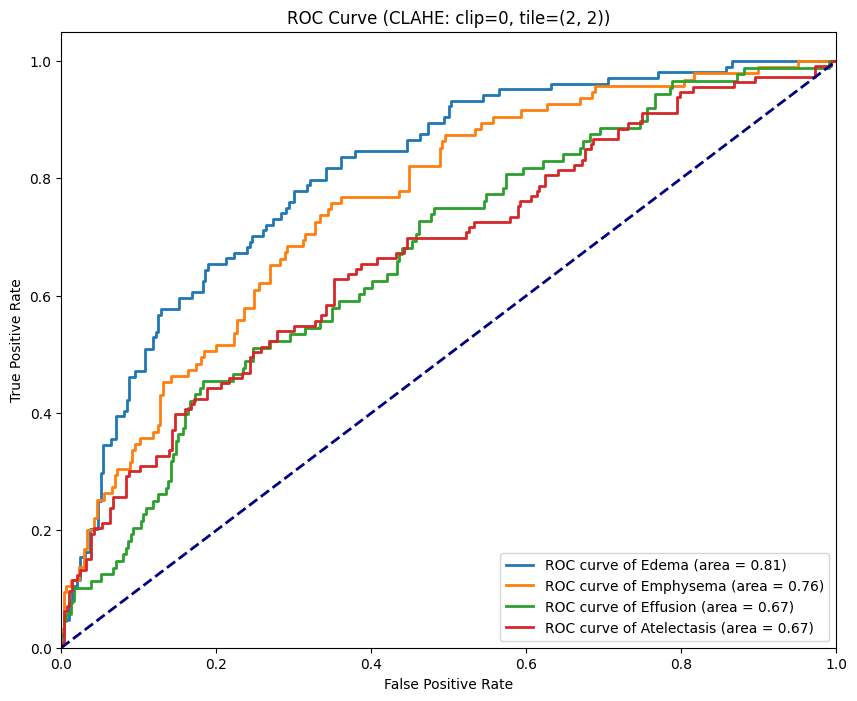


Processing result with CLAHE: clip=0, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.355
F1 Score for Test Set = 0.26976432717426524


<Figure size 1000x800 with 0 Axes>

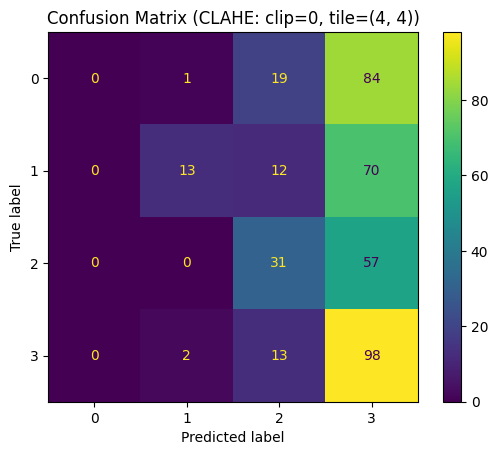

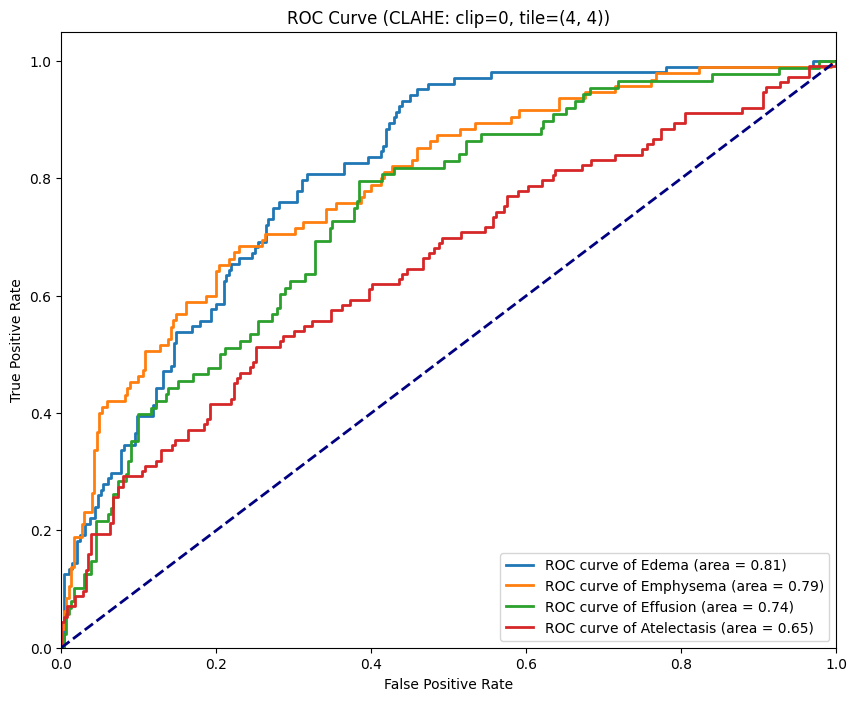


Processing result with CLAHE: clip=0, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.3575
F1 Score for Test Set = 0.2830217314633469


<Figure size 1000x800 with 0 Axes>

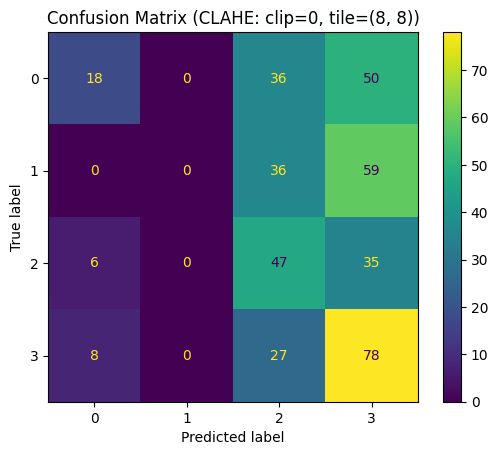

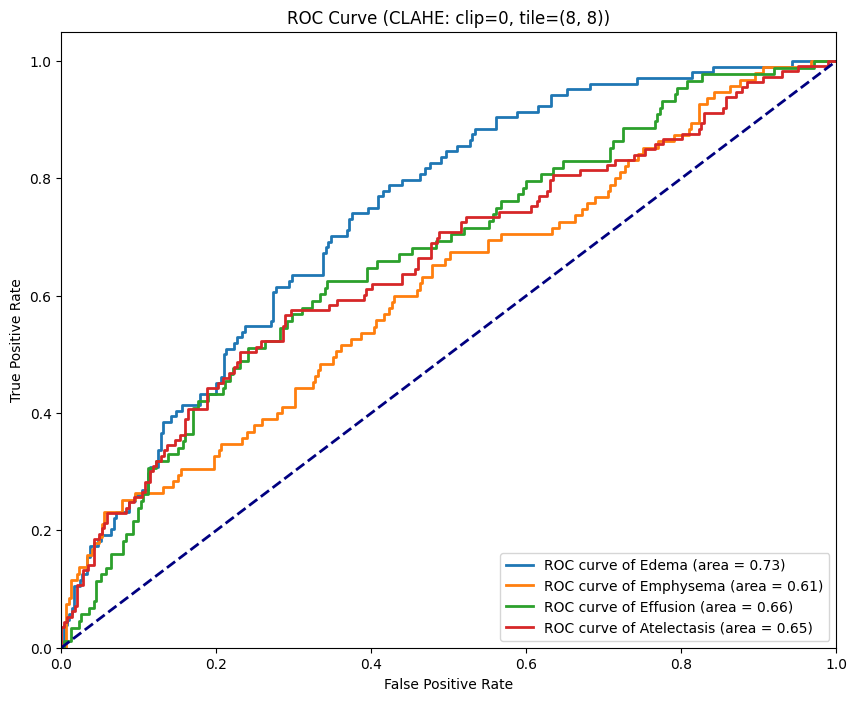


Processing result with CLAHE: clip=3, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.31
F1 Score for Test Set = 0.24575022337746866


<Figure size 1000x800 with 0 Axes>

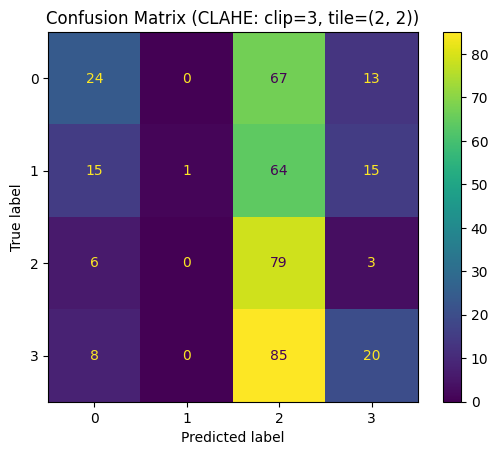

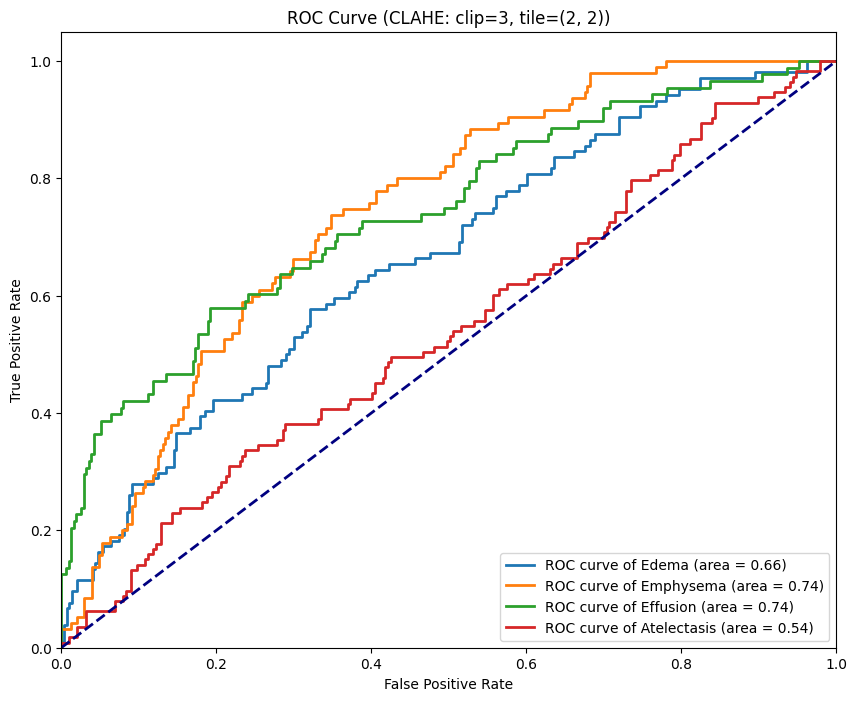


Processing result with CLAHE: clip=3, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.4975
F1 Score for Test Set = 0.4916138163660915


<Figure size 1000x800 with 0 Axes>

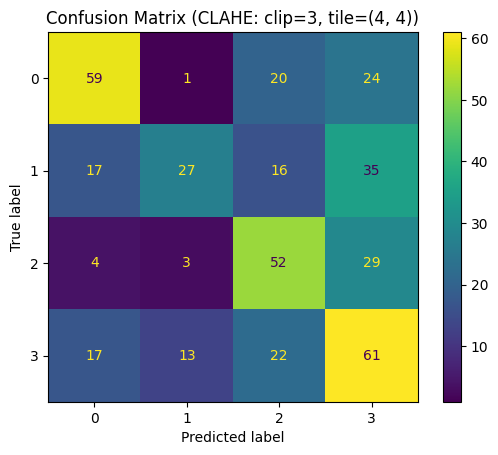

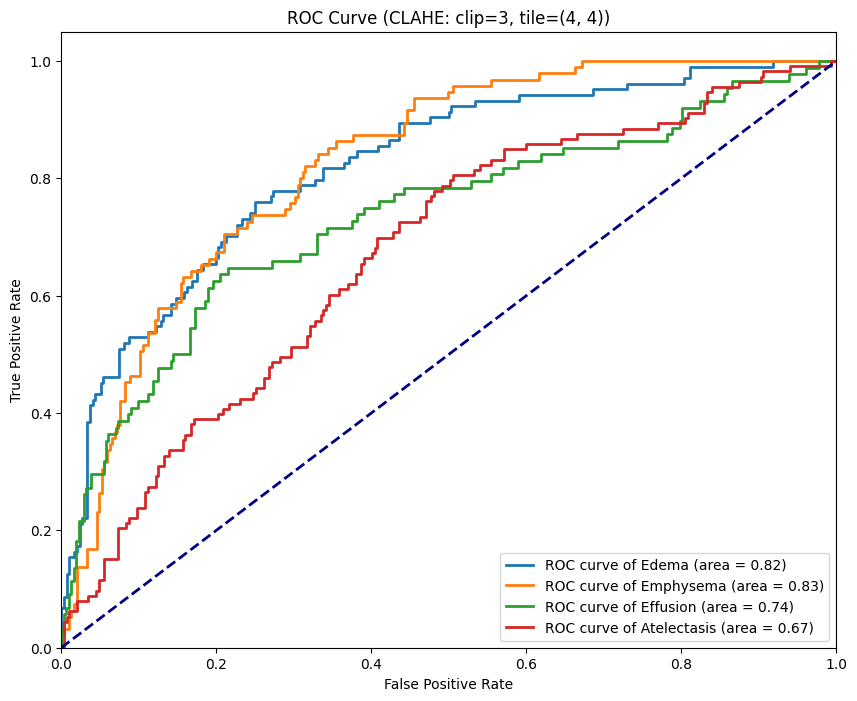


Processing result with CLAHE: clip=3, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.44
F1 Score for Test Set = 0.40772469175859827


<Figure size 1000x800 with 0 Axes>

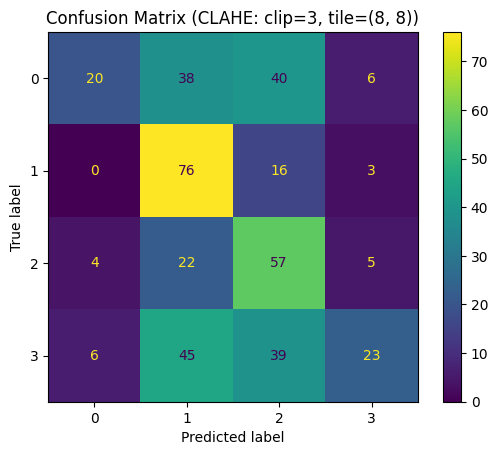

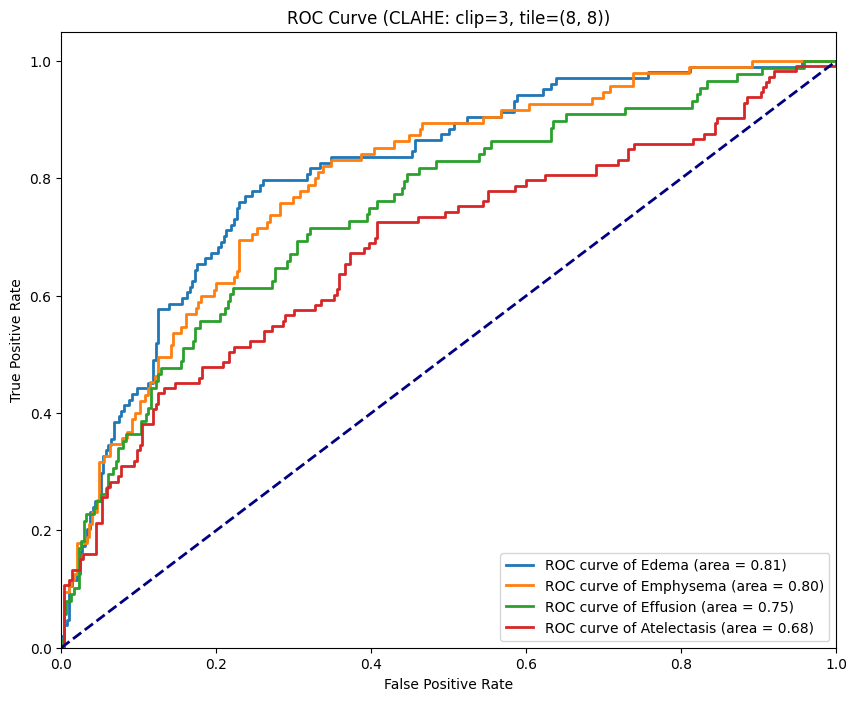


Processing result with CLAHE: clip=0, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Accuracy for Test Set = 0.365
F1 Score for Test Set = 0.2570783455420506


<Figure size 1000x800 with 0 Axes>

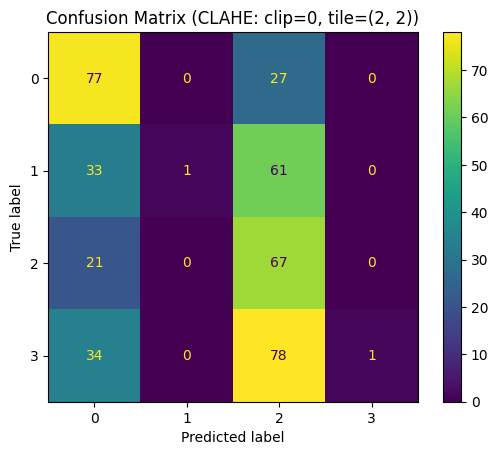

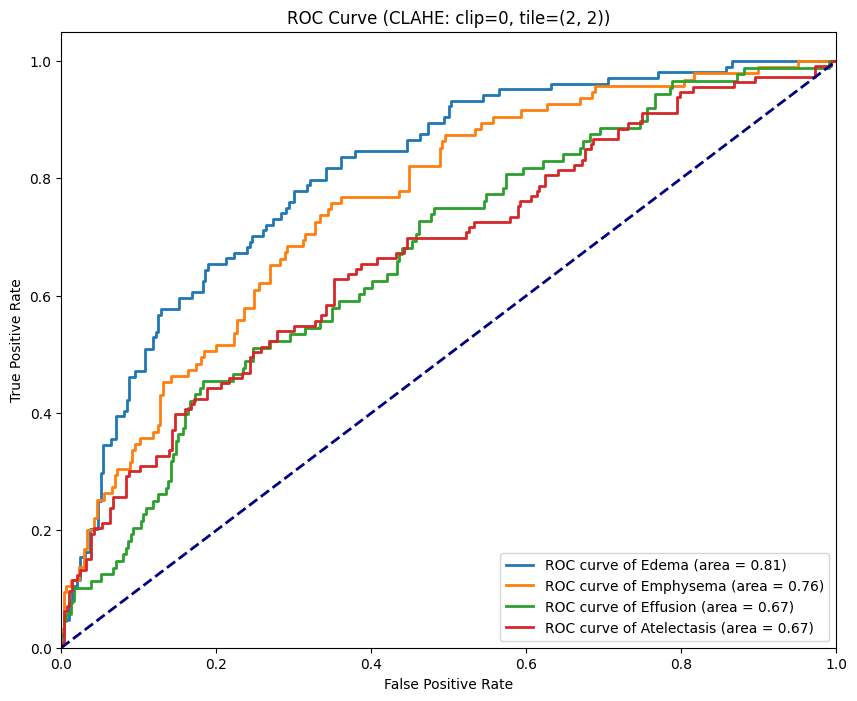


Processing result with CLAHE: clip=0, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.355
F1 Score for Test Set = 0.26976432717426524


<Figure size 1000x800 with 0 Axes>

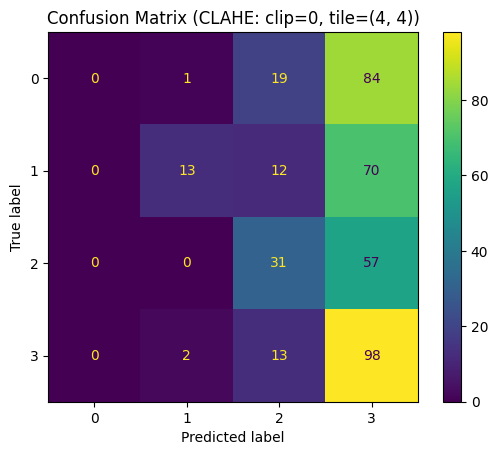

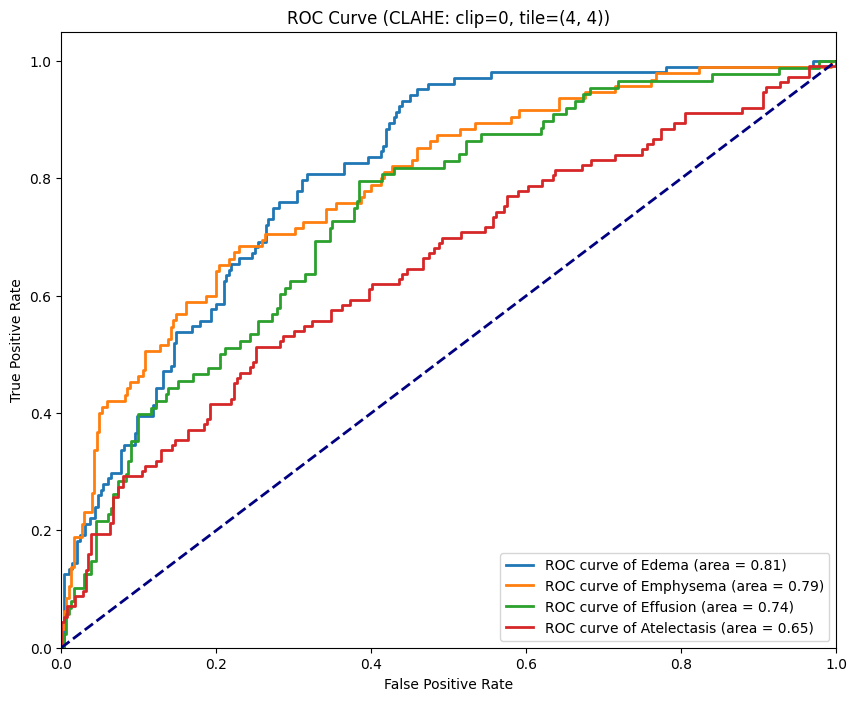


Processing result with CLAHE: clip=0, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.3575
F1 Score for Test Set = 0.2830217314633469


<Figure size 1000x800 with 0 Axes>

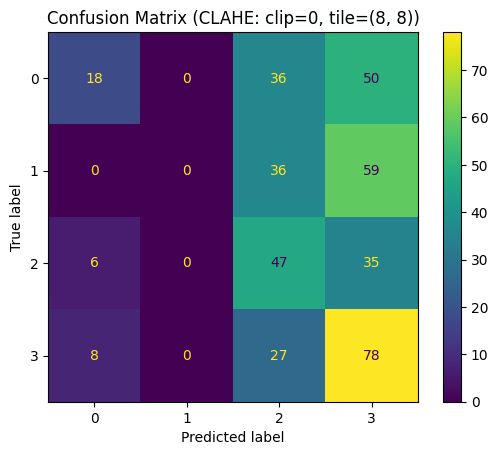

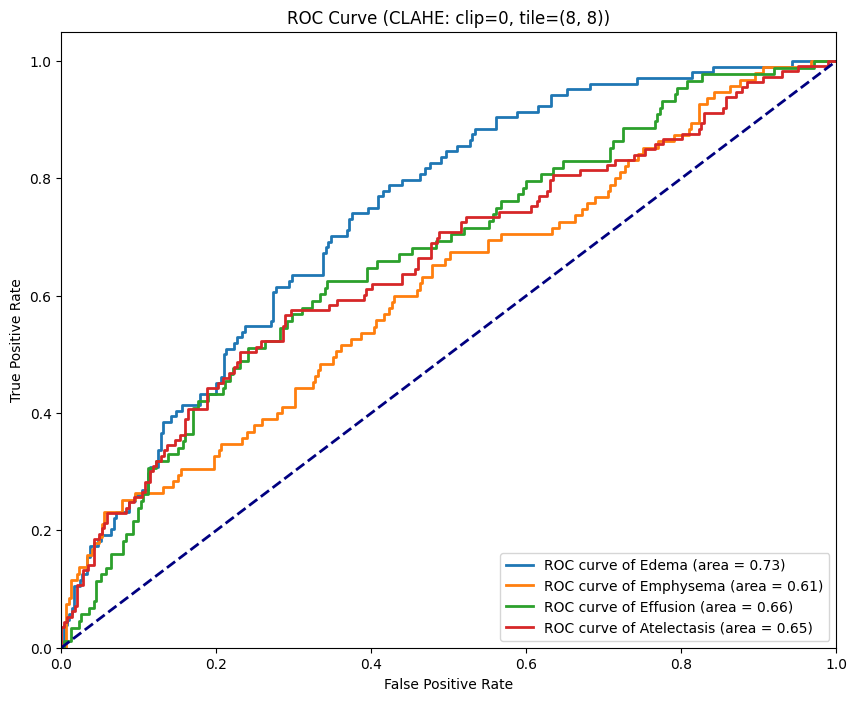


Processing result with CLAHE: clip=4, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.31
F1 Score for Test Set = 0.20849710663923582


<Figure size 1000x800 with 0 Axes>

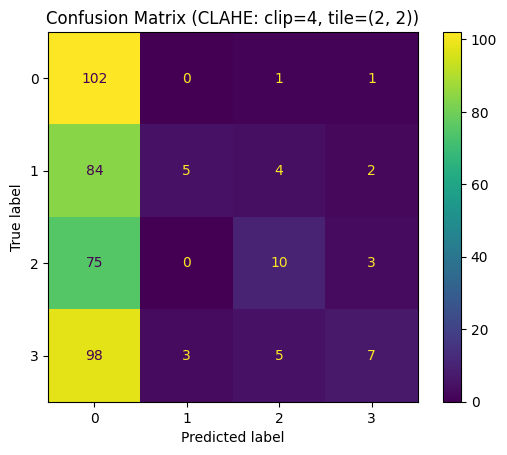

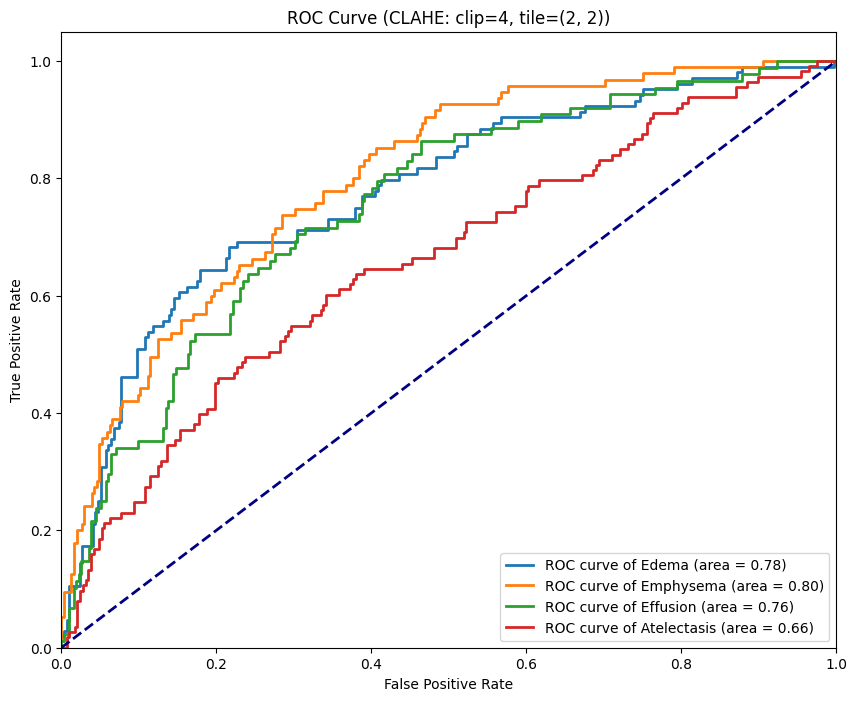


Processing result with CLAHE: clip=4, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.27
F1 Score for Test Set = 0.18216658150229942


<Figure size 1000x800 with 0 Axes>

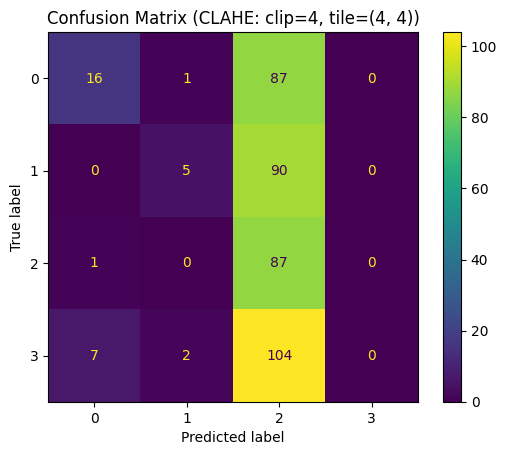

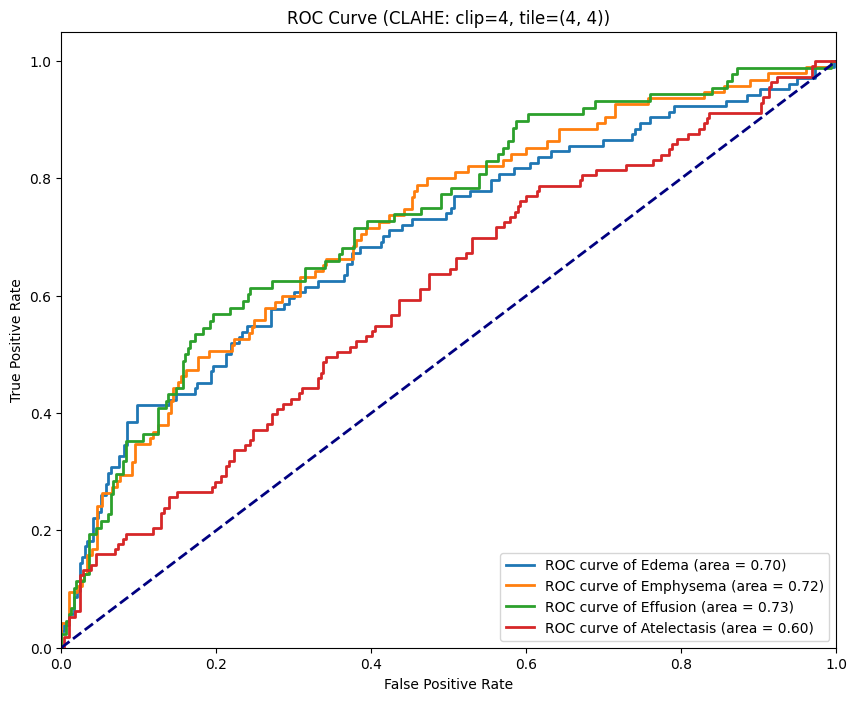


Processing result with CLAHE: clip=4, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.2375
F1 Score for Test Set = 0.09615384615384615


<Figure size 1000x800 with 0 Axes>

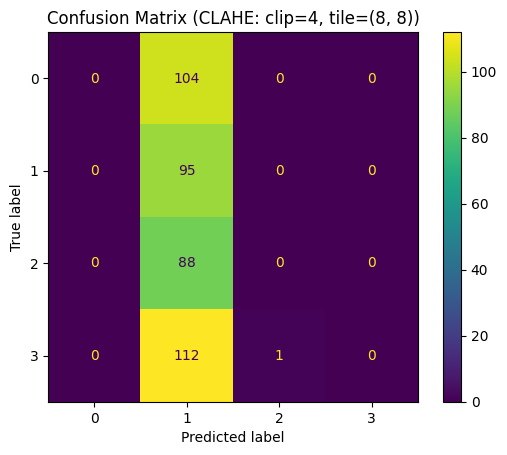

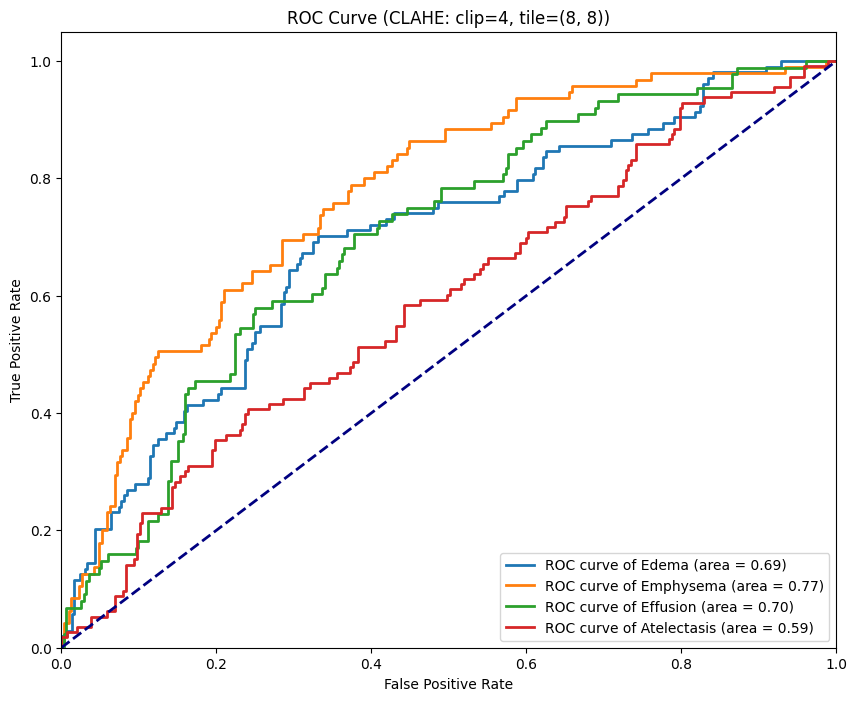


Processing result with CLAHE: clip=0, tile=(2, 2)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Accuracy for Test Set = 0.365
F1 Score for Test Set = 0.2570783455420506


<Figure size 1000x800 with 0 Axes>

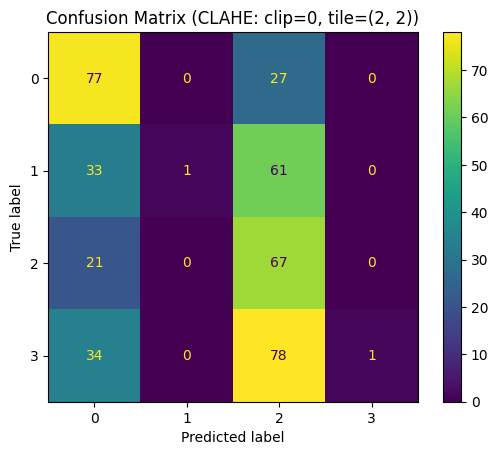

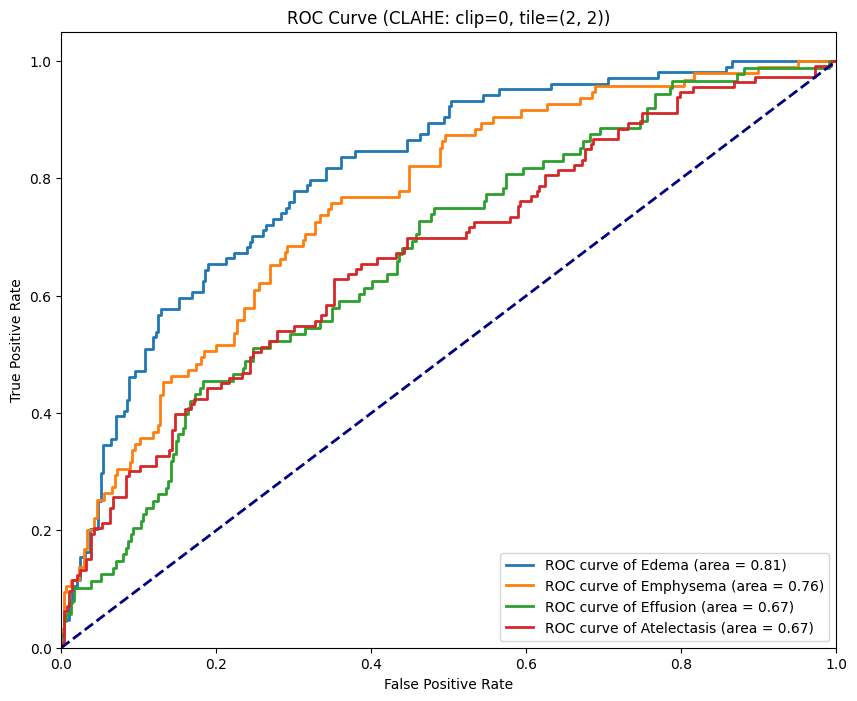


Processing result with CLAHE: clip=0, tile=(4, 4)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.355
F1 Score for Test Set = 0.26976432717426524


<Figure size 1000x800 with 0 Axes>

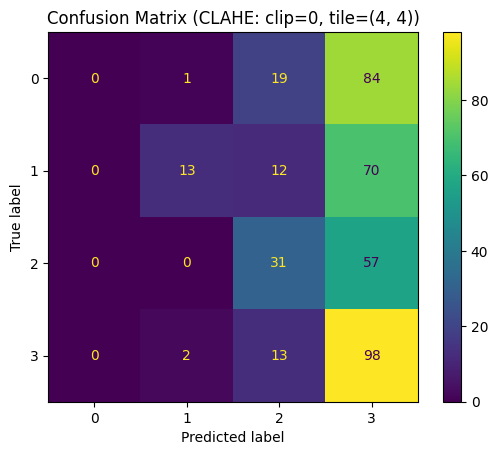

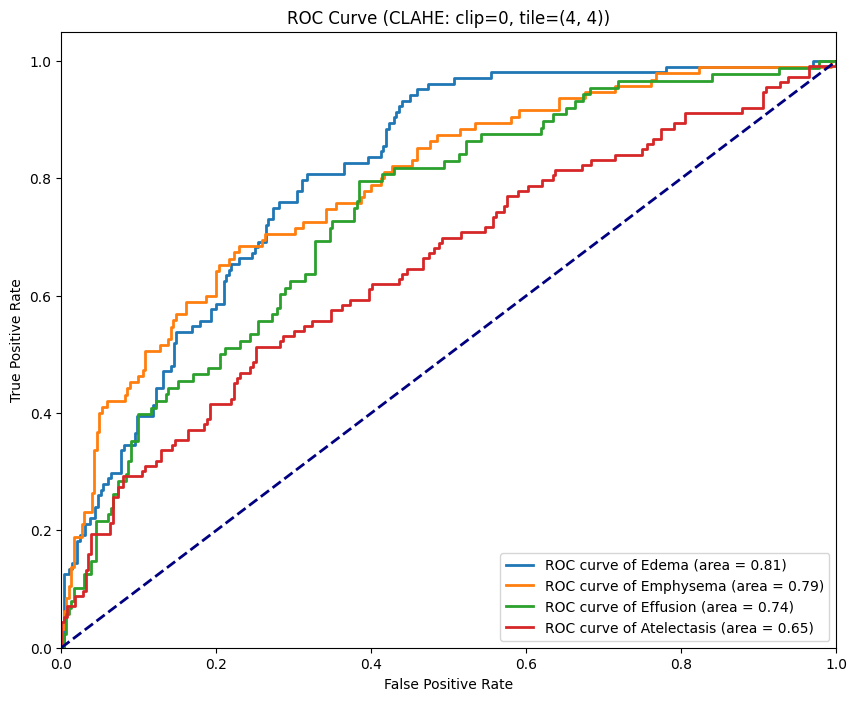


Processing result with CLAHE: clip=0, tile=(8, 8)
Fold 1
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Accuracy for Test Set = 0.3575
F1 Score for Test Set = 0.2830217314633469


<Figure size 1000x800 with 0 Axes>

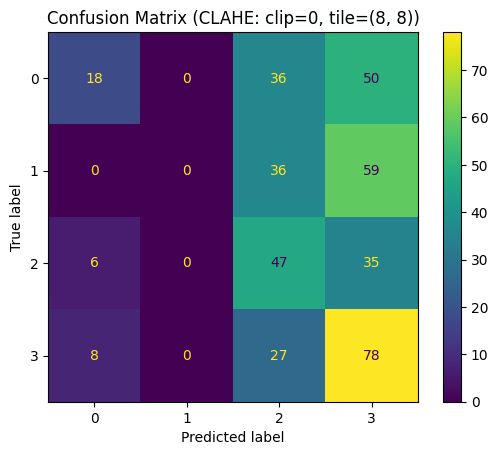

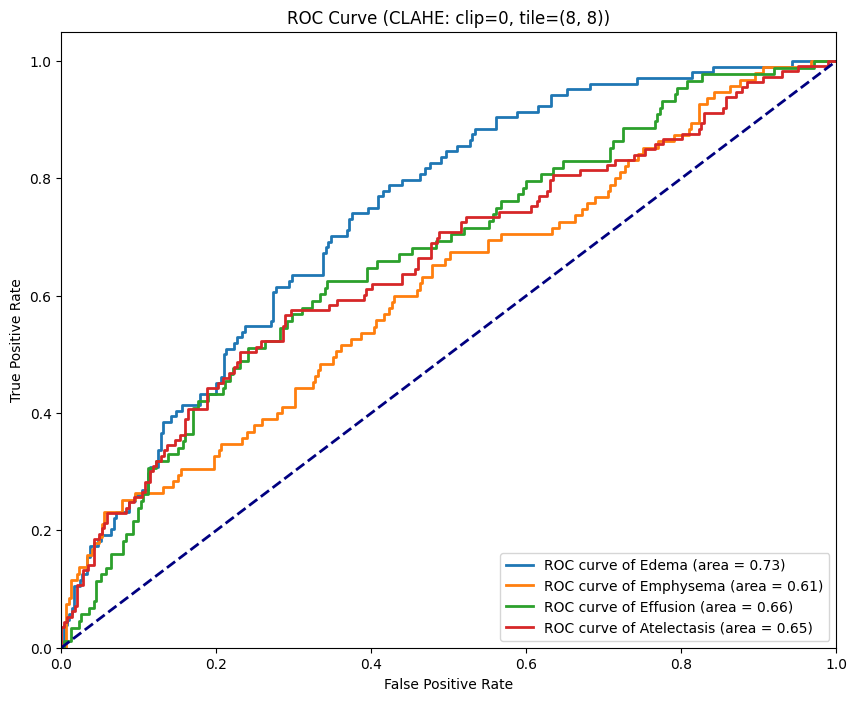

In [29]:
for result in results:
    clip_limit = result['clip_limit']
    tile_grid_size = result['tile_grid_size']
    
    print(f"\nProcessing result with CLAHE: clip={clip_limit}, tile={tile_grid_size}")
    
    preds = []
    model = build_model()
    
    ## No TTA
    test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=preprocess_input)
    for i in range(1):
        print(f'Fold {i+1}') 
        if LOAD_MODELS_FROM:
            model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
        else: 
            model.load_weights(f'ResNet_f{i}_clip{clip_limit}_tile{tile_grid_size[0]}.weights.h5')
    
        pred = model.predict(test_gen, verbose=1) 
        
        preds.append(pred)
    
    pred_res = np.mean(preds, axis=0)
    
    # Accuracy
    accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
    print('Accuracy for Test Set =', accuracy)
    
    # F1 Score
    f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro')
    print('F1 Score for Test Set =', f1)
    
    # Confusion Matrix
    cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
    plt.figure(figsize=(10, 8))
    display.plot()
    plt.title(f'Confusion Matrix (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    plt.show()

    # ROC Curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, target in enumerate(TARGET):
        fpr[i], tpr[i], _ = roc_curve(df_test[target], pred_res[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # ROC 곡선 그리기
    plt.figure(figsize=(10, 8))
    for i, target in enumerate(TARGET):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'ROC curve of {target} (area = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (CLAHE: clip={clip_limit}, tile={tile_grid_size})')
    plt.legend(loc="lower right")
    plt.show()

#### TTA
___

In [30]:
"""## No TTA
test_gen = DataGenerator(df_test, shuffle=False, augment1=True, batch_size=64, preprocess=preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'ResNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)"""

"## No TTA\ntest_gen = DataGenerator(df_test, shuffle=False, augment1=True, batch_size=64, preprocess=preprocess_input)\n\nfor i in range(1):\n    print(f'Fold {i+1}') \n    if LOAD_MODELS_FROM:\n        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_f{i}.weights.h5')\n    else: \n        model.load_weights(f'ResNet_f{i}.weights.h5')\n    \n    pred = model.predict(test_gen, verbose=1) \n    \npreds.append(pred)\npred_res = np.mean(preds,axis=0)\n    \n# Accuracy \naccuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))\nprint('Accuracy for Test Set =', accuracy)\n\n# F1 Score \nf1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') \nprint('F1 Score for Test Set =', f1)"